# TESS Atlas fit for TOI 493

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 493.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-493.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-493.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-493.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 493

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 493 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

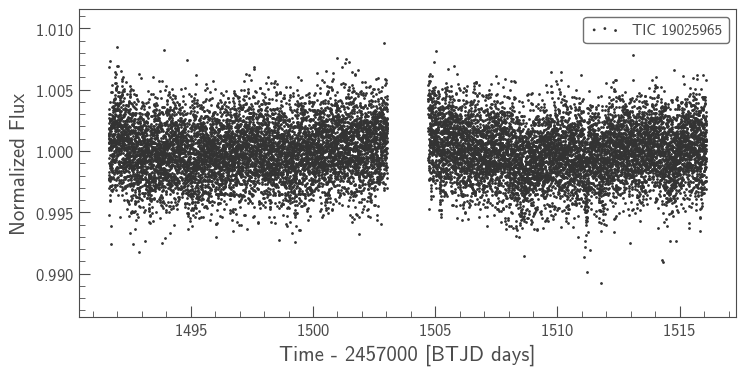

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -40280.6601064742 -> -40222.62771237364


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -36607.89780297224 -> -35999.50824569622


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -35999.50824569622 -> -35947.973543349304


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -35947.973543349304 -> -35947.972040703025


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -35947.972040703025 -> -35946.56577879741


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -35946.56577879741 -> -35946.52985816193


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -35946.52985816193 -> -35939.0476116471


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -35939.0476116471 -> -35939.0476116471


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -35939.0476116471 -> -35939.0476116471


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -35939.0476116471 -> -35939.0476116471


optimizing logp for variables: ['mean', 't0', 'logP']


message: Optimization terminated successfully.
logp: -35939.0476116471 -> -35939.04761164699


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -35939.04761164699 -> -35939.04761164699


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Optimization terminated successfully.
logp: -35939.04761164699 -> -35939.04761164699


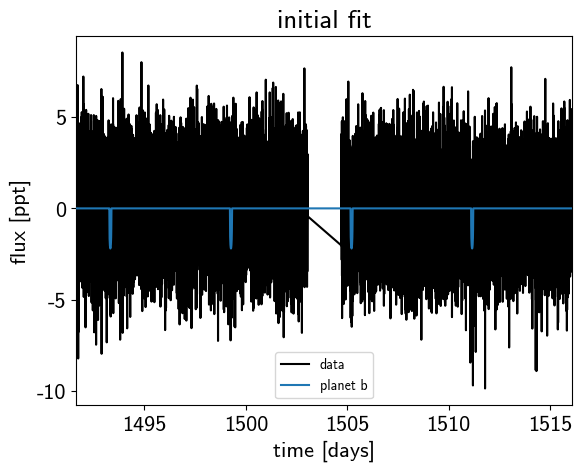

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:07, 13.46draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:07, 11.96draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:18,  5.06draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:18,  4.86draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:21,  4.30draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:01<00:21,  4.25draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:22,  3.89draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:24,  3.55draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:02<00:22,  3.82draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:29,  2.91draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:27,  3.08draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:22,  3.76draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:28,  2.91draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:26,  2.97draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:25,  3.11draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:23,  3.33draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:23,  3.26draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:25,  2.89draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:06<00:20,  3.53draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:07<00:27,  2.65draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:08<00:25,  2.75draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:24,  2.83draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:09<00:22,  2.94draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:09<00:19,  3.37draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:10<00:21,  3.09draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:10<00:20,  3.07draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:10<00:19,  3.29draws/s]

Sampling 2 chains:  40%|████      | 42/104 [00:11<00:21,  2.86draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:11<00:17,  3.53draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:11<00:21,  2.76draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:12<00:19,  2.95draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:12<00:15,  3.59draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:13<00:15,  3.53draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:13<00:14,  3.55draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:14<00:14,  3.43draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:14<00:14,  3.49draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:15<00:13,  3.50draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:15<00:13,  3.50draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:15<00:13,  3.36draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:15<00:12,  3.62draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:16<00:14,  3.12draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:16<00:11,  3.74draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:16<00:12,  3.32draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:17<00:10,  4.03draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:17<00:12,  3.33draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:18<00:11,  3.37draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:18<00:09,  4.08draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:18<00:10,  3.45draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:18<00:08,  4.10draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:19<00:09,  3.51draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:19<00:07,  4.14draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:19<00:08,  3.62draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:20<00:08,  3.72draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:20<00:06,  4.36draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:20<00:08,  3.46draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:21<00:07,  3.51draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:21<00:06,  3.55draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:22<00:05,  3.67draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:22<00:05,  3.73draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:23<00:04,  3.82draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:23<00:04,  3.85draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:24<00:03,  3.83draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:24<00:03,  4.12draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:24<00:03,  3.27draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:25<00:03,  3.29draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:26<00:02,  3.45draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:26<00:01,  3.93draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:26<00:01,  3.54draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:26<00:01,  3.21draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:27<00:01,  3.85draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:27<00:01,  2.95draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:28<00:00,  2.46draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:29<00:00,  1.65draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:30<00:00,  1.39draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:06, 14.91draws/s]

Sampling 2 chains:  10%|▉         | 10/104 [00:00<00:08, 10.86draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:17,  5.41draws/s]

Sampling 2 chains:  12%|█▏        | 12/104 [00:01<00:21,  4.27draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:21,  4.31draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:28,  3.21draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:27,  3.23draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:25,  3.35draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:03<00:20,  4.04draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:23,  3.48draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:21,  3.78draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:27,  2.92draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:25,  3.08draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:21,  3.58draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:05<00:23,  3.21draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:23,  3.23draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:24,  3.11draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:06<00:23,  3.09draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:07<00:19,  3.66draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:07<00:16,  4.36draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:21,  3.30draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:07<00:20,  3.44draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:20,  3.39draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:08<00:21,  3.18draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:08<00:17,  3.77draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:09<00:17,  3.69draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:09<00:14,  4.54draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:10<00:22,  2.83draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:10<00:20,  2.94draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:11<00:19,  2.98draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:11<00:19,  2.95draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:12<00:18,  2.97draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:12<00:14,  3.59draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:13<00:14,  3.49draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:13<00:16,  3.01draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:13<00:13,  3.66draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:14<00:13,  3.70draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:14<00:13,  3.47draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:14<00:12,  3.78draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:15<00:14,  3.26draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:15<00:12,  3.50draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:15<00:13,  3.37draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:15<00:13,  3.16draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:16<00:11,  3.62draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:16<00:14,  2.85draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:17<00:12,  3.08draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:17<00:11,  3.41draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:17<00:11,  3.21draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:18<00:12,  2.98draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:18<00:10,  3.37draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:18<00:11,  2.93draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:18<00:09,  3.48draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:19<00:11,  2.86draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:19<00:08,  3.48draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:20<00:09,  3.01draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:20<00:08,  3.15draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:21<00:08,  3.18draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:21<00:07,  3.49draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:21<00:07,  3.32draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:22<00:07,  2.98draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:22<00:06,  3.45draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:22<00:06,  3.04draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:23<00:05,  3.33draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:23<00:04,  4.13draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:23<00:05,  3.14draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:23<00:04,  3.91draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:24<00:04,  3.16draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:24<00:03,  3.96draws/s]

Sampling 2 chains:  88%|████████▊ | 91/104 [00:25<00:04,  3.01draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:25<00:03,  3.14draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:25<00:02,  3.88draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:26<00:03,  2.94draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:26<00:02,  3.03draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:27<00:01,  3.86draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:27<00:01,  3.45draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:27<00:01,  2.72draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:28<00:00,  2.79draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:29<00:00,  1.92draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:30<00:00,  1.40draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<02:05,  1.61draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<01:31,  2.21draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:00<01:08,  2.92draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<01:00,  3.27draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:01<00:52,  3.73draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:01<00:49,  3.90draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:02<00:49,  3.87draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:02<00:42,  4.47draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:03<01:05,  2.93draws/s]

Sampling 2 chains:   7%|▋         | 14/204 [00:03<00:53,  3.57draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:03<01:08,  2.76draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:03<00:50,  3.68draws/s]

Sampling 2 chains:   9%|▉         | 18/204 [00:04<01:16,  2.43draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:04<01:01,  3.03draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:05<01:15,  2.45draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:05<01:07,  2.68draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:06<00:53,  3.36draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:06<01:05,  2.77draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:06<00:52,  3.41draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:07<00:45,  3.85draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:07<00:42,  4.12draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:07<00:44,  3.93draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:07<00:37,  4.68draws/s]

Sampling 2 chains:  15%|█▌        | 31/204 [00:07<00:42,  4.08draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:08<00:52,  3.26draws/s]

Sampling 2 chains:  16%|█▌        | 33/204 [00:08<00:44,  3.85draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:08<00:36,  4.67draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:09<00:51,  3.28draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:09<00:44,  3.72draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:09<00:42,  3.89draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:10<00:44,  3.67draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:11<00:45,  3.54draws/s]

Sampling 2 chains:  22%|██▏       | 45/204 [00:11<00:35,  4.54draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:11<00:39,  4.02draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:11<00:39,  3.96draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:12<00:45,  3.47draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:12<00:45,  3.42draws/s]

Sampling 2 chains:  25%|██▍       | 50/204 [00:12<00:41,  3.72draws/s]

Sampling 2 chains:  25%|██▌       | 51/204 [00:12<00:40,  3.81draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:13<00:45,  3.36draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:13<00:42,  3.59draws/s]

Sampling 2 chains:  26%|██▋       | 54/204 [00:13<00:44,  3.36draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:14<00:46,  3.22draws/s]

Sampling 2 chains:  27%|██▋       | 56/204 [00:14<00:43,  3.38draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:14<00:45,  3.24draws/s]

Sampling 2 chains:  28%|██▊       | 58/204 [00:15<00:41,  3.48draws/s]

Sampling 2 chains:  29%|██▉       | 59/204 [00:15<00:38,  3.72draws/s]

Sampling 2 chains:  30%|██▉       | 61/204 [00:15<00:29,  4.82draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:15<00:27,  5.20draws/s]

Sampling 2 chains:  31%|███       | 63/204 [00:15<00:24,  5.79draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:15<00:25,  5.49draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:16<00:40,  3.41draws/s]

Sampling 2 chains:  33%|███▎      | 67/204 [00:17<00:39,  3.47draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:17<00:32,  4.12draws/s]

Sampling 2 chains:  34%|███▍      | 69/204 [00:17<00:33,  4.06draws/s]

Sampling 2 chains:  35%|███▍      | 71/204 [00:17<00:28,  4.70draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:18<00:38,  3.46draws/s]

Sampling 2 chains:  36%|███▌      | 73/204 [00:18<00:31,  4.15draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:18<00:37,  3.45draws/s]

Sampling 2 chains:  37%|███▋      | 75/204 [00:18<00:36,  3.52draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:19<00:35,  3.61draws/s]

Sampling 2 chains:  38%|███▊      | 78/204 [00:19<00:34,  3.65draws/s]

Sampling 2 chains:  39%|███▊      | 79/204 [00:20<00:34,  3.66draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:20<00:33,  3.67draws/s]

Sampling 2 chains:  40%|███▉      | 81/204 [00:20<00:33,  3.71draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:20<00:33,  3.67draws/s]

Sampling 2 chains:  41%|████      | 83/204 [00:20<00:28,  4.18draws/s]

Sampling 2 chains:  42%|████▏     | 85/204 [00:21<00:28,  4.19draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:21<00:24,  4.84draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:21<00:19,  6.10draws/s]

Sampling 2 chains:  44%|████▎     | 89/204 [00:22<00:30,  3.74draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:22<00:25,  4.42draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:22<00:22,  5.00draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:22<00:29,  3.84draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:23<00:32,  3.41draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:23<00:31,  3.48draws/s]

Sampling 2 chains:  47%|████▋     | 95/204 [00:23<00:30,  3.59draws/s]

Sampling 2 chains:  47%|████▋     | 96/204 [00:23<00:25,  4.30draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:24<00:20,  5.21draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:24<00:18,  5.67draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:24<00:19,  5.19draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:25<00:21,  4.63draws/s]

Sampling 2 chains:  51%|█████▏    | 105/204 [00:25<00:20,  4.86draws/s]

Sampling 2 chains:  52%|█████▏    | 106/204 [00:26<00:27,  3.63draws/s]

Sampling 2 chains:  52%|█████▏    | 107/204 [00:26<00:25,  3.83draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:26<00:20,  4.65draws/s]

Sampling 2 chains:  54%|█████▍    | 111/204 [00:26<00:17,  5.17draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:26<00:15,  5.95draws/s]

Sampling 2 chains:  55%|█████▌    | 113/204 [00:27<00:22,  4.04draws/s]

Sampling 2 chains:  56%|█████▋    | 115/204 [00:27<00:22,  3.90draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:28<00:19,  4.42draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:28<00:16,  5.27draws/s]

Sampling 2 chains:  58%|█████▊    | 119/204 [00:28<00:18,  4.54draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:28<00:17,  4.87draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:29<00:20,  4.06draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:29<00:19,  4.18draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:29<00:23,  3.42draws/s]

Sampling 2 chains:  61%|██████    | 124/204 [00:30<00:21,  3.66draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:30<00:24,  3.29draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:30<00:25,  3.07draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:31<00:22,  3.44draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:31<00:27,  2.74draws/s]

Sampling 2 chains:  64%|██████▎   | 130/204 [00:31<00:22,  3.34draws/s]

Sampling 2 chains:  65%|██████▍   | 132/204 [00:32<00:20,  3.59draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:32<00:17,  4.07draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:32<00:15,  4.53draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:32<00:13,  5.07draws/s]

Sampling 2 chains:  67%|██████▋   | 136/204 [00:33<00:15,  4.35draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:33<00:13,  5.01draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:33<00:19,  3.44draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:34<00:17,  3.71draws/s]

Sampling 2 chains:  70%|██████▉   | 142/204 [00:34<00:13,  4.57draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:34<00:13,  4.43draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:35<00:14,  3.97draws/s]

Sampling 2 chains:  72%|███████▏  | 146/204 [00:35<00:14,  3.92draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:35<00:15,  3.67draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:36<00:15,  3.65draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:36<00:15,  3.50draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:36<00:14,  3.77draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:36<00:12,  4.04draws/s]

Sampling 2 chains:  75%|███████▌  | 153/204 [00:37<00:14,  3.64draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:37<00:13,  3.67draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:38<00:12,  3.89draws/s]

Sampling 2 chains:  77%|███████▋  | 157/204 [00:38<00:12,  3.70draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:38<00:12,  3.55draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:38<00:09,  4.51draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:39<00:09,  4.31draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:39<00:06,  5.72draws/s]

Sampling 2 chains:  82%|████████▏ | 167/204 [00:39<00:07,  5.10draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:40<00:08,  4.37draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:40<00:07,  4.39draws/s]

Sampling 2 chains:  83%|████████▎ | 170/204 [00:40<00:08,  3.99draws/s]

Sampling 2 chains:  84%|████████▍ | 171/204 [00:40<00:06,  4.77draws/s]

Sampling 2 chains:  85%|████████▍ | 173/204 [00:41<00:07,  4.26draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:41<00:05,  5.31draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:41<00:04,  6.22draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:42<00:03,  7.19draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:42<00:07,  3.12draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:43<00:05,  3.74draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:43<00:05,  3.70draws/s]

Sampling 2 chains:  91%|█████████ | 186/204 [00:43<00:04,  3.99draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:44<00:04,  4.15draws/s]

Sampling 2 chains:  92%|█████████▏| 188/204 [00:44<00:04,  3.59draws/s]

Sampling 2 chains:  93%|█████████▎| 189/204 [00:44<00:04,  3.29draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:44<00:03,  3.68draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:45<00:03,  3.49draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:45<00:03,  3.59draws/s]

Sampling 2 chains:  95%|█████████▌| 194/204 [00:46<00:02,  3.53draws/s]

Sampling 2 chains:  96%|█████████▌| 195/204 [00:46<00:02,  3.75draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:46<00:02,  3.47draws/s]

Sampling 2 chains:  97%|█████████▋| 197/204 [00:47<00:02,  3.04draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:47<00:01,  3.83draws/s]

Sampling 2 chains:  98%|█████████▊| 199/204 [00:47<00:01,  3.15draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:48<00:01,  2.99draws/s]

Sampling 2 chains:  99%|█████████▊| 201/204 [00:48<00:00,  3.36draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:48<00:00,  2.34draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:49<00:00,  2.20draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:49<00:00,  4.11draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 4/404 [00:00<00:11, 34.16draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:00<00:12, 31.56draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:00<00:15, 25.54draws/s]

Sampling 2 chains:   3%|▎         | 14/404 [00:00<00:21, 18.05draws/s]

Sampling 2 chains:   4%|▍         | 16/404 [00:01<00:32, 12.12draws/s]

Sampling 2 chains:   4%|▍         | 18/404 [00:01<00:32, 11.83draws/s]

Sampling 2 chains:   5%|▍         | 20/404 [00:01<00:33, 11.45draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:01<00:27, 14.02draws/s]

Sampling 2 chains:   6%|▌         | 25/404 [00:01<00:32, 11.54draws/s]

Sampling 2 chains:   7%|▋         | 27/404 [00:01<00:33, 11.27draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:02<00:31, 11.73draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:02<00:30, 12.35draws/s]

Sampling 2 chains:   8%|▊         | 34/404 [00:02<00:26, 13.93draws/s]

Sampling 2 chains:   9%|▉         | 38/404 [00:02<00:22, 16.32draws/s]

Sampling 2 chains:  10%|█         | 41/404 [00:02<00:21, 16.98draws/s]

Sampling 2 chains:  11%|█         | 45/404 [00:02<00:17, 19.96draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:02<00:16, 22.02draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:03<00:14, 24.26draws/s]

Sampling 2 chains:  14%|█▍        | 56/404 [00:03<00:16, 21.13draws/s]

Sampling 2 chains:  15%|█▍        | 59/404 [00:03<00:15, 21.84draws/s]

Sampling 2 chains:  16%|█▌        | 63/404 [00:03<00:14, 24.22draws/s]

Sampling 2 chains:  17%|█▋        | 67/404 [00:03<00:12, 26.83draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:03<00:12, 27.47draws/s]

Sampling 2 chains:  19%|█▊        | 75/404 [00:03<00:10, 30.03draws/s]

Sampling 2 chains:  20%|█▉        | 79/404 [00:03<00:10, 31.64draws/s]

Sampling 2 chains:  21%|██        | 83/404 [00:04<00:10, 30.73draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:04<00:21, 14.87draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:04<00:20, 15.37draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:04<00:17, 17.63draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:05<00:14, 21.15draws/s]

Sampling 2 chains:  25%|██▌       | 102/404 [00:05<00:12, 23.43draws/s]

Sampling 2 chains:  26%|██▌       | 105/404 [00:05<00:17, 16.72draws/s]

Sampling 2 chains:  27%|██▋       | 108/404 [00:05<00:19, 15.17draws/s]

Sampling 2 chains:  27%|██▋       | 111/404 [00:05<00:18, 15.51draws/s]

Sampling 2 chains:  28%|██▊       | 115/404 [00:06<00:17, 16.08draws/s]

Sampling 2 chains:  29%|██▉       | 117/404 [00:06<00:19, 15.01draws/s]

Sampling 2 chains:  29%|██▉       | 119/404 [00:06<00:22, 12.46draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:06<00:22, 12.65draws/s]

Sampling 2 chains:  30%|███       | 123/404 [00:06<00:21, 13.35draws/s]

Sampling 2 chains:  31%|███       | 125/404 [00:06<00:20, 13.58draws/s]

Sampling 2 chains:  32%|███▏      | 128/404 [00:07<00:18, 15.10draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:07<00:17, 15.51draws/s]

Sampling 2 chains:  33%|███▎      | 132/404 [00:07<00:17, 15.93draws/s]

Sampling 2 chains:  33%|███▎      | 134/404 [00:07<00:17, 15.42draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:07<00:19, 13.59draws/s]

Sampling 2 chains:  35%|███▍      | 140/404 [00:07<00:16, 16.14draws/s]

Sampling 2 chains:  35%|███▌      | 143/404 [00:08<00:16, 16.06draws/s]

Sampling 2 chains:  36%|███▌      | 145/404 [00:08<00:18, 13.84draws/s]

Sampling 2 chains:  37%|███▋      | 148/404 [00:08<00:16, 15.13draws/s]

Sampling 2 chains:  37%|███▋      | 150/404 [00:08<00:16, 15.63draws/s]

Sampling 2 chains:  38%|███▊      | 152/404 [00:08<00:15, 15.95draws/s]

Sampling 2 chains:  38%|███▊      | 155/404 [00:08<00:13, 17.87draws/s]

Sampling 2 chains:  39%|███▉      | 158/404 [00:08<00:13, 18.69draws/s]

Sampling 2 chains:  40%|███▉      | 161/404 [00:08<00:11, 20.95draws/s]

Sampling 2 chains:  41%|████      | 165/404 [00:09<00:10, 23.72draws/s]

Sampling 2 chains:  42%|████▏     | 169/404 [00:09<00:09, 24.16draws/s]

Sampling 2 chains:  43%|████▎     | 172/404 [00:09<00:15, 14.91draws/s]

Sampling 2 chains:  43%|████▎     | 175/404 [00:10<00:25,  8.98draws/s]

Sampling 2 chains:  44%|████▍     | 177/404 [00:10<00:27,  8.31draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:10<00:27,  8.19draws/s]

Sampling 2 chains:  45%|████▍     | 181/404 [00:10<00:23,  9.55draws/s]

Sampling 2 chains:  45%|████▌     | 183/404 [00:11<00:24,  9.21draws/s]

Sampling 2 chains:  46%|████▌     | 185/404 [00:11<00:21, 10.03draws/s]

Sampling 2 chains:  46%|████▋     | 187/404 [00:11<00:19, 11.07draws/s]

Sampling 2 chains:  47%|████▋     | 189/404 [00:11<00:18, 11.93draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:11<00:17, 12.43draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:11<00:14, 14.44draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:11<00:11, 18.24draws/s]

Sampling 2 chains:  51%|█████     | 205/404 [00:12<00:08, 22.33draws/s]

Sampling 2 chains:  52%|█████▏    | 209/404 [00:12<00:08, 23.65draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:12<00:07, 24.15draws/s]

Sampling 2 chains:  54%|█████▎    | 217/404 [00:12<00:07, 26.36draws/s]

Sampling 2 chains:  55%|█████▍    | 221/404 [00:12<00:07, 24.75draws/s]

Sampling 2 chains:  55%|█████▌    | 224/404 [00:12<00:10, 17.60draws/s]

Sampling 2 chains:  56%|█████▌    | 227/404 [00:13<00:12, 14.23draws/s]

Sampling 2 chains:  57%|█████▋    | 229/404 [00:13<00:11, 15.35draws/s]

Sampling 2 chains:  57%|█████▋    | 231/404 [00:13<00:13, 12.98draws/s]

Sampling 2 chains:  58%|█████▊    | 234/404 [00:13<00:12, 14.05draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:13<00:13, 12.90draws/s]

Sampling 2 chains:  59%|█████▉    | 238/404 [00:14<00:14, 11.82draws/s]

Sampling 2 chains:  59%|█████▉    | 240/404 [00:14<00:14, 11.17draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:14<00:12, 13.16draws/s]

Sampling 2 chains:  61%|██████    | 245/404 [00:14<00:15,  9.98draws/s]

Sampling 2 chains:  61%|██████    | 247/404 [00:14<00:15, 10.27draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:15<00:15,  9.78draws/s]

Sampling 2 chains:  62%|██████▏   | 251/404 [00:15<00:14, 10.74draws/s]

Sampling 2 chains:  63%|██████▎   | 253/404 [00:15<00:12, 11.73draws/s]

Sampling 2 chains:  63%|██████▎   | 255/404 [00:15<00:11, 12.56draws/s]

Sampling 2 chains:  64%|██████▎   | 257/404 [00:15<00:12, 12.16draws/s]

Sampling 2 chains:  65%|██████▍   | 261/404 [00:15<00:10, 14.29draws/s]

Sampling 2 chains:  65%|██████▌   | 263/404 [00:16<00:09, 15.23draws/s]

Sampling 2 chains:  66%|██████▌   | 266/404 [00:16<00:08, 16.71draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:16<00:07, 18.71draws/s]

Sampling 2 chains:  68%|██████▊   | 273/404 [00:16<00:06, 20.82draws/s]

Sampling 2 chains:  69%|██████▊   | 277/404 [00:16<00:05, 22.98draws/s]

Sampling 2 chains:  70%|██████▉   | 281/404 [00:16<00:04, 25.84draws/s]

Sampling 2 chains:  70%|███████   | 284/404 [00:16<00:04, 24.84draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:16<00:04, 27.42draws/s]

Sampling 2 chains:  73%|███████▎  | 293/404 [00:17<00:03, 28.75draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [00:17<00:03, 30.41draws/s]

Sampling 2 chains:  75%|███████▌  | 303/404 [00:17<00:02, 34.14draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:17<00:03, 30.36draws/s]

Sampling 2 chains:  77%|███████▋  | 312/404 [00:17<00:02, 33.76draws/s]

Sampling 2 chains:  78%|███████▊  | 317/404 [00:17<00:02, 36.83draws/s]

Sampling 2 chains:  79%|███████▉  | 321/404 [00:17<00:02, 34.51draws/s]

Sampling 2 chains:  80%|████████  | 325/404 [00:18<00:03, 25.39draws/s]

Sampling 2 chains:  81%|████████▏ | 329/404 [00:18<00:03, 21.63draws/s]

Sampling 2 chains:  82%|████████▏ | 332/404 [00:18<00:03, 23.10draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:18<00:02, 25.30draws/s]

Sampling 2 chains:  84%|████████▍ | 340/404 [00:18<00:02, 26.87draws/s]

Sampling 2 chains:  85%|████████▌ | 344/404 [00:18<00:02, 27.71draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [00:18<00:01, 30.16draws/s]

Sampling 2 chains:  87%|████████▋ | 352/404 [00:19<00:02, 21.62draws/s]

Sampling 2 chains:  88%|████████▊ | 355/404 [00:19<00:02, 17.12draws/s]

Sampling 2 chains:  89%|████████▊ | 358/404 [00:19<00:02, 16.10draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:19<00:02, 16.89draws/s]

Sampling 2 chains:  90%|████████▉ | 362/404 [00:19<00:02, 16.38draws/s]

Sampling 2 chains:  90%|█████████ | 365/404 [00:20<00:02, 17.43draws/s]

Sampling 2 chains:  91%|█████████ | 368/404 [00:20<00:01, 18.98draws/s]

Sampling 2 chains:  92%|█████████▏| 371/404 [00:20<00:01, 20.27draws/s]

Sampling 2 chains:  93%|█████████▎| 374/404 [00:20<00:01, 20.42draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:20<00:01, 21.93draws/s]

Sampling 2 chains:  94%|█████████▍| 380/404 [00:20<00:01, 20.76draws/s]

Sampling 2 chains:  95%|█████████▍| 383/404 [00:20<00:00, 21.64draws/s]

Sampling 2 chains:  96%|█████████▌| 386/404 [00:21<00:00, 23.58draws/s]

Sampling 2 chains:  96%|█████████▋| 389/404 [00:21<00:00, 24.95draws/s]

Sampling 2 chains:  97%|█████████▋| 392/404 [00:21<00:00, 25.71draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:21<00:00, 28.71draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:22<00:00, 11.12draws/s]

Sampling 2 chains: 100%|█████████▉| 403/404 [00:22<00:00,  8.69draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:22<00:00, 17.72draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 5/804 [00:00<00:17, 44.88draws/s]

Sampling 2 chains:   1%|          | 9/804 [00:00<00:19, 39.87draws/s]

Sampling 2 chains:   1%|▏         | 11/804 [00:00<00:32, 24.63draws/s]

Sampling 2 chains:   2%|▏         | 14/804 [00:00<00:34, 23.02draws/s]

Sampling 2 chains:   2%|▏         | 17/804 [00:00<00:33, 23.71draws/s]

Sampling 2 chains:   3%|▎         | 21/804 [00:00<00:35, 22.05draws/s]

Sampling 2 chains:   3%|▎         | 23/804 [00:01<00:57, 13.51draws/s]

Sampling 2 chains:   3%|▎         | 25/804 [00:01<00:54, 14.40draws/s]

Sampling 2 chains:   4%|▎         | 29/804 [00:01<00:56, 13.73draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:01<01:18,  9.84draws/s]

Sampling 2 chains:   4%|▍         | 33/804 [00:02<01:34,  8.12draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:02<01:46,  7.25draws/s]

Sampling 2 chains:   5%|▍         | 37/804 [00:02<01:32,  8.27draws/s]

Sampling 2 chains:   5%|▍         | 38/804 [00:02<01:37,  7.83draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:03<01:22,  9.31draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:03<01:04, 11.73draws/s]

Sampling 2 chains:   6%|▌         | 45/804 [00:03<01:03, 11.97draws/s]

Sampling 2 chains:   6%|▌         | 49/804 [00:03<00:49, 15.14draws/s]

Sampling 2 chains:   6%|▋         | 52/804 [00:03<00:47, 15.92draws/s]

Sampling 2 chains:   7%|▋         | 55/804 [00:03<00:42, 17.72draws/s]

Sampling 2 chains:   7%|▋         | 58/804 [00:03<00:40, 18.24draws/s]

Sampling 2 chains:   8%|▊         | 61/804 [00:03<00:36, 20.50draws/s]

Sampling 2 chains:   8%|▊         | 65/804 [00:04<00:33, 22.12draws/s]

Sampling 2 chains:   8%|▊         | 68/804 [00:04<00:32, 22.50draws/s]

Sampling 2 chains:   9%|▉         | 71/804 [00:04<00:30, 24.10draws/s]

Sampling 2 chains:   9%|▉         | 76/804 [00:04<00:26, 27.65draws/s]

Sampling 2 chains:  10%|▉         | 80/804 [00:04<00:26, 27.67draws/s]

Sampling 2 chains:  10%|█         | 83/804 [00:04<00:28, 25.72draws/s]

Sampling 2 chains:  11%|█         | 87/804 [00:04<00:27, 25.91draws/s]

Sampling 2 chains:  11%|█▏        | 91/804 [00:04<00:24, 28.91draws/s]

Sampling 2 chains:  12%|█▏        | 95/804 [00:05<00:25, 27.87draws/s]

Sampling 2 chains:  12%|█▏        | 98/804 [00:05<00:27, 25.68draws/s]

Sampling 2 chains:  13%|█▎        | 102/804 [00:05<00:24, 28.76draws/s]

Sampling 2 chains:  13%|█▎        | 106/804 [00:05<00:24, 28.55draws/s]

Sampling 2 chains:  14%|█▍        | 111/804 [00:05<00:21, 32.30draws/s]

Sampling 2 chains:  14%|█▍        | 116/804 [00:05<00:19, 34.58draws/s]

Sampling 2 chains:  15%|█▍        | 120/804 [00:05<00:25, 26.94draws/s]

Sampling 2 chains:  15%|█▌        | 124/804 [00:06<00:30, 21.97draws/s]

Sampling 2 chains:  16%|█▌        | 127/804 [00:06<00:30, 22.30draws/s]

Sampling 2 chains:  16%|█▌        | 130/804 [00:06<00:30, 22.04draws/s]

Sampling 2 chains:  17%|█▋        | 134/804 [00:06<00:26, 25.10draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:06<00:27, 24.61draws/s]

Sampling 2 chains:  18%|█▊        | 141/804 [00:06<00:29, 22.48draws/s]

Sampling 2 chains:  18%|█▊        | 144/804 [00:07<00:28, 23.22draws/s]

Sampling 2 chains:  18%|█▊        | 147/804 [00:07<00:29, 22.47draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:07<00:25, 25.45draws/s]

Sampling 2 chains:  19%|█▉        | 155/804 [00:07<00:24, 26.79draws/s]

Sampling 2 chains:  20%|█▉        | 159/804 [00:07<00:22, 28.71draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:07<00:22, 28.52draws/s]

Sampling 2 chains:  21%|██        | 166/804 [00:07<00:25, 24.82draws/s]

Sampling 2 chains:  21%|██        | 169/804 [00:07<00:25, 25.18draws/s]

Sampling 2 chains:  22%|██▏       | 173/804 [00:08<00:24, 25.94draws/s]

Sampling 2 chains:  22%|██▏       | 176/804 [00:08<00:24, 25.59draws/s]

Sampling 2 chains:  22%|██▏       | 179/804 [00:08<00:23, 26.22draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:08<00:23, 26.38draws/s]

Sampling 2 chains:  23%|██▎       | 185/804 [00:08<00:25, 24.58draws/s]

Sampling 2 chains:  24%|██▎       | 190/804 [00:08<00:21, 28.80draws/s]

Sampling 2 chains:  24%|██▍       | 196/804 [00:08<00:17, 33.98draws/s]

Sampling 2 chains:  25%|██▍       | 200/804 [00:08<00:17, 33.76draws/s]

Sampling 2 chains:  26%|██▌       | 206/804 [00:09<00:15, 38.63draws/s]

Sampling 2 chains:  26%|██▋       | 212/804 [00:09<00:13, 42.57draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:09<00:14, 40.53draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:09<00:15, 37.58draws/s]

Sampling 2 chains:  28%|██▊       | 227/804 [00:09<00:17, 32.91draws/s]

Sampling 2 chains:  29%|██▊       | 231/804 [00:09<00:16, 34.56draws/s]

Sampling 2 chains:  29%|██▉       | 235/804 [00:09<00:18, 30.82draws/s]

Sampling 2 chains:  30%|██▉       | 239/804 [00:10<00:18, 30.68draws/s]

Sampling 2 chains:  30%|███       | 243/804 [00:10<00:19, 29.25draws/s]

Sampling 2 chains:  31%|███       | 247/804 [00:10<00:20, 27.52draws/s]

Sampling 2 chains:  31%|███       | 251/804 [00:10<00:18, 30.10draws/s]

Sampling 2 chains:  32%|███▏      | 255/804 [00:10<00:19, 28.81draws/s]

Sampling 2 chains:  32%|███▏      | 259/804 [00:10<00:17, 30.33draws/s]

Sampling 2 chains:  33%|███▎      | 263/804 [00:10<00:18, 29.59draws/s]

Sampling 2 chains:  33%|███▎      | 267/804 [00:11<00:20, 26.82draws/s]

Sampling 2 chains:  34%|███▍      | 272/804 [00:11<00:18, 29.10draws/s]

Sampling 2 chains:  34%|███▍      | 276/804 [00:11<00:18, 28.76draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:11<00:18, 29.08draws/s]

Sampling 2 chains:  35%|███▌      | 284/804 [00:11<00:17, 30.16draws/s]

Sampling 2 chains:  36%|███▌      | 288/804 [00:11<00:16, 30.41draws/s]

Sampling 2 chains:  36%|███▋      | 292/804 [00:11<00:16, 31.89draws/s]

Sampling 2 chains:  37%|███▋      | 296/804 [00:11<00:15, 33.40draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:12<00:15, 32.45draws/s]

Sampling 2 chains:  38%|███▊      | 304/804 [00:12<00:18, 27.06draws/s]

Sampling 2 chains:  38%|███▊      | 307/804 [00:12<00:20, 24.72draws/s]

Sampling 2 chains:  39%|███▊      | 311/804 [00:12<00:18, 27.13draws/s]

Sampling 2 chains:  39%|███▉      | 315/804 [00:12<00:17, 28.69draws/s]

Sampling 2 chains:  40%|███▉      | 319/804 [00:12<00:16, 29.68draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:12<00:15, 30.09draws/s]

Sampling 2 chains:  41%|████      | 327/804 [00:12<00:14, 32.14draws/s]

Sampling 2 chains:  41%|████      | 331/804 [00:13<00:15, 30.62draws/s]

Sampling 2 chains:  42%|████▏     | 336/804 [00:13<00:13, 34.05draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:13<00:13, 35.21draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [00:13<00:11, 40.01draws/s]

Sampling 2 chains:  44%|████▎     | 351/804 [00:13<00:11, 40.45draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:13<00:12, 35.26draws/s]

Sampling 2 chains:  45%|████▍     | 360/804 [00:13<00:13, 32.42draws/s]

Sampling 2 chains:  45%|████▌     | 364/804 [00:14<00:13, 32.25draws/s]

Sampling 2 chains:  46%|████▌     | 368/804 [00:14<00:13, 31.42draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [00:14<00:14, 30.79draws/s]

Sampling 2 chains:  47%|████▋     | 377/804 [00:14<00:13, 31.87draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [00:14<00:14, 29.76draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:14<00:13, 30.67draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:14<00:14, 29.20draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:15<00:14, 28.23draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [00:15<00:14, 28.65draws/s]

Sampling 2 chains:  50%|█████     | 402/804 [00:15<00:12, 32.24draws/s]

Sampling 2 chains:  51%|█████     | 407/804 [00:15<00:12, 32.38draws/s]

Sampling 2 chains:  51%|█████     | 411/804 [00:15<00:14, 26.40draws/s]

Sampling 2 chains:  51%|█████▏    | 414/804 [00:15<00:17, 22.42draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [00:15<00:17, 22.02draws/s]

Sampling 2 chains:  52%|█████▏    | 420/804 [00:16<00:17, 22.42draws/s]

Sampling 2 chains:  53%|█████▎    | 423/804 [00:16<00:16, 23.22draws/s]

Sampling 2 chains:  53%|█████▎    | 426/804 [00:16<00:15, 24.90draws/s]

Sampling 2 chains:  53%|█████▎    | 429/804 [00:16<00:22, 17.00draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [00:16<00:20, 18.02draws/s]

Sampling 2 chains:  54%|█████▍    | 435/804 [00:16<00:19, 19.23draws/s]

Sampling 2 chains:  55%|█████▍    | 440/804 [00:17<00:16, 22.45draws/s]

Sampling 2 chains:  55%|█████▌    | 443/804 [00:17<00:15, 23.83draws/s]

Sampling 2 chains:  56%|█████▌    | 447/804 [00:17<00:13, 26.62draws/s]

Sampling 2 chains:  56%|█████▌    | 450/804 [00:17<00:14, 25.18draws/s]

Sampling 2 chains:  56%|█████▋    | 453/804 [00:17<00:17, 20.36draws/s]

Sampling 2 chains:  57%|█████▋    | 456/804 [00:17<00:24, 14.20draws/s]

Sampling 2 chains:  57%|█████▋    | 458/804 [00:18<00:32, 10.78draws/s]

Sampling 2 chains:  57%|█████▋    | 460/804 [00:18<00:27, 12.29draws/s]

Sampling 2 chains:  57%|█████▋    | 462/804 [00:18<00:30, 11.05draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [00:18<00:28, 11.91draws/s]

Sampling 2 chains:  58%|█████▊    | 466/804 [00:18<00:26, 12.97draws/s]

Sampling 2 chains:  58%|█████▊    | 468/804 [00:18<00:26, 12.61draws/s]

Sampling 2 chains:  59%|█████▊    | 472/804 [00:19<00:21, 15.44draws/s]

Sampling 2 chains:  59%|█████▉    | 474/804 [00:19<00:23, 14.16draws/s]

Sampling 2 chains:  59%|█████▉    | 477/804 [00:19<00:20, 15.76draws/s]

Sampling 2 chains:  60%|█████▉    | 479/804 [00:19<00:22, 14.25draws/s]

Sampling 2 chains:  60%|██████    | 483/804 [00:19<00:18, 17.34draws/s]

Sampling 2 chains:  60%|██████    | 486/804 [00:20<00:43,  7.35draws/s]

Sampling 2 chains:  61%|██████    | 488/804 [00:22<01:38,  3.22draws/s]

Sampling 2 chains:  61%|██████    | 490/804 [00:23<02:00,  2.61draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:24<02:49,  1.85draws/s]

Sampling 2 chains:  61%|██████    | 492/804 [00:24<03:07,  1.67draws/s]

Sampling 2 chains:  61%|██████▏   | 493/804 [00:25<03:20,  1.55draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [00:25<02:40,  1.93draws/s]

Sampling 2 chains:  62%|██████▏   | 495/804 [00:26<02:42,  1.90draws/s]

Sampling 2 chains:  62%|██████▏   | 496/804 [00:26<02:49,  1.82draws/s]

Sampling 2 chains:  62%|██████▏   | 497/804 [00:27<02:28,  2.07draws/s]

Sampling 2 chains:  62%|██████▏   | 498/804 [00:27<02:11,  2.33draws/s]

Sampling 2 chains:  62%|██████▏   | 499/804 [00:28<02:08,  2.38draws/s]

Sampling 2 chains:  62%|██████▏   | 500/804 [00:28<01:55,  2.62draws/s]

Sampling 2 chains:  62%|██████▏   | 501/804 [00:28<01:44,  2.90draws/s]

Sampling 2 chains:  62%|██████▏   | 502/804 [00:29<02:00,  2.51draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:29<01:48,  2.78draws/s]

Sampling 2 chains:  63%|██████▎   | 504/804 [00:29<01:27,  3.44draws/s]

Sampling 2 chains:  63%|██████▎   | 505/804 [00:29<01:23,  3.57draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [00:29<01:20,  3.70draws/s]

Sampling 2 chains:  63%|██████▎   | 507/804 [00:30<01:21,  3.63draws/s]

Sampling 2 chains:  63%|██████▎   | 509/804 [00:30<01:03,  4.67draws/s]

Sampling 2 chains:  63%|██████▎   | 510/804 [00:30<00:56,  5.22draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [00:30<00:47,  6.14draws/s]

Sampling 2 chains:  64%|██████▍   | 513/804 [00:30<00:44,  6.59draws/s]

Sampling 2 chains:  64%|██████▍   | 514/804 [00:31<00:42,  6.77draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [00:31<00:41,  6.98draws/s]

Sampling 2 chains:  64%|██████▍   | 518/804 [00:31<00:34,  8.24draws/s]

Sampling 2 chains:  65%|██████▍   | 519/804 [00:31<00:36,  7.87draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [00:31<00:31,  9.06draws/s]

Sampling 2 chains:  65%|██████▌   | 523/804 [00:31<00:28,  9.85draws/s]

Sampling 2 chains:  65%|██████▌   | 526/804 [00:31<00:23, 12.02draws/s]

Sampling 2 chains:  66%|██████▌   | 528/804 [00:32<00:21, 12.87draws/s]

Sampling 2 chains:  66%|██████▌   | 531/804 [00:32<00:17, 15.18draws/s]

Sampling 2 chains:  66%|██████▋   | 533/804 [00:32<00:16, 16.34draws/s]

Sampling 2 chains:  67%|██████▋   | 537/804 [00:32<00:15, 16.81draws/s]

Sampling 2 chains:  67%|██████▋   | 539/804 [00:32<00:22, 11.69draws/s]

Sampling 2 chains:  67%|██████▋   | 541/804 [00:33<00:29,  9.02draws/s]

Sampling 2 chains:  68%|██████▊   | 543/804 [00:33<00:25, 10.14draws/s]

Sampling 2 chains:  68%|██████▊   | 545/804 [00:33<00:25, 10.23draws/s]

Sampling 2 chains:  68%|██████▊   | 547/804 [00:33<00:25, 10.28draws/s]

Sampling 2 chains:  68%|██████▊   | 549/804 [00:33<00:22, 11.56draws/s]

Sampling 2 chains:  69%|██████▊   | 551/804 [00:34<00:26,  9.65draws/s]

Sampling 2 chains:  69%|██████▉   | 553/804 [00:34<00:29,  8.63draws/s]

Sampling 2 chains:  69%|██████▉   | 555/804 [00:34<00:25,  9.81draws/s]

Sampling 2 chains:  69%|██████▉   | 557/804 [00:34<00:22, 11.17draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [00:34<00:19, 12.64draws/s]

Sampling 2 chains:  70%|███████   | 563/804 [00:34<00:15, 15.30draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [00:35<00:35,  6.69draws/s]

Sampling 2 chains:  71%|███████   | 567/804 [00:35<00:32,  7.31draws/s]

Sampling 2 chains:  71%|███████   | 569/804 [00:35<00:27,  8.67draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:36<00:34,  6.83draws/s]

Sampling 2 chains:  71%|███████▏  | 573/804 [00:36<00:33,  6.84draws/s]

Sampling 2 chains:  71%|███████▏  | 574/804 [00:36<00:33,  6.82draws/s]

Sampling 2 chains:  72%|███████▏  | 576/804 [00:36<00:26,  8.47draws/s]

Sampling 2 chains:  72%|███████▏  | 578/804 [00:36<00:22, 10.09draws/s]

Sampling 2 chains:  72%|███████▏  | 580/804 [00:37<00:20, 10.97draws/s]

Sampling 2 chains:  73%|███████▎  | 583/804 [00:37<00:17, 12.70draws/s]

Sampling 2 chains:  73%|███████▎  | 585/804 [00:37<00:17, 12.67draws/s]

Sampling 2 chains:  73%|███████▎  | 587/804 [00:37<00:18, 11.91draws/s]

Sampling 2 chains:  73%|███████▎  | 589/804 [00:37<00:16, 12.72draws/s]

Sampling 2 chains:  74%|███████▎  | 592/804 [00:37<00:14, 14.23draws/s]

Sampling 2 chains:  74%|███████▍  | 595/804 [00:38<00:13, 15.24draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [00:38<00:13, 15.51draws/s]

Sampling 2 chains:  75%|███████▍  | 600/804 [00:38<00:11, 18.01draws/s]

Sampling 2 chains:  75%|███████▌  | 603/804 [00:38<00:11, 18.08draws/s]

Sampling 2 chains:  75%|███████▌  | 607/804 [00:38<00:09, 20.86draws/s]

Sampling 2 chains:  76%|███████▌  | 611/804 [00:38<00:08, 23.08draws/s]

Sampling 2 chains:  76%|███████▋  | 614/804 [00:38<00:08, 22.35draws/s]

Sampling 2 chains:  77%|███████▋  | 617/804 [00:39<00:09, 19.85draws/s]

Sampling 2 chains:  77%|███████▋  | 620/804 [00:39<00:08, 21.65draws/s]

Sampling 2 chains:  77%|███████▋  | 623/804 [00:39<00:09, 18.32draws/s]

Sampling 2 chains:  78%|███████▊  | 626/804 [00:39<00:09, 18.51draws/s]

Sampling 2 chains:  78%|███████▊  | 628/804 [00:39<00:09, 18.13draws/s]

Sampling 2 chains:  78%|███████▊  | 630/804 [00:39<00:10, 16.48draws/s]

Sampling 2 chains:  79%|███████▊  | 632/804 [00:39<00:10, 16.25draws/s]

Sampling 2 chains:  79%|███████▉  | 634/804 [00:40<00:11, 15.22draws/s]

Sampling 2 chains:  79%|███████▉  | 636/804 [00:40<00:11, 14.90draws/s]

Sampling 2 chains:  79%|███████▉  | 638/804 [00:40<00:10, 15.40draws/s]

Sampling 2 chains:  80%|███████▉  | 641/804 [00:40<00:09, 16.79draws/s]

Sampling 2 chains:  80%|████████  | 644/804 [00:40<00:09, 17.29draws/s]

Sampling 2 chains:  81%|████████  | 648/804 [00:40<00:07, 20.53draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [00:40<00:06, 22.40draws/s]

Sampling 2 chains:  81%|████████▏ | 654/804 [00:40<00:06, 22.02draws/s]

Sampling 2 chains:  82%|████████▏ | 657/804 [00:42<00:30,  4.76draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [00:43<00:47,  3.07draws/s]

Sampling 2 chains:  82%|████████▏ | 661/804 [00:45<00:55,  2.59draws/s]

Sampling 2 chains:  82%|████████▏ | 662/804 [00:45<00:50,  2.79draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:45<00:47,  2.99draws/s]

Sampling 2 chains:  83%|████████▎ | 664/804 [00:45<00:38,  3.62draws/s]

Sampling 2 chains:  83%|████████▎ | 665/804 [00:45<00:37,  3.69draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [00:46<00:32,  4.23draws/s]

Sampling 2 chains:  83%|████████▎ | 668/804 [00:46<00:32,  4.16draws/s]

Sampling 2 chains:  83%|████████▎ | 669/804 [00:47<00:46,  2.91draws/s]

Sampling 2 chains:  83%|████████▎ | 670/804 [00:47<00:44,  2.99draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [00:47<00:42,  3.15draws/s]

Sampling 2 chains:  84%|████████▎ | 672/804 [00:48<00:40,  3.27draws/s]

Sampling 2 chains:  84%|████████▎ | 673/804 [00:48<00:33,  3.94draws/s]

Sampling 2 chains:  84%|████████▍ | 674/804 [00:48<00:32,  4.02draws/s]

Sampling 2 chains:  84%|████████▍ | 675/804 [00:48<00:42,  3.01draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [00:49<00:34,  3.70draws/s]

Sampling 2 chains:  84%|████████▍ | 677/804 [00:49<00:33,  3.74draws/s]

Sampling 2 chains:  84%|████████▍ | 678/804 [00:49<00:28,  4.44draws/s]

Sampling 2 chains:  84%|████████▍ | 679/804 [00:49<00:24,  5.04draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:49<00:22,  5.51draws/s]

Sampling 2 chains:  85%|████████▍ | 681/804 [00:49<00:19,  6.35draws/s]

Sampling 2 chains:  85%|████████▍ | 682/804 [00:49<00:18,  6.45draws/s]

Sampling 2 chains:  85%|████████▌ | 685/804 [00:50<00:17,  6.91draws/s]

Sampling 2 chains:  85%|████████▌ | 686/804 [00:50<00:17,  6.69draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [00:50<00:23,  5.08draws/s]

Sampling 2 chains:  86%|████████▌ | 688/804 [00:52<00:59,  1.95draws/s]

Sampling 2 chains:  86%|████████▌ | 689/804 [00:54<02:01,  1.06s/draws]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:55<02:07,  1.12s/draws]

Sampling 2 chains:  86%|████████▌ | 691/804 [00:55<01:40,  1.13draws/s]

Sampling 2 chains:  86%|████████▌ | 692/804 [00:56<01:26,  1.30draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [00:57<01:22,  1.35draws/s]

Sampling 2 chains:  86%|████████▋ | 694/804 [00:58<01:31,  1.20draws/s]

Sampling 2 chains:  86%|████████▋ | 695/804 [00:58<01:26,  1.26draws/s]

Sampling 2 chains:  87%|████████▋ | 696/804 [00:59<01:35,  1.14draws/s]

Sampling 2 chains:  87%|████████▋ | 697/804 [01:00<01:27,  1.23draws/s]

Sampling 2 chains:  87%|████████▋ | 698/804 [01:00<01:07,  1.56draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [01:02<01:33,  1.12draws/s]

Sampling 2 chains:  87%|████████▋ | 700/804 [01:03<01:40,  1.03draws/s]

Sampling 2 chains:  87%|████████▋ | 701/804 [01:05<02:25,  1.41s/draws]

Sampling 2 chains:  87%|████████▋ | 702/804 [01:08<02:48,  1.65s/draws]

Sampling 2 chains:  87%|████████▋ | 703/804 [01:08<02:18,  1.38s/draws]

Sampling 2 chains:  88%|████████▊ | 704/804 [01:10<02:39,  1.59s/draws]

Sampling 2 chains:  88%|████████▊ | 705/804 [01:12<02:25,  1.47s/draws]

Sampling 2 chains:  88%|████████▊ | 706/804 [01:14<02:40,  1.64s/draws]

Sampling 2 chains:  88%|████████▊ | 707/804 [01:16<02:54,  1.80s/draws]

Sampling 2 chains:  88%|████████▊ | 708/804 [01:18<03:00,  1.88s/draws]

Sampling 2 chains:  88%|████████▊ | 709/804 [01:19<02:46,  1.75s/draws]

Sampling 2 chains:  88%|████████▊ | 710/804 [01:21<02:54,  1.85s/draws]

Sampling 2 chains:  88%|████████▊ | 711/804 [01:24<03:01,  1.95s/draws]

Sampling 2 chains:  89%|████████▊ | 712/804 [01:26<03:03,  2.00s/draws]

Sampling 2 chains:  89%|████████▊ | 713/804 [01:27<02:49,  1.87s/draws]

Sampling 2 chains:  89%|████████▉ | 714/804 [01:29<02:32,  1.69s/draws]

Sampling 2 chains:  89%|████████▉ | 715/804 [01:29<02:00,  1.35s/draws]

Sampling 2 chains:  89%|████████▉ | 716/804 [01:30<01:51,  1.27s/draws]

Sampling 2 chains:  89%|████████▉ | 717/804 [01:31<01:49,  1.25s/draws]

Sampling 2 chains:  89%|████████▉ | 718/804 [01:32<01:29,  1.04s/draws]

Sampling 2 chains:  89%|████████▉ | 719/804 [01:33<01:30,  1.07s/draws]

Sampling 2 chains:  90%|████████▉ | 720/804 [01:34<01:29,  1.06s/draws]

Sampling 2 chains:  90%|████████▉ | 721/804 [01:35<01:15,  1.10draws/s]

Sampling 2 chains:  90%|████████▉ | 722/804 [01:35<01:04,  1.27draws/s]

Sampling 2 chains:  90%|████████▉ | 723/804 [01:36<00:58,  1.39draws/s]

Sampling 2 chains:  90%|█████████ | 724/804 [01:36<00:53,  1.49draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [01:37<00:43,  1.81draws/s]

Sampling 2 chains:  90%|█████████ | 726/804 [01:37<00:36,  2.15draws/s]

Sampling 2 chains:  90%|█████████ | 727/804 [01:37<00:31,  2.47draws/s]

Sampling 2 chains:  91%|█████████ | 728/804 [01:37<00:26,  2.91draws/s]

Sampling 2 chains:  91%|█████████ | 729/804 [01:38<00:24,  3.12draws/s]

Sampling 2 chains:  91%|█████████ | 730/804 [01:38<00:22,  3.28draws/s]

Sampling 2 chains:  91%|█████████ | 731/804 [01:38<00:21,  3.42draws/s]

Sampling 2 chains:  91%|█████████ | 732/804 [01:38<00:20,  3.54draws/s]

Sampling 2 chains:  91%|█████████ | 733/804 [01:39<00:19,  3.62draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [01:39<00:19,  3.61draws/s]

Sampling 2 chains:  91%|█████████▏| 735/804 [01:39<00:16,  4.23draws/s]

Sampling 2 chains:  92%|█████████▏| 736/804 [01:39<00:13,  4.91draws/s]

Sampling 2 chains:  92%|█████████▏| 737/804 [01:39<00:12,  5.47draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [01:39<00:11,  5.96draws/s]

Sampling 2 chains:  92%|█████████▏| 740/804 [01:40<00:08,  7.24draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [01:40<00:07,  8.57draws/s]

Sampling 2 chains:  93%|█████████▎| 744/804 [01:40<00:06,  9.76draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [01:40<00:05, 10.57draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [01:40<00:04, 11.27draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [01:40<00:04, 12.53draws/s]

Sampling 2 chains:  94%|█████████▍| 754/804 [01:41<00:03, 13.02draws/s]

Sampling 2 chains:  94%|█████████▍| 756/804 [01:41<00:03, 14.22draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [01:41<00:03, 14.50draws/s]

Sampling 2 chains:  95%|█████████▍| 760/804 [01:41<00:03, 14.13draws/s]

Sampling 2 chains:  95%|█████████▍| 762/804 [01:41<00:02, 14.60draws/s]

Sampling 2 chains:  95%|█████████▌| 764/804 [01:41<00:02, 14.41draws/s]

Sampling 2 chains:  95%|█████████▌| 766/804 [01:41<00:02, 15.04draws/s]

Sampling 2 chains:  96%|█████████▌| 770/804 [01:42<00:01, 17.14draws/s]

Sampling 2 chains:  96%|█████████▌| 773/804 [01:42<00:01, 19.52draws/s]

Sampling 2 chains:  97%|█████████▋| 776/804 [01:42<00:01, 21.46draws/s]

Sampling 2 chains:  97%|█████████▋| 779/804 [01:42<00:01, 22.38draws/s]

Sampling 2 chains:  97%|█████████▋| 782/804 [01:42<00:01, 20.08draws/s]

Sampling 2 chains:  98%|█████████▊| 785/804 [01:42<00:01, 18.04draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [01:42<00:01, 14.86draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [01:43<00:00, 16.03draws/s]

Sampling 2 chains:  99%|█████████▊| 792/804 [01:43<00:00, 18.44draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [01:43<00:00, 15.90draws/s]

Sampling 2 chains:  99%|█████████▉| 798/804 [01:43<00:00, 18.48draws/s]

Sampling 2 chains: 100%|█████████▉| 801/804 [01:43<00:00, 19.51draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [01:43<00:00, 16.91draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 4/4404 [00:00<01:52, 38.97draws/s]

Sampling 2 chains:   0%|          | 8/4404 [00:00<02:00, 36.62draws/s]

Sampling 2 chains:   0%|          | 11/4404 [00:00<02:09, 33.80draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:00<02:06, 34.73draws/s]

Sampling 2 chains:   0%|          | 19/4404 [00:00<02:28, 29.44draws/s]

Sampling 2 chains:   0%|          | 22/4404 [00:00<02:51, 25.55draws/s]

Sampling 2 chains:   1%|          | 25/4404 [00:00<02:53, 25.21draws/s]

Sampling 2 chains:   1%|          | 28/4404 [00:00<02:46, 26.22draws/s]

Sampling 2 chains:   1%|          | 31/4404 [00:01<02:54, 25.10draws/s]

Sampling 2 chains:   1%|          | 34/4404 [00:01<04:42, 15.45draws/s]

Sampling 2 chains:   1%|          | 36/4404 [00:02<10:49,  6.73draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:02<12:26,  5.85draws/s]

Sampling 2 chains:   1%|          | 40/4404 [00:03<15:48,  4.60draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:03<13:31,  5.38draws/s]

Sampling 2 chains:   1%|          | 42/4404 [00:03<22:26,  3.24draws/s]

Sampling 2 chains:   1%|          | 43/4404 [00:04<18:48,  3.87draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:04<24:16,  2.99draws/s]

Sampling 2 chains:   1%|          | 46/4404 [00:05<24:17,  2.99draws/s]

Sampling 2 chains:   1%|          | 47/4404 [00:05<19:45,  3.67draws/s]

Sampling 2 chains:   1%|          | 48/4404 [00:05<21:17,  3.41draws/s]

Sampling 2 chains:   1%|          | 49/4404 [00:05<17:27,  4.16draws/s]

Sampling 2 chains:   1%|          | 51/4404 [00:06<15:56,  4.55draws/s]

Sampling 2 chains:   1%|          | 52/4404 [00:06<13:29,  5.38draws/s]

Sampling 2 chains:   1%|          | 53/4404 [00:06<12:54,  5.62draws/s]

Sampling 2 chains:   1%|          | 55/4404 [00:06<10:18,  7.03draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:06<08:20,  8.68draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:06<06:55, 10.46draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:07<05:34, 12.97draws/s]

Sampling 2 chains:   2%|▏         | 68/4404 [00:07<04:28, 16.16draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:07<04:10, 17.33draws/s]

Sampling 2 chains:   2%|▏         | 74/4404 [00:07<04:17, 16.83draws/s]

Sampling 2 chains:   2%|▏         | 77/4404 [00:07<04:10, 17.25draws/s]

Sampling 2 chains:   2%|▏         | 81/4404 [00:07<03:41, 19.54draws/s]

Sampling 2 chains:   2%|▏         | 84/4404 [00:07<03:55, 18.32draws/s]

Sampling 2 chains:   2%|▏         | 87/4404 [00:08<03:44, 19.24draws/s]

Sampling 2 chains:   2%|▏         | 90/4404 [00:08<04:02, 17.76draws/s]

Sampling 2 chains:   2%|▏         | 92/4404 [00:08<04:11, 17.16draws/s]

Sampling 2 chains:   2%|▏         | 94/4404 [00:08<04:23, 16.34draws/s]

Sampling 2 chains:   2%|▏         | 97/4404 [00:08<04:00, 17.91draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:08<04:39, 15.40draws/s]

Sampling 2 chains:   2%|▏         | 102/4404 [00:08<04:14, 16.90draws/s]

Sampling 2 chains:   2%|▏         | 104/4404 [00:09<04:33, 15.74draws/s]

Sampling 2 chains:   2%|▏         | 107/4404 [00:09<04:03, 17.64draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:09<05:26, 13.15draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:09<04:57, 14.41draws/s]

Sampling 2 chains:   3%|▎         | 114/4404 [00:09<04:56, 14.49draws/s]

Sampling 2 chains:   3%|▎         | 116/4404 [00:09<05:05, 14.06draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:10<04:39, 15.31draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:10<04:10, 17.07draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:10<04:04, 17.53draws/s]

Sampling 2 chains:   3%|▎         | 127/4404 [00:10<03:44, 19.03draws/s]

Sampling 2 chains:   3%|▎         | 130/4404 [00:10<04:10, 17.03draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:10<05:45, 12.35draws/s]

Sampling 2 chains:   3%|▎         | 134/4404 [00:11<05:44, 12.39draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:11<05:51, 12.15draws/s]

Sampling 2 chains:   3%|▎         | 138/4404 [00:11<05:30, 12.92draws/s]

Sampling 2 chains:   3%|▎         | 141/4404 [00:11<04:54, 14.48draws/s]

Sampling 2 chains:   3%|▎         | 144/4404 [00:11<04:13, 16.78draws/s]

Sampling 2 chains:   3%|▎         | 146/4404 [00:11<04:23, 16.13draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:11<03:55, 18.06draws/s]

Sampling 2 chains:   3%|▎         | 152/4404 [00:12<04:13, 16.76draws/s]

Sampling 2 chains:   4%|▎         | 155/4404 [00:12<04:13, 16.79draws/s]

Sampling 2 chains:   4%|▎         | 159/4404 [00:12<03:29, 20.30draws/s]

Sampling 2 chains:   4%|▎         | 162/4404 [00:12<04:03, 17.41draws/s]

Sampling 2 chains:   4%|▎         | 165/4404 [00:12<03:35, 19.63draws/s]

Sampling 2 chains:   4%|▍         | 168/4404 [00:12<03:24, 20.68draws/s]

Sampling 2 chains:   4%|▍         | 173/4404 [00:12<02:56, 23.98draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:13<02:43, 25.79draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:13<02:19, 30.27draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:13<02:18, 30.55draws/s]

Sampling 2 chains:   4%|▍         | 192/4404 [00:13<02:10, 32.26draws/s]

Sampling 2 chains:   4%|▍         | 197/4404 [00:13<02:08, 32.80draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:13<02:03, 33.90draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:13<02:11, 31.96draws/s]

Sampling 2 chains:   5%|▍         | 209/4404 [00:14<03:14, 21.52draws/s]

Sampling 2 chains:   5%|▍         | 212/4404 [00:14<04:31, 15.42draws/s]

Sampling 2 chains:   5%|▍         | 215/4404 [00:14<04:57, 14.07draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:14<04:47, 14.57draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:15<04:13, 16.48draws/s]

Sampling 2 chains:   5%|▌         | 222/4404 [00:15<04:59, 13.98draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:15<04:13, 16.48draws/s]

Sampling 2 chains:   5%|▌         | 228/4404 [00:15<03:50, 18.14draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:15<03:56, 17.62draws/s]

Sampling 2 chains:   5%|▌         | 233/4404 [00:15<04:02, 17.23draws/s]

Sampling 2 chains:   5%|▌         | 235/4404 [00:15<04:07, 16.83draws/s]

Sampling 2 chains:   5%|▌         | 238/4404 [00:16<03:35, 19.31draws/s]

Sampling 2 chains:   5%|▌         | 241/4404 [00:16<03:46, 18.38draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:16<03:27, 20.06draws/s]

Sampling 2 chains:   6%|▌         | 247/4404 [00:16<03:19, 20.79draws/s]

Sampling 2 chains:   6%|▌         | 250/4404 [00:16<03:09, 21.90draws/s]

Sampling 2 chains:   6%|▌         | 254/4404 [00:16<02:53, 23.87draws/s]

Sampling 2 chains:   6%|▌         | 258/4404 [00:16<02:36, 26.55draws/s]

Sampling 2 chains:   6%|▌         | 261/4404 [00:16<02:30, 27.47draws/s]

Sampling 2 chains:   6%|▌         | 264/4404 [00:17<02:33, 26.97draws/s]

Sampling 2 chains:   6%|▌         | 268/4404 [00:17<02:28, 27.91draws/s]

Sampling 2 chains:   6%|▌         | 271/4404 [00:17<02:29, 27.56draws/s]

Sampling 2 chains:   6%|▌         | 274/4404 [00:17<02:45, 24.94draws/s]

Sampling 2 chains:   6%|▋         | 277/4404 [00:17<03:13, 21.38draws/s]

Sampling 2 chains:   6%|▋         | 280/4404 [00:17<03:20, 20.62draws/s]

Sampling 2 chains:   6%|▋         | 284/4404 [00:17<02:58, 23.02draws/s]

Sampling 2 chains:   7%|▋         | 287/4404 [00:17<02:49, 24.32draws/s]

Sampling 2 chains:   7%|▋         | 290/4404 [00:18<03:04, 22.25draws/s]

Sampling 2 chains:   7%|▋         | 293/4404 [00:18<03:19, 20.63draws/s]

Sampling 2 chains:   7%|▋         | 296/4404 [00:18<03:07, 21.85draws/s]

Sampling 2 chains:   7%|▋         | 300/4404 [00:18<02:44, 24.97draws/s]

Sampling 2 chains:   7%|▋         | 303/4404 [00:18<02:46, 24.58draws/s]

Sampling 2 chains:   7%|▋         | 306/4404 [00:18<02:53, 23.63draws/s]

Sampling 2 chains:   7%|▋         | 309/4404 [00:19<03:20, 20.39draws/s]

Sampling 2 chains:   7%|▋         | 312/4404 [00:19<03:07, 21.80draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:19<02:53, 23.56draws/s]

Sampling 2 chains:   7%|▋         | 318/4404 [00:19<02:56, 23.13draws/s]

Sampling 2 chains:   7%|▋         | 321/4404 [00:19<03:27, 19.68draws/s]

Sampling 2 chains:   7%|▋         | 324/4404 [00:19<03:35, 18.95draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:19<03:23, 20.08draws/s]

Sampling 2 chains:   7%|▋         | 330/4404 [00:20<03:17, 20.62draws/s]

Sampling 2 chains:   8%|▊         | 333/4404 [00:20<03:10, 21.37draws/s]

Sampling 2 chains:   8%|▊         | 336/4404 [00:20<03:00, 22.55draws/s]

Sampling 2 chains:   8%|▊         | 339/4404 [00:20<03:12, 21.16draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:20<03:01, 22.38draws/s]

Sampling 2 chains:   8%|▊         | 345/4404 [00:20<05:14, 12.89draws/s]

Sampling 2 chains:   8%|▊         | 348/4404 [00:21<04:41, 14.42draws/s]

Sampling 2 chains:   8%|▊         | 350/4404 [00:21<04:54, 13.77draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:21<04:52, 13.84draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:21<04:22, 15.40draws/s]

Sampling 2 chains:   8%|▊         | 360/4404 [00:21<03:39, 18.42draws/s]

Sampling 2 chains:   8%|▊         | 363/4404 [00:21<03:32, 19.05draws/s]

Sampling 2 chains:   8%|▊         | 366/4404 [00:22<03:37, 18.59draws/s]

Sampling 2 chains:   8%|▊         | 369/4404 [00:22<03:30, 19.20draws/s]

Sampling 2 chains:   8%|▊         | 372/4404 [00:22<03:23, 19.78draws/s]

Sampling 2 chains:   9%|▊         | 375/4404 [00:22<03:47, 17.68draws/s]

Sampling 2 chains:   9%|▊         | 377/4404 [00:22<03:48, 17.62draws/s]

Sampling 2 chains:   9%|▊         | 379/4404 [00:22<03:47, 17.72draws/s]

Sampling 2 chains:   9%|▊         | 381/4404 [00:22<03:40, 18.24draws/s]

Sampling 2 chains:   9%|▊         | 383/4404 [00:23<04:18, 15.55draws/s]

Sampling 2 chains:   9%|▊         | 385/4404 [00:23<06:47,  9.87draws/s]

Sampling 2 chains:   9%|▉         | 387/4404 [00:23<08:29,  7.88draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [00:24<08:52,  7.54draws/s]

Sampling 2 chains:   9%|▉         | 390/4404 [00:24<12:56,  5.17draws/s]

Sampling 2 chains:   9%|▉         | 392/4404 [00:24<10:29,  6.37draws/s]

Sampling 2 chains:   9%|▉         | 393/4404 [00:24<10:12,  6.55draws/s]

Sampling 2 chains:   9%|▉         | 394/4404 [00:24<09:55,  6.73draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:24<09:35,  6.97draws/s]

Sampling 2 chains:   9%|▉         | 397/4404 [00:25<08:13,  8.12draws/s]

Sampling 2 chains:   9%|▉         | 399/4404 [00:25<06:58,  9.56draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:25<07:04,  9.43draws/s]

Sampling 2 chains:   9%|▉         | 403/4404 [00:25<07:07,  9.36draws/s]

Sampling 2 chains:   9%|▉         | 406/4404 [00:25<05:57, 11.18draws/s]

Sampling 2 chains:   9%|▉         | 408/4404 [00:25<05:28, 12.15draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:26<05:12, 12.80draws/s]

Sampling 2 chains:   9%|▉         | 412/4404 [00:26<04:57, 13.44draws/s]

Sampling 2 chains:   9%|▉         | 416/4404 [00:26<04:03, 16.41draws/s]

Sampling 2 chains:  10%|▉         | 419/4404 [00:26<03:55, 16.95draws/s]

Sampling 2 chains:  10%|▉         | 421/4404 [00:26<04:04, 16.31draws/s]

Sampling 2 chains:  10%|▉         | 423/4404 [00:26<03:59, 16.65draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [00:26<03:33, 18.64draws/s]

Sampling 2 chains:  10%|▉         | 429/4404 [00:27<03:44, 17.68draws/s]

Sampling 2 chains:  10%|▉         | 431/4404 [00:27<03:38, 18.19draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:27<03:57, 16.75draws/s]

Sampling 2 chains:  10%|▉         | 436/4404 [00:27<03:38, 18.13draws/s]

Sampling 2 chains:  10%|▉         | 438/4404 [00:27<03:58, 16.63draws/s]

Sampling 2 chains:  10%|▉         | 440/4404 [00:27<04:12, 15.70draws/s]

Sampling 2 chains:  10%|█         | 442/4404 [00:27<04:06, 16.05draws/s]

Sampling 2 chains:  10%|█         | 445/4404 [00:27<03:34, 18.48draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [00:28<03:14, 20.36draws/s]

Sampling 2 chains:  10%|█         | 451/4404 [00:28<03:37, 18.16draws/s]

Sampling 2 chains:  10%|█         | 454/4404 [00:28<03:37, 18.14draws/s]

Sampling 2 chains:  10%|█         | 456/4404 [00:28<03:55, 16.76draws/s]

Sampling 2 chains:  10%|█         | 459/4404 [00:28<03:40, 17.91draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [00:28<03:38, 18.06draws/s]

Sampling 2 chains:  11%|█         | 463/4404 [00:28<03:35, 18.28draws/s]

Sampling 2 chains:  11%|█         | 466/4404 [00:29<03:26, 19.04draws/s]

Sampling 2 chains:  11%|█         | 469/4404 [00:29<03:33, 18.45draws/s]

Sampling 2 chains:  11%|█         | 471/4404 [00:29<03:52, 16.90draws/s]

Sampling 2 chains:  11%|█         | 474/4404 [00:29<03:27, 18.93draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:29<03:53, 16.79draws/s]

Sampling 2 chains:  11%|█         | 480/4404 [00:29<03:42, 17.61draws/s]

Sampling 2 chains:  11%|█         | 483/4404 [00:29<03:15, 20.01draws/s]

Sampling 2 chains:  11%|█         | 486/4404 [00:30<03:05, 21.10draws/s]

Sampling 2 chains:  11%|█         | 490/4404 [00:30<02:47, 23.32draws/s]

Sampling 2 chains:  11%|█         | 493/4404 [00:30<02:37, 24.81draws/s]

Sampling 2 chains:  11%|█▏        | 497/4404 [00:30<02:27, 26.41draws/s]

Sampling 2 chains:  11%|█▏        | 500/4404 [00:30<02:56, 22.16draws/s]

Sampling 2 chains:  11%|█▏        | 503/4404 [00:30<03:13, 20.21draws/s]

Sampling 2 chains:  11%|█▏        | 506/4404 [00:31<03:26, 18.86draws/s]

Sampling 2 chains:  12%|█▏        | 509/4404 [00:31<03:32, 18.31draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [00:31<03:20, 19.42draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:31<03:10, 20.46draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [00:31<04:02, 16.00draws/s]

Sampling 2 chains:  12%|█▏        | 520/4404 [00:31<05:15, 12.33draws/s]

Sampling 2 chains:  12%|█▏        | 523/4404 [00:32<04:40, 13.85draws/s]

Sampling 2 chains:  12%|█▏        | 525/4404 [00:32<04:30, 14.37draws/s]

Sampling 2 chains:  12%|█▏        | 527/4404 [00:32<04:20, 14.91draws/s]

Sampling 2 chains:  12%|█▏        | 530/4404 [00:32<04:01, 16.07draws/s]

Sampling 2 chains:  12%|█▏        | 533/4404 [00:32<03:38, 17.73draws/s]

Sampling 2 chains:  12%|█▏        | 536/4404 [00:32<03:17, 19.59draws/s]

Sampling 2 chains:  12%|█▏        | 539/4404 [00:32<03:23, 19.00draws/s]

Sampling 2 chains:  12%|█▏        | 542/4404 [00:33<03:19, 19.37draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [00:33<03:29, 18.42draws/s]

Sampling 2 chains:  12%|█▏        | 549/4404 [00:33<03:04, 20.87draws/s]

Sampling 2 chains:  13%|█▎        | 552/4404 [00:33<03:04, 20.83draws/s]

Sampling 2 chains:  13%|█▎        | 555/4404 [00:33<02:49, 22.77draws/s]

Sampling 2 chains:  13%|█▎        | 559/4404 [00:33<02:44, 23.32draws/s]

Sampling 2 chains:  13%|█▎        | 562/4404 [00:33<02:54, 21.99draws/s]

Sampling 2 chains:  13%|█▎        | 565/4404 [00:34<02:57, 21.57draws/s]

Sampling 2 chains:  13%|█▎        | 568/4404 [00:34<02:50, 22.51draws/s]

Sampling 2 chains:  13%|█▎        | 571/4404 [00:34<03:01, 21.08draws/s]

Sampling 2 chains:  13%|█▎        | 574/4404 [00:34<03:11, 20.03draws/s]

Sampling 2 chains:  13%|█▎        | 577/4404 [00:34<03:08, 20.26draws/s]

Sampling 2 chains:  13%|█▎        | 580/4404 [00:34<03:25, 18.63draws/s]

Sampling 2 chains:  13%|█▎        | 584/4404 [00:35<02:59, 21.22draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [00:35<03:02, 20.88draws/s]

Sampling 2 chains:  13%|█▎        | 590/4404 [00:35<03:16, 19.41draws/s]

Sampling 2 chains:  13%|█▎        | 594/4404 [00:35<02:56, 21.53draws/s]

Sampling 2 chains:  14%|█▎        | 598/4404 [00:35<02:47, 22.69draws/s]

Sampling 2 chains:  14%|█▎        | 601/4404 [00:35<02:50, 22.26draws/s]

Sampling 2 chains:  14%|█▎        | 604/4404 [00:35<02:57, 21.36draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [00:36<02:56, 21.53draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [00:36<02:34, 24.58draws/s]

Sampling 2 chains:  14%|█▍        | 614/4404 [00:36<02:41, 23.45draws/s]

Sampling 2 chains:  14%|█▍        | 617/4404 [00:36<02:45, 22.90draws/s]

Sampling 2 chains:  14%|█▍        | 621/4404 [00:36<02:33, 24.68draws/s]

Sampling 2 chains:  14%|█▍        | 625/4404 [00:36<02:21, 26.73draws/s]

Sampling 2 chains:  14%|█▍        | 628/4404 [00:36<02:28, 25.50draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [00:36<02:05, 29.96draws/s]

Sampling 2 chains:  15%|█▍        | 639/4404 [00:37<01:56, 32.26draws/s]

Sampling 2 chains:  15%|█▍        | 645/4404 [00:37<01:43, 36.18draws/s]

Sampling 2 chains:  15%|█▍        | 649/4404 [00:37<01:46, 35.38draws/s]

Sampling 2 chains:  15%|█▍        | 653/4404 [00:37<01:54, 32.75draws/s]

Sampling 2 chains:  15%|█▍        | 657/4404 [00:37<02:05, 29.93draws/s]

Sampling 2 chains:  15%|█▌        | 662/4404 [00:37<01:55, 32.52draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [00:37<01:40, 37.12draws/s]

Sampling 2 chains:  15%|█▌        | 673/4404 [00:38<01:56, 31.93draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [00:38<02:03, 30.27draws/s]

Sampling 2 chains:  15%|█▌        | 682/4404 [00:38<01:55, 32.20draws/s]

Sampling 2 chains:  16%|█▌        | 686/4404 [00:38<02:00, 30.95draws/s]

Sampling 2 chains:  16%|█▌        | 691/4404 [00:38<01:48, 34.11draws/s]

Sampling 2 chains:  16%|█▌        | 695/4404 [00:38<01:45, 35.18draws/s]

Sampling 2 chains:  16%|█▌        | 701/4404 [00:38<01:34, 39.26draws/s]

Sampling 2 chains:  16%|█▌        | 707/4404 [00:38<01:28, 41.98draws/s]

Sampling 2 chains:  16%|█▌        | 712/4404 [00:39<01:26, 42.91draws/s]

Sampling 2 chains:  16%|█▋        | 717/4404 [00:39<01:25, 43.31draws/s]

Sampling 2 chains:  16%|█▋        | 722/4404 [00:39<01:34, 38.91draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [00:39<01:30, 40.74draws/s]

Sampling 2 chains:  17%|█▋        | 732/4404 [00:39<01:29, 40.95draws/s]

Sampling 2 chains:  17%|█▋        | 737/4404 [00:39<01:28, 41.28draws/s]

Sampling 2 chains:  17%|█▋        | 742/4404 [00:39<01:24, 43.22draws/s]

Sampling 2 chains:  17%|█▋        | 747/4404 [00:39<01:23, 43.59draws/s]

Sampling 2 chains:  17%|█▋        | 752/4404 [00:40<01:37, 37.61draws/s]

Sampling 2 chains:  17%|█▋        | 759/4404 [00:40<01:23, 43.53draws/s]

Sampling 2 chains:  17%|█▋        | 766/4404 [00:40<01:17, 46.90draws/s]

Sampling 2 chains:  18%|█▊        | 772/4404 [00:40<01:20, 44.85draws/s]

Sampling 2 chains:  18%|█▊        | 777/4404 [00:40<01:23, 43.46draws/s]

Sampling 2 chains:  18%|█▊        | 782/4404 [00:40<01:21, 44.44draws/s]

Sampling 2 chains:  18%|█▊        | 787/4404 [00:40<01:25, 42.28draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [00:40<01:34, 38.18draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [00:41<01:31, 39.38draws/s]

Sampling 2 chains:  18%|█▊        | 802/4404 [00:41<01:28, 40.87draws/s]

Sampling 2 chains:  18%|█▊        | 809/4404 [00:41<01:19, 45.31draws/s]

Sampling 2 chains:  19%|█▊        | 817/4404 [00:41<01:10, 50.81draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [00:41<01:24, 42.25draws/s]

Sampling 2 chains:  19%|█▉        | 828/4404 [00:41<02:14, 26.54draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [00:42<02:15, 26.28draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [00:42<04:07, 14.40draws/s]

Sampling 2 chains:  19%|█▉        | 839/4404 [00:43<05:14, 11.34draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [00:43<04:53, 12.15draws/s]

Sampling 2 chains:  19%|█▉        | 844/4404 [00:43<05:14, 11.31draws/s]

Sampling 2 chains:  19%|█▉        | 847/4404 [00:43<04:34, 12.95draws/s]

Sampling 2 chains:  19%|█▉        | 849/4404 [00:43<04:59, 11.87draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [00:43<04:29, 13.20draws/s]

Sampling 2 chains:  19%|█▉        | 853/4404 [00:44<04:22, 13.51draws/s]

Sampling 2 chains:  19%|█▉        | 855/4404 [00:44<04:13, 13.99draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [00:44<04:20, 13.62draws/s]

Sampling 2 chains:  20%|█▉        | 860/4404 [00:44<04:04, 14.52draws/s]

Sampling 2 chains:  20%|█▉        | 862/4404 [00:44<03:52, 15.22draws/s]

Sampling 2 chains:  20%|█▉        | 864/4404 [00:44<03:51, 15.32draws/s]

Sampling 2 chains:  20%|█▉        | 866/4404 [00:45<04:06, 14.37draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [00:45<03:57, 14.91draws/s]

Sampling 2 chains:  20%|█▉        | 871/4404 [00:45<03:36, 16.32draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [00:45<03:20, 17.60draws/s]

Sampling 2 chains:  20%|█▉        | 877/4404 [00:45<02:57, 19.91draws/s]

Sampling 2 chains:  20%|█▉        | 880/4404 [00:45<02:58, 19.78draws/s]

Sampling 2 chains:  20%|██        | 883/4404 [00:45<02:50, 20.63draws/s]

Sampling 2 chains:  20%|██        | 886/4404 [00:45<02:40, 21.88draws/s]

Sampling 2 chains:  20%|██        | 889/4404 [00:46<03:34, 16.41draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [00:46<05:11, 11.27draws/s]

Sampling 2 chains:  20%|██        | 894/4404 [00:46<04:15, 13.76draws/s]

Sampling 2 chains:  20%|██        | 896/4404 [00:46<05:28, 10.68draws/s]

Sampling 2 chains:  20%|██        | 898/4404 [00:47<05:33, 10.52draws/s]

Sampling 2 chains:  20%|██        | 901/4404 [00:47<04:46, 12.21draws/s]

Sampling 2 chains:  21%|██        | 903/4404 [00:47<04:18, 13.56draws/s]

Sampling 2 chains:  21%|██        | 906/4404 [00:47<03:54, 14.89draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [00:47<03:28, 16.74draws/s]

Sampling 2 chains:  21%|██        | 912/4404 [00:47<03:05, 18.86draws/s]

Sampling 2 chains:  21%|██        | 916/4404 [00:48<03:46, 15.38draws/s]

Sampling 2 chains:  21%|██        | 918/4404 [00:48<04:00, 14.52draws/s]

Sampling 2 chains:  21%|██        | 920/4404 [00:48<06:12,  9.35draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [00:48<06:37,  8.76draws/s]

Sampling 2 chains:  21%|██        | 925/4404 [00:49<06:40,  8.69draws/s]

Sampling 2 chains:  21%|██        | 927/4404 [00:49<06:57,  8.32draws/s]

Sampling 2 chains:  21%|██        | 928/4404 [00:49<09:10,  6.31draws/s]

Sampling 2 chains:  21%|██        | 929/4404 [00:50<11:47,  4.91draws/s]

Sampling 2 chains:  21%|██        | 930/4404 [00:50<15:53,  3.64draws/s]

Sampling 2 chains:  21%|██        | 931/4404 [00:50<13:03,  4.43draws/s]

Sampling 2 chains:  21%|██        | 932/4404 [00:50<13:43,  4.22draws/s]

Sampling 2 chains:  21%|██        | 934/4404 [00:51<12:24,  4.66draws/s]

Sampling 2 chains:  21%|██▏       | 936/4404 [00:51<09:47,  5.91draws/s]

Sampling 2 chains:  21%|██▏       | 937/4404 [00:51<13:36,  4.24draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [00:52<14:26,  4.00draws/s]

Sampling 2 chains:  21%|██▏       | 940/4404 [00:52<11:46,  4.91draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [00:52<11:19,  5.09draws/s]

Sampling 2 chains:  21%|██▏       | 942/4404 [00:52<09:43,  5.94draws/s]

Sampling 2 chains:  21%|██▏       | 943/4404 [00:52<08:59,  6.41draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [00:52<08:27,  6.81draws/s]

Sampling 2 chains:  22%|██▏       | 947/4404 [00:53<07:38,  7.55draws/s]

Sampling 2 chains:  22%|██▏       | 948/4404 [00:53<08:09,  7.06draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [00:53<07:33,  7.63draws/s]

Sampling 2 chains:  22%|██▏       | 950/4404 [00:53<09:52,  5.83draws/s]

Sampling 2 chains:  22%|██▏       | 952/4404 [00:53<07:54,  7.27draws/s]

Sampling 2 chains:  22%|██▏       | 954/4404 [00:54<08:13,  6.99draws/s]

Sampling 2 chains:  22%|██▏       | 956/4404 [00:54<07:44,  7.42draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [00:54<08:03,  7.12draws/s]

Sampling 2 chains:  22%|██▏       | 959/4404 [00:54<07:37,  7.53draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [00:54<06:39,  8.62draws/s]

Sampling 2 chains:  22%|██▏       | 963/4404 [00:54<05:49,  9.85draws/s]

Sampling 2 chains:  22%|██▏       | 966/4404 [00:55<05:09, 11.10draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [00:55<04:42, 12.18draws/s]

Sampling 2 chains:  22%|██▏       | 972/4404 [00:55<04:07, 13.89draws/s]

Sampling 2 chains:  22%|██▏       | 976/4404 [00:55<03:18, 17.25draws/s]

Sampling 2 chains:  22%|██▏       | 979/4404 [00:55<03:35, 15.88draws/s]

Sampling 2 chains:  22%|██▏       | 983/4404 [00:55<03:10, 17.97draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [00:56<02:53, 19.69draws/s]

Sampling 2 chains:  22%|██▏       | 989/4404 [00:56<03:06, 18.32draws/s]

Sampling 2 chains:  23%|██▎       | 995/4404 [00:56<02:35, 21.89draws/s]

Sampling 2 chains:  23%|██▎       | 998/4404 [00:56<02:37, 21.63draws/s]

Sampling 2 chains:  23%|██▎       | 1001/4404 [00:56<02:28, 22.90draws/s]

Sampling 2 chains:  23%|██▎       | 1004/4404 [00:56<02:56, 19.28draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [00:57<03:18, 17.13draws/s]

Sampling 2 chains:  23%|██▎       | 1009/4404 [00:57<03:25, 16.50draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [00:57<03:40, 15.40draws/s]

Sampling 2 chains:  23%|██▎       | 1013/4404 [00:57<05:01, 11.27draws/s]

Sampling 2 chains:  23%|██▎       | 1015/4404 [00:58<07:26,  7.59draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [00:58<08:43,  6.47draws/s]

Sampling 2 chains:  23%|██▎       | 1019/4404 [00:58<08:41,  6.49draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [00:59<08:42,  6.47draws/s]

Sampling 2 chains:  23%|██▎       | 1021/4404 [00:59<11:42,  4.81draws/s]

Sampling 2 chains:  23%|██▎       | 1022/4404 [00:59<18:45,  3.01draws/s]

Sampling 2 chains:  23%|██▎       | 1023/4404 [01:00<15:50,  3.56draws/s]

Sampling 2 chains:  23%|██▎       | 1024/4404 [01:00<19:14,  2.93draws/s]

Sampling 2 chains:  23%|██▎       | 1026/4404 [01:01<19:00,  2.96draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [01:01<15:10,  3.71draws/s]

Sampling 2 chains:  23%|██▎       | 1028/4404 [01:01<15:45,  3.57draws/s]

Sampling 2 chains:  23%|██▎       | 1029/4404 [01:01<13:35,  4.14draws/s]

Sampling 2 chains:  23%|██▎       | 1030/4404 [01:02<25:55,  2.17draws/s]

Sampling 2 chains:  23%|██▎       | 1031/4404 [01:03<26:00,  2.16draws/s]

Sampling 2 chains:  23%|██▎       | 1032/4404 [01:03<27:56,  2.01draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [01:04<28:31,  1.97draws/s]

Sampling 2 chains:  23%|██▎       | 1034/4404 [01:04<28:42,  1.96draws/s]

Sampling 2 chains:  24%|██▎       | 1035/4404 [01:05<26:49,  2.09draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [01:05<20:38,  2.72draws/s]

Sampling 2 chains:  24%|██▎       | 1037/4404 [01:05<23:36,  2.38draws/s]

Sampling 2 chains:  24%|██▎       | 1038/4404 [01:06<20:48,  2.70draws/s]

Sampling 2 chains:  24%|██▎       | 1040/4404 [01:06<19:49,  2.83draws/s]

Sampling 2 chains:  24%|██▎       | 1041/4404 [01:07<22:29,  2.49draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [01:07<19:07,  2.93draws/s]

Sampling 2 chains:  24%|██▎       | 1043/4404 [01:07<18:17,  3.06draws/s]

Sampling 2 chains:  24%|██▎       | 1044/4404 [01:08<22:04,  2.54draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [01:08<24:12,  2.31draws/s]

Sampling 2 chains:  24%|██▍       | 1046/4404 [01:09<25:47,  2.17draws/s]

Sampling 2 chains:  24%|██▍       | 1047/4404 [01:09<21:39,  2.58draws/s]

Sampling 2 chains:  24%|██▍       | 1048/4404 [01:10<21:01,  2.66draws/s]

Sampling 2 chains:  24%|██▍       | 1049/4404 [01:10<19:05,  2.93draws/s]

Sampling 2 chains:  24%|██▍       | 1050/4404 [01:10<17:30,  3.19draws/s]

Sampling 2 chains:  24%|██▍       | 1052/4404 [01:10<15:24,  3.63draws/s]

Sampling 2 chains:  24%|██▍       | 1053/4404 [01:11<15:29,  3.61draws/s]

Sampling 2 chains:  24%|██▍       | 1054/4404 [01:11<15:27,  3.61draws/s]

Sampling 2 chains:  24%|██▍       | 1055/4404 [01:11<12:59,  4.30draws/s]

Sampling 2 chains:  24%|██▍       | 1056/4404 [01:11<11:15,  4.95draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [01:11<10:20,  5.40draws/s]

Sampling 2 chains:  24%|██▍       | 1058/4404 [01:12<09:54,  5.63draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [01:12<09:06,  6.12draws/s]

Sampling 2 chains:  24%|██▍       | 1060/4404 [01:12<08:28,  6.57draws/s]

Sampling 2 chains:  24%|██▍       | 1061/4404 [01:12<07:54,  7.05draws/s]

Sampling 2 chains:  24%|██▍       | 1063/4404 [01:12<06:45,  8.24draws/s]

Sampling 2 chains:  24%|██▍       | 1064/4404 [01:12<08:02,  6.93draws/s]

Sampling 2 chains:  24%|██▍       | 1066/4404 [01:12<07:24,  7.50draws/s]

Sampling 2 chains:  24%|██▍       | 1067/4404 [01:13<08:03,  6.90draws/s]

Sampling 2 chains:  24%|██▍       | 1069/4404 [01:13<06:53,  8.07draws/s]

Sampling 2 chains:  24%|██▍       | 1072/4404 [01:13<05:42,  9.74draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [01:13<04:49, 11.50draws/s]

Sampling 2 chains:  24%|██▍       | 1077/4404 [01:13<04:11, 13.24draws/s]

Sampling 2 chains:  25%|██▍       | 1081/4404 [01:13<03:24, 16.21draws/s]

Sampling 2 chains:  25%|██▍       | 1084/4404 [01:14<04:04, 13.60draws/s]

Sampling 2 chains:  25%|██▍       | 1086/4404 [01:14<05:02, 10.98draws/s]

Sampling 2 chains:  25%|██▍       | 1088/4404 [01:14<04:37, 11.93draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [01:14<04:06, 13.46draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [01:14<03:45, 14.70draws/s]

Sampling 2 chains:  25%|██▍       | 1095/4404 [01:14<04:13, 13.04draws/s]

Sampling 2 chains:  25%|██▍       | 1097/4404 [01:15<04:05, 13.49draws/s]

Sampling 2 chains:  25%|██▍       | 1100/4404 [01:15<04:06, 13.43draws/s]

Sampling 2 chains:  25%|██▌       | 1103/4404 [01:15<03:28, 15.85draws/s]

Sampling 2 chains:  25%|██▌       | 1105/4404 [01:15<03:23, 16.19draws/s]

Sampling 2 chains:  25%|██▌       | 1107/4404 [01:15<03:53, 14.10draws/s]

Sampling 2 chains:  25%|██▌       | 1109/4404 [01:15<04:10, 13.18draws/s]

Sampling 2 chains:  25%|██▌       | 1111/4404 [01:16<04:28, 12.26draws/s]

Sampling 2 chains:  25%|██▌       | 1113/4404 [01:16<04:55, 11.13draws/s]

Sampling 2 chains:  25%|██▌       | 1115/4404 [01:16<05:48,  9.43draws/s]

Sampling 2 chains:  25%|██▌       | 1117/4404 [01:16<05:44,  9.53draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [01:17<05:36,  9.77draws/s]

Sampling 2 chains:  25%|██▌       | 1121/4404 [01:17<04:59, 10.96draws/s]

Sampling 2 chains:  26%|██▌       | 1125/4404 [01:17<03:56, 13.89draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [01:17<07:29,  7.28draws/s]

Sampling 2 chains:  26%|██▌       | 1129/4404 [01:18<13:51,  3.94draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [01:20<19:16,  2.83draws/s]

Sampling 2 chains:  26%|██▌       | 1132/4404 [01:20<15:46,  3.46draws/s]

Sampling 2 chains:  26%|██▌       | 1133/4404 [01:20<13:26,  4.06draws/s]

Sampling 2 chains:  26%|██▌       | 1134/4404 [01:20<15:03,  3.62draws/s]

Sampling 2 chains:  26%|██▌       | 1135/4404 [01:20<13:31,  4.03draws/s]

Sampling 2 chains:  26%|██▌       | 1136/4404 [01:21<14:28,  3.76draws/s]

Sampling 2 chains:  26%|██▌       | 1137/4404 [01:21<15:12,  3.58draws/s]

Sampling 2 chains:  26%|██▌       | 1138/4404 [01:21<15:23,  3.54draws/s]

Sampling 2 chains:  26%|██▌       | 1139/4404 [01:21<12:38,  4.30draws/s]

Sampling 2 chains:  26%|██▌       | 1140/4404 [01:22<11:28,  4.74draws/s]

Sampling 2 chains:  26%|██▌       | 1141/4404 [01:22<10:18,  5.28draws/s]

Sampling 2 chains:  26%|██▌       | 1142/4404 [01:22<11:42,  4.64draws/s]

Sampling 2 chains:  26%|██▌       | 1144/4404 [01:22<10:05,  5.39draws/s]

Sampling 2 chains:  26%|██▌       | 1145/4404 [01:22<09:31,  5.70draws/s]

Sampling 2 chains:  26%|██▌       | 1146/4404 [01:23<09:11,  5.91draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [01:23<08:40,  6.25draws/s]

Sampling 2 chains:  26%|██▌       | 1148/4404 [01:23<08:31,  6.37draws/s]

Sampling 2 chains:  26%|██▌       | 1149/4404 [01:23<08:17,  6.54draws/s]

Sampling 2 chains:  26%|██▌       | 1150/4404 [01:23<08:07,  6.67draws/s]

Sampling 2 chains:  26%|██▌       | 1152/4404 [01:23<07:14,  7.49draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [01:23<06:35,  8.22draws/s]

Sampling 2 chains:  26%|██▌       | 1156/4404 [01:24<05:58,  9.07draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [01:24<05:43,  9.46draws/s]

Sampling 2 chains:  26%|██▋       | 1160/4404 [01:24<05:10, 10.46draws/s]

Sampling 2 chains:  26%|██▋       | 1163/4404 [01:24<04:17, 12.60draws/s]

Sampling 2 chains:  26%|██▋       | 1166/4404 [01:24<03:38, 14.85draws/s]

Sampling 2 chains:  27%|██▋       | 1169/4404 [01:24<03:12, 16.84draws/s]

Sampling 2 chains:  27%|██▋       | 1172/4404 [01:24<02:46, 19.36draws/s]

Sampling 2 chains:  27%|██▋       | 1176/4404 [01:25<02:25, 22.15draws/s]

Sampling 2 chains:  27%|██▋       | 1180/4404 [01:25<02:31, 21.33draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [01:25<02:32, 21.16draws/s]

Sampling 2 chains:  27%|██▋       | 1186/4404 [01:25<02:42, 19.78draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [01:25<03:03, 17.52draws/s]

Sampling 2 chains:  27%|██▋       | 1192/4404 [01:25<02:54, 18.38draws/s]

Sampling 2 chains:  27%|██▋       | 1194/4404 [01:26<03:40, 14.54draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [01:26<03:46, 14.14draws/s]

Sampling 2 chains:  27%|██▋       | 1198/4404 [01:26<03:44, 14.29draws/s]

Sampling 2 chains:  27%|██▋       | 1200/4404 [01:26<04:36, 11.57draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [01:27<06:24,  8.32draws/s]

Sampling 2 chains:  27%|██▋       | 1204/4404 [01:27<05:59,  8.91draws/s]

Sampling 2 chains:  27%|██▋       | 1206/4404 [01:27<07:14,  7.36draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [01:27<06:35,  8.08draws/s]

Sampling 2 chains:  27%|██▋       | 1210/4404 [01:28<06:08,  8.67draws/s]

Sampling 2 chains:  28%|██▊       | 1212/4404 [01:28<05:35,  9.52draws/s]

Sampling 2 chains:  28%|██▊       | 1214/4404 [01:28<05:27,  9.75draws/s]

Sampling 2 chains:  28%|██▊       | 1216/4404 [01:28<05:01, 10.59draws/s]

Sampling 2 chains:  28%|██▊       | 1219/4404 [01:28<04:16, 12.41draws/s]

Sampling 2 chains:  28%|██▊       | 1222/4404 [01:28<03:43, 14.24draws/s]

Sampling 2 chains:  28%|██▊       | 1225/4404 [01:28<03:17, 16.12draws/s]

Sampling 2 chains:  28%|██▊       | 1227/4404 [01:29<03:16, 16.13draws/s]

Sampling 2 chains:  28%|██▊       | 1230/4404 [01:29<02:56, 17.93draws/s]

Sampling 2 chains:  28%|██▊       | 1232/4404 [01:29<02:57, 17.83draws/s]

Sampling 2 chains:  28%|██▊       | 1234/4404 [01:29<03:12, 16.46draws/s]

Sampling 2 chains:  28%|██▊       | 1236/4404 [01:29<03:07, 16.88draws/s]

Sampling 2 chains:  28%|██▊       | 1239/4404 [01:29<02:50, 18.61draws/s]

Sampling 2 chains:  28%|██▊       | 1243/4404 [01:29<02:33, 20.62draws/s]

Sampling 2 chains:  28%|██▊       | 1246/4404 [01:29<02:31, 20.78draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [01:30<02:50, 18.53draws/s]

Sampling 2 chains:  28%|██▊       | 1251/4404 [01:30<03:19, 15.78draws/s]

Sampling 2 chains:  28%|██▊       | 1254/4404 [01:30<03:19, 15.81draws/s]

Sampling 2 chains:  29%|██▊       | 1256/4404 [01:30<03:33, 14.75draws/s]

Sampling 2 chains:  29%|██▊       | 1258/4404 [01:30<03:37, 14.50draws/s]

Sampling 2 chains:  29%|██▊       | 1260/4404 [01:31<04:02, 12.98draws/s]

Sampling 2 chains:  29%|██▊       | 1262/4404 [01:31<03:46, 13.85draws/s]

Sampling 2 chains:  29%|██▊       | 1264/4404 [01:31<04:09, 12.60draws/s]

Sampling 2 chains:  29%|██▉       | 1267/4404 [01:31<03:41, 14.18draws/s]

Sampling 2 chains:  29%|██▉       | 1269/4404 [01:31<04:05, 12.75draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [01:31<03:59, 13.09draws/s]

Sampling 2 chains:  29%|██▉       | 1273/4404 [01:31<03:55, 13.31draws/s]

Sampling 2 chains:  29%|██▉       | 1276/4404 [01:32<03:20, 15.59draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [01:32<02:52, 18.08draws/s]

Sampling 2 chains:  29%|██▉       | 1282/4404 [01:32<02:45, 18.82draws/s]

Sampling 2 chains:  29%|██▉       | 1285/4404 [01:32<02:34, 20.24draws/s]

Sampling 2 chains:  29%|██▉       | 1288/4404 [01:32<02:23, 21.74draws/s]

Sampling 2 chains:  29%|██▉       | 1291/4404 [01:32<02:19, 22.35draws/s]

Sampling 2 chains:  29%|██▉       | 1294/4404 [01:32<02:09, 24.00draws/s]

Sampling 2 chains:  29%|██▉       | 1298/4404 [01:32<01:54, 27.09draws/s]

Sampling 2 chains:  30%|██▉       | 1301/4404 [01:33<01:53, 27.25draws/s]

Sampling 2 chains:  30%|██▉       | 1304/4404 [01:33<02:05, 24.80draws/s]

Sampling 2 chains:  30%|██▉       | 1307/4404 [01:33<02:38, 19.53draws/s]

Sampling 2 chains:  30%|██▉       | 1310/4404 [01:33<02:44, 18.75draws/s]

Sampling 2 chains:  30%|██▉       | 1313/4404 [01:33<03:00, 17.13draws/s]

Sampling 2 chains:  30%|██▉       | 1316/4404 [01:33<02:38, 19.44draws/s]

Sampling 2 chains:  30%|██▉       | 1319/4404 [01:34<03:13, 15.98draws/s]

Sampling 2 chains:  30%|██▉       | 1321/4404 [01:34<03:57, 12.99draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [01:34<05:40,  9.06draws/s]

Sampling 2 chains:  30%|███       | 1325/4404 [01:34<05:46,  8.89draws/s]

Sampling 2 chains:  30%|███       | 1327/4404 [01:35<05:06, 10.04draws/s]

Sampling 2 chains:  30%|███       | 1330/4404 [01:35<04:44, 10.82draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [01:35<04:24, 11.60draws/s]

Sampling 2 chains:  30%|███       | 1334/4404 [01:35<04:34, 11.17draws/s]

Sampling 2 chains:  30%|███       | 1336/4404 [01:35<05:08,  9.96draws/s]

Sampling 2 chains:  30%|███       | 1338/4404 [01:36<10:53,  4.69draws/s]

Sampling 2 chains:  30%|███       | 1339/4404 [01:37<16:31,  3.09draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [01:37<13:51,  3.69draws/s]

Sampling 2 chains:  30%|███       | 1342/4404 [01:38<17:52,  2.86draws/s]

Sampling 2 chains:  30%|███       | 1343/4404 [01:38<20:32,  2.48draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [01:39<23:13,  2.20draws/s]

Sampling 2 chains:  31%|███       | 1345/4404 [01:39<18:03,  2.82draws/s]

Sampling 2 chains:  31%|███       | 1346/4404 [01:39<15:12,  3.35draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [01:39<14:59,  3.40draws/s]

Sampling 2 chains:  31%|███       | 1348/4404 [01:40<15:37,  3.26draws/s]

Sampling 2 chains:  31%|███       | 1349/4404 [01:40<12:52,  3.96draws/s]

Sampling 2 chains:  31%|███       | 1350/4404 [01:40<16:01,  3.18draws/s]

Sampling 2 chains:  31%|███       | 1351/4404 [01:41<15:01,  3.39draws/s]

Sampling 2 chains:  31%|███       | 1352/4404 [01:41<14:40,  3.47draws/s]

Sampling 2 chains:  31%|███       | 1353/4404 [01:41<14:16,  3.56draws/s]

Sampling 2 chains:  31%|███       | 1355/4404 [01:41<11:57,  4.25draws/s]

Sampling 2 chains:  31%|███       | 1356/4404 [01:42<11:05,  4.58draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [01:42<10:58,  4.63draws/s]

Sampling 2 chains:  31%|███       | 1358/4404 [01:42<09:44,  5.21draws/s]

Sampling 2 chains:  31%|███       | 1359/4404 [01:42<10:55,  4.65draws/s]

Sampling 2 chains:  31%|███       | 1360/4404 [01:43<12:18,  4.12draws/s]

Sampling 2 chains:  31%|███       | 1362/4404 [01:43<09:38,  5.26draws/s]

Sampling 2 chains:  31%|███       | 1364/4404 [01:43<09:40,  5.24draws/s]

Sampling 2 chains:  31%|███       | 1365/4404 [01:43<09:34,  5.29draws/s]

Sampling 2 chains:  31%|███       | 1366/4404 [01:43<09:03,  5.59draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [01:44<08:42,  5.82draws/s]

Sampling 2 chains:  31%|███       | 1368/4404 [01:44<08:31,  5.94draws/s]

Sampling 2 chains:  31%|███       | 1369/4404 [01:44<07:51,  6.43draws/s]

Sampling 2 chains:  31%|███       | 1371/4404 [01:44<06:55,  7.30draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [01:44<05:54,  8.55draws/s]

Sampling 2 chains:  31%|███       | 1375/4404 [01:44<05:06,  9.88draws/s]

Sampling 2 chains:  31%|███▏      | 1377/4404 [01:45<05:12,  9.67draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [01:45<04:39, 10.84draws/s]

Sampling 2 chains:  31%|███▏      | 1381/4404 [01:45<04:15, 11.85draws/s]

Sampling 2 chains:  31%|███▏      | 1385/4404 [01:45<03:28, 14.46draws/s]

Sampling 2 chains:  31%|███▏      | 1387/4404 [01:45<04:01, 12.47draws/s]

Sampling 2 chains:  32%|███▏      | 1389/4404 [01:45<04:14, 11.84draws/s]

Sampling 2 chains:  32%|███▏      | 1391/4404 [01:46<04:24, 11.37draws/s]

Sampling 2 chains:  32%|███▏      | 1393/4404 [01:46<04:32, 11.05draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [01:46<04:13, 11.86draws/s]

Sampling 2 chains:  32%|███▏      | 1397/4404 [01:46<04:18, 11.63draws/s]

Sampling 2 chains:  32%|███▏      | 1399/4404 [01:46<03:59, 12.56draws/s]

Sampling 2 chains:  32%|███▏      | 1401/4404 [01:46<03:36, 13.86draws/s]

Sampling 2 chains:  32%|███▏      | 1404/4404 [01:46<03:15, 15.35draws/s]

Sampling 2 chains:  32%|███▏      | 1407/4404 [01:47<03:14, 15.44draws/s]

Sampling 2 chains:  32%|███▏      | 1409/4404 [01:47<03:19, 14.99draws/s]

Sampling 2 chains:  32%|███▏      | 1411/4404 [01:47<03:21, 14.88draws/s]

Sampling 2 chains:  32%|███▏      | 1413/4404 [01:47<03:19, 15.00draws/s]

Sampling 2 chains:  32%|███▏      | 1415/4404 [01:47<03:20, 14.87draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [01:47<04:23, 11.34draws/s]

Sampling 2 chains:  32%|███▏      | 1420/4404 [01:48<03:43, 13.38draws/s]

Sampling 2 chains:  32%|███▏      | 1424/4404 [01:48<03:05, 16.03draws/s]

Sampling 2 chains:  32%|███▏      | 1428/4404 [01:48<02:34, 19.21draws/s]

Sampling 2 chains:  32%|███▏      | 1431/4404 [01:48<02:18, 21.42draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [01:48<01:59, 24.82draws/s]

Sampling 2 chains:  33%|███▎      | 1439/4404 [01:48<01:58, 24.97draws/s]

Sampling 2 chains:  33%|███▎      | 1442/4404 [01:48<02:02, 24.15draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [01:48<01:58, 24.92draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [01:49<02:11, 22.46draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [01:49<02:23, 20.56draws/s]

Sampling 2 chains:  33%|███▎      | 1454/4404 [01:49<02:12, 22.19draws/s]

Sampling 2 chains:  33%|███▎      | 1457/4404 [01:49<03:05, 15.89draws/s]

Sampling 2 chains:  33%|███▎      | 1459/4404 [01:49<03:06, 15.79draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [01:49<03:16, 15.01draws/s]

Sampling 2 chains:  33%|███▎      | 1463/4404 [01:50<03:12, 15.24draws/s]

Sampling 2 chains:  33%|███▎      | 1465/4404 [01:50<03:00, 16.26draws/s]

Sampling 2 chains:  33%|███▎      | 1467/4404 [01:50<03:03, 16.00draws/s]

Sampling 2 chains:  33%|███▎      | 1470/4404 [01:50<02:47, 17.52draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [01:50<02:42, 18.02draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [01:50<02:35, 18.85draws/s]

Sampling 2 chains:  34%|███▎      | 1480/4404 [01:50<02:08, 22.84draws/s]

Sampling 2 chains:  34%|███▎      | 1483/4404 [01:51<02:31, 19.27draws/s]

Sampling 2 chains:  34%|███▎      | 1486/4404 [01:51<02:33, 18.96draws/s]

Sampling 2 chains:  34%|███▍      | 1489/4404 [01:51<02:31, 19.29draws/s]

Sampling 2 chains:  34%|███▍      | 1493/4404 [01:51<02:11, 22.13draws/s]

Sampling 2 chains:  34%|███▍      | 1496/4404 [01:51<02:08, 22.63draws/s]

Sampling 2 chains:  34%|███▍      | 1499/4404 [01:51<02:22, 20.44draws/s]

Sampling 2 chains:  34%|███▍      | 1502/4404 [01:51<02:39, 18.25draws/s]

Sampling 2 chains:  34%|███▍      | 1505/4404 [01:52<02:28, 19.55draws/s]

Sampling 2 chains:  34%|███▍      | 1508/4404 [01:52<02:14, 21.60draws/s]

Sampling 2 chains:  34%|███▍      | 1512/4404 [01:52<02:09, 22.42draws/s]

Sampling 2 chains:  34%|███▍      | 1515/4404 [01:52<02:29, 19.37draws/s]

Sampling 2 chains:  34%|███▍      | 1518/4404 [01:52<02:34, 18.72draws/s]

Sampling 2 chains:  35%|███▍      | 1520/4404 [01:52<02:57, 16.25draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [01:53<02:54, 16.50draws/s]

Sampling 2 chains:  35%|███▍      | 1524/4404 [01:53<02:54, 16.48draws/s]

Sampling 2 chains:  35%|███▍      | 1526/4404 [01:53<03:06, 15.42draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [01:53<03:21, 14.25draws/s]

Sampling 2 chains:  35%|███▍      | 1530/4404 [01:53<03:43, 12.85draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [01:53<03:52, 12.37draws/s]

Sampling 2 chains:  35%|███▍      | 1534/4404 [01:53<03:43, 12.86draws/s]

Sampling 2 chains:  35%|███▍      | 1536/4404 [01:54<03:52, 12.35draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [01:54<03:43, 12.80draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [01:54<03:07, 15.24draws/s]

Sampling 2 chains:  35%|███▌      | 1543/4404 [01:54<03:22, 14.14draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [01:54<03:22, 14.10draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [01:54<02:59, 15.94draws/s]

Sampling 2 chains:  35%|███▌      | 1550/4404 [01:55<03:33, 13.36draws/s]

Sampling 2 chains:  35%|███▌      | 1552/4404 [01:55<03:29, 13.59draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [01:55<03:27, 13.73draws/s]

Sampling 2 chains:  35%|███▌      | 1558/4404 [01:55<03:05, 15.33draws/s]

Sampling 2 chains:  35%|███▌      | 1561/4404 [01:55<02:50, 16.64draws/s]

Sampling 2 chains:  36%|███▌      | 1564/4404 [01:55<02:40, 17.73draws/s]

Sampling 2 chains:  36%|███▌      | 1567/4404 [01:55<02:20, 20.18draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [01:56<01:58, 23.86draws/s]

Sampling 2 chains:  36%|███▌      | 1575/4404 [01:56<02:12, 21.43draws/s]

Sampling 2 chains:  36%|███▌      | 1578/4404 [01:56<03:07, 15.09draws/s]

Sampling 2 chains:  36%|███▌      | 1580/4404 [01:56<05:11,  9.08draws/s]

Sampling 2 chains:  36%|███▌      | 1582/4404 [01:57<05:06,  9.21draws/s]

Sampling 2 chains:  36%|███▌      | 1584/4404 [01:57<05:19,  8.82draws/s]

Sampling 2 chains:  36%|███▌      | 1586/4404 [01:57<06:22,  7.37draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [01:58<09:41,  4.84draws/s]

Sampling 2 chains:  36%|███▌      | 1588/4404 [01:58<09:22,  5.00draws/s]

Sampling 2 chains:  36%|███▌      | 1589/4404 [01:58<11:52,  3.95draws/s]

Sampling 2 chains:  36%|███▌      | 1590/4404 [01:58<10:55,  4.29draws/s]

Sampling 2 chains:  36%|███▌      | 1591/4404 [01:59<10:08,  4.62draws/s]

Sampling 2 chains:  36%|███▌      | 1592/4404 [01:59<08:58,  5.22draws/s]

Sampling 2 chains:  36%|███▌      | 1593/4404 [01:59<08:05,  5.79draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [01:59<07:38,  6.14draws/s]

Sampling 2 chains:  36%|███▌      | 1596/4404 [01:59<06:18,  7.41draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [01:59<05:17,  8.83draws/s]

Sampling 2 chains:  36%|███▋      | 1600/4404 [01:59<05:14,  8.93draws/s]

Sampling 2 chains:  36%|███▋      | 1602/4404 [02:00<04:38, 10.07draws/s]

Sampling 2 chains:  36%|███▋      | 1605/4404 [02:00<03:51, 12.08draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [02:00<03:38, 12.77draws/s]

Sampling 2 chains:  37%|███▋      | 1609/4404 [02:00<03:45, 12.42draws/s]

Sampling 2 chains:  37%|███▋      | 1611/4404 [02:00<04:57,  9.40draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [02:01<04:30, 10.31draws/s]

Sampling 2 chains:  37%|███▋      | 1615/4404 [02:01<04:28, 10.39draws/s]

Sampling 2 chains:  37%|███▋      | 1617/4404 [02:01<03:56, 11.78draws/s]

Sampling 2 chains:  37%|███▋      | 1620/4404 [02:01<03:26, 13.45draws/s]

Sampling 2 chains:  37%|███▋      | 1624/4404 [02:01<02:59, 15.51draws/s]

Sampling 2 chains:  37%|███▋      | 1628/4404 [02:01<02:38, 17.48draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [02:01<02:35, 17.88draws/s]

Sampling 2 chains:  37%|███▋      | 1633/4404 [02:02<02:35, 17.84draws/s]

Sampling 2 chains:  37%|███▋      | 1636/4404 [02:02<02:51, 16.11draws/s]

Sampling 2 chains:  37%|███▋      | 1638/4404 [02:02<04:24, 10.46draws/s]

Sampling 2 chains:  37%|███▋      | 1640/4404 [02:02<04:00, 11.51draws/s]

Sampling 2 chains:  37%|███▋      | 1642/4404 [02:02<04:05, 11.25draws/s]

Sampling 2 chains:  37%|███▋      | 1644/4404 [02:03<04:09, 11.06draws/s]

Sampling 2 chains:  37%|███▋      | 1646/4404 [02:03<04:02, 11.35draws/s]

Sampling 2 chains:  37%|███▋      | 1648/4404 [02:03<03:35, 12.77draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [02:03<03:04, 14.93draws/s]

Sampling 2 chains:  38%|███▊      | 1655/4404 [02:03<02:32, 17.98draws/s]

Sampling 2 chains:  38%|███▊      | 1658/4404 [02:03<02:21, 19.35draws/s]

Sampling 2 chains:  38%|███▊      | 1661/4404 [02:04<02:57, 15.48draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [02:04<03:37, 12.63draws/s]

Sampling 2 chains:  38%|███▊      | 1665/4404 [02:04<03:59, 11.45draws/s]

Sampling 2 chains:  38%|███▊      | 1667/4404 [02:04<03:43, 12.22draws/s]

Sampling 2 chains:  38%|███▊      | 1669/4404 [02:04<03:23, 13.46draws/s]

Sampling 2 chains:  38%|███▊      | 1671/4404 [02:04<03:05, 14.73draws/s]

Sampling 2 chains:  38%|███▊      | 1674/4404 [02:05<02:48, 16.24draws/s]

Sampling 2 chains:  38%|███▊      | 1676/4404 [02:05<03:01, 14.99draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [02:05<03:52, 11.74draws/s]

Sampling 2 chains:  38%|███▊      | 1680/4404 [02:05<03:32, 12.84draws/s]

Sampling 2 chains:  38%|███▊      | 1682/4404 [02:05<04:23, 10.34draws/s]

Sampling 2 chains:  38%|███▊      | 1684/4404 [02:06<04:26, 10.22draws/s]

Sampling 2 chains:  38%|███▊      | 1686/4404 [02:06<04:05, 11.06draws/s]

Sampling 2 chains:  38%|███▊      | 1688/4404 [02:06<03:45, 12.06draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [02:06<03:22, 13.39draws/s]

Sampling 2 chains:  38%|███▊      | 1692/4404 [02:06<03:22, 13.40draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [02:06<03:05, 14.58draws/s]

Sampling 2 chains:  39%|███▊      | 1697/4404 [02:06<03:07, 14.41draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [02:07<03:04, 14.68draws/s]

Sampling 2 chains:  39%|███▊      | 1702/4404 [02:07<02:42, 16.64draws/s]

Sampling 2 chains:  39%|███▊      | 1705/4404 [02:07<02:28, 18.12draws/s]

Sampling 2 chains:  39%|███▉      | 1709/4404 [02:07<02:09, 20.89draws/s]

Sampling 2 chains:  39%|███▉      | 1712/4404 [02:07<01:57, 22.87draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [02:07<02:18, 19.39draws/s]

Sampling 2 chains:  39%|███▉      | 1718/4404 [02:07<02:14, 19.90draws/s]

Sampling 2 chains:  39%|███▉      | 1721/4404 [02:07<02:11, 20.47draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [02:08<01:58, 22.63draws/s]

Sampling 2 chains:  39%|███▉      | 1728/4404 [02:08<01:52, 23.74draws/s]

Sampling 2 chains:  39%|███▉      | 1732/4404 [02:08<01:52, 23.74draws/s]

Sampling 2 chains:  39%|███▉      | 1735/4404 [02:08<01:57, 22.78draws/s]

Sampling 2 chains:  39%|███▉      | 1738/4404 [02:08<01:49, 24.32draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [02:08<01:43, 25.71draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [02:08<01:43, 25.82draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [02:08<01:40, 26.53draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [02:09<01:53, 23.40draws/s]

Sampling 2 chains:  40%|███▉      | 1754/4404 [02:09<01:44, 25.31draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [02:09<01:37, 27.01draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [02:09<02:03, 21.47draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [02:09<01:58, 22.36draws/s]

Sampling 2 chains:  40%|████      | 1767/4404 [02:09<02:09, 20.39draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [02:10<02:02, 21.54draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [02:10<01:58, 22.16draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [02:10<01:53, 23.20draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [02:10<01:56, 22.52draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [02:10<01:58, 22.11draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [02:10<02:00, 21.79draws/s]

Sampling 2 chains:  41%|████      | 1789/4404 [02:10<01:54, 22.80draws/s]

Sampling 2 chains:  41%|████      | 1792/4404 [02:11<02:12, 19.74draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [02:11<02:29, 17.48draws/s]

Sampling 2 chains:  41%|████      | 1797/4404 [02:11<02:41, 16.09draws/s]

Sampling 2 chains:  41%|████      | 1800/4404 [02:11<02:29, 17.47draws/s]

Sampling 2 chains:  41%|████      | 1802/4404 [02:11<02:38, 16.43draws/s]

Sampling 2 chains:  41%|████      | 1804/4404 [02:11<02:55, 14.81draws/s]

Sampling 2 chains:  41%|████      | 1806/4404 [02:11<02:43, 15.85draws/s]

Sampling 2 chains:  41%|████      | 1809/4404 [02:12<02:25, 17.88draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [02:12<02:30, 17.24draws/s]

Sampling 2 chains:  41%|████      | 1814/4404 [02:12<02:27, 17.51draws/s]

Sampling 2 chains:  41%|████      | 1816/4404 [02:12<02:41, 16.01draws/s]

Sampling 2 chains:  41%|████▏     | 1818/4404 [02:12<03:02, 14.17draws/s]

Sampling 2 chains:  41%|████▏     | 1821/4404 [02:12<02:49, 15.26draws/s]

Sampling 2 chains:  41%|████▏     | 1823/4404 [02:12<02:53, 14.90draws/s]

Sampling 2 chains:  41%|████▏     | 1826/4404 [02:13<03:05, 13.92draws/s]

Sampling 2 chains:  42%|████▏     | 1828/4404 [02:13<02:55, 14.68draws/s]

Sampling 2 chains:  42%|████▏     | 1831/4404 [02:13<02:30, 17.08draws/s]

Sampling 2 chains:  42%|████▏     | 1834/4404 [02:13<02:15, 18.96draws/s]

Sampling 2 chains:  42%|████▏     | 1837/4404 [02:13<02:08, 19.97draws/s]

Sampling 2 chains:  42%|████▏     | 1840/4404 [02:13<02:08, 19.90draws/s]

Sampling 2 chains:  42%|████▏     | 1843/4404 [02:14<02:07, 20.07draws/s]

Sampling 2 chains:  42%|████▏     | 1846/4404 [02:14<01:59, 21.35draws/s]

Sampling 2 chains:  42%|████▏     | 1849/4404 [02:14<02:03, 20.65draws/s]

Sampling 2 chains:  42%|████▏     | 1852/4404 [02:14<02:28, 17.24draws/s]

Sampling 2 chains:  42%|████▏     | 1854/4404 [02:14<02:41, 15.77draws/s]

Sampling 2 chains:  42%|████▏     | 1856/4404 [02:14<02:44, 15.49draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [02:14<03:07, 13.57draws/s]

Sampling 2 chains:  42%|████▏     | 1861/4404 [02:15<02:52, 14.72draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [02:15<02:25, 17.42draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [02:15<02:33, 16.57draws/s]

Sampling 2 chains:  42%|████▏     | 1870/4404 [02:15<02:44, 15.45draws/s]

Sampling 2 chains:  43%|████▎     | 1872/4404 [02:15<02:38, 15.94draws/s]

Sampling 2 chains:  43%|████▎     | 1875/4404 [02:15<02:23, 17.58draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [02:16<02:33, 16.43draws/s]

Sampling 2 chains:  43%|████▎     | 1879/4404 [02:16<02:26, 17.24draws/s]

Sampling 2 chains:  43%|████▎     | 1881/4404 [02:16<02:27, 17.09draws/s]

Sampling 2 chains:  43%|████▎     | 1884/4404 [02:16<02:15, 18.56draws/s]

Sampling 2 chains:  43%|████▎     | 1887/4404 [02:16<02:02, 20.54draws/s]

Sampling 2 chains:  43%|████▎     | 1890/4404 [02:16<01:56, 21.50draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [02:16<01:48, 23.25draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [02:16<01:44, 24.03draws/s]

Sampling 2 chains:  43%|████▎     | 1900/4404 [02:16<01:36, 26.02draws/s]

Sampling 2 chains:  43%|████▎     | 1903/4404 [02:17<01:43, 24.09draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [02:17<01:37, 25.56draws/s]

Sampling 2 chains:  43%|████▎     | 1910/4404 [02:17<01:50, 22.62draws/s]

Sampling 2 chains:  43%|████▎     | 1913/4404 [02:17<02:04, 20.01draws/s]

Sampling 2 chains:  44%|████▎     | 1916/4404 [02:17<02:16, 18.23draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [02:17<02:26, 17.01draws/s]

Sampling 2 chains:  44%|████▎     | 1920/4404 [02:18<02:21, 17.61draws/s]

Sampling 2 chains:  44%|████▎     | 1922/4404 [02:18<02:25, 17.10draws/s]

Sampling 2 chains:  44%|████▎     | 1925/4404 [02:18<02:22, 17.35draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [02:18<02:29, 16.56draws/s]

Sampling 2 chains:  44%|████▍     | 1929/4404 [02:18<02:38, 15.65draws/s]

Sampling 2 chains:  44%|████▍     | 1932/4404 [02:18<02:22, 17.34draws/s]

Sampling 2 chains:  44%|████▍     | 1936/4404 [02:18<02:04, 19.81draws/s]

Sampling 2 chains:  44%|████▍     | 1940/4404 [02:18<01:50, 22.31draws/s]

Sampling 2 chains:  44%|████▍     | 1943/4404 [02:19<01:44, 23.46draws/s]

Sampling 2 chains:  44%|████▍     | 1949/4404 [02:19<01:28, 27.62draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [02:19<01:29, 27.41draws/s]

Sampling 2 chains:  44%|████▍     | 1957/4404 [02:19<02:25, 16.83draws/s]

Sampling 2 chains:  45%|████▍     | 1960/4404 [02:20<03:08, 12.97draws/s]

Sampling 2 chains:  45%|████▍     | 1962/4404 [02:20<03:10, 12.82draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [02:20<03:25, 11.87draws/s]

Sampling 2 chains:  45%|████▍     | 1966/4404 [02:20<04:20,  9.35draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [02:21<04:54,  8.26draws/s]

Sampling 2 chains:  45%|████▍     | 1970/4404 [02:21<05:19,  7.61draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [02:21<04:40,  8.67draws/s]

Sampling 2 chains:  45%|████▍     | 1974/4404 [02:21<04:07,  9.82draws/s]

Sampling 2 chains:  45%|████▍     | 1976/4404 [02:21<03:44, 10.81draws/s]

Sampling 2 chains:  45%|████▍     | 1978/4404 [02:22<03:21, 12.02draws/s]

Sampling 2 chains:  45%|████▌     | 1982/4404 [02:22<03:02, 13.29draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [02:22<02:56, 13.69draws/s]

Sampling 2 chains:  45%|████▌     | 1987/4404 [02:22<02:30, 16.10draws/s]

Sampling 2 chains:  45%|████▌     | 1989/4404 [02:22<02:34, 15.61draws/s]

Sampling 2 chains:  45%|████▌     | 1991/4404 [02:22<02:32, 15.84draws/s]

Sampling 2 chains:  45%|████▌     | 1993/4404 [02:22<02:37, 15.26draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [02:23<02:30, 16.06draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [02:23<02:24, 16.65draws/s]

Sampling 2 chains:  45%|████▌     | 2000/4404 [02:23<02:35, 15.41draws/s]

Sampling 2 chains:  45%|████▌     | 2002/4404 [02:23<02:50, 14.06draws/s]

Sampling 2 chains:  46%|████▌     | 2004/4404 [02:23<04:36,  8.68draws/s]

Sampling 2 chains:  46%|████▌     | 2006/4404 [02:24<08:04,  4.95draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [02:25<10:00,  3.99draws/s]

Sampling 2 chains:  46%|████▌     | 2008/4404 [02:25<13:36,  2.93draws/s]

Sampling 2 chains:  46%|████▌     | 2009/4404 [02:26<16:02,  2.49draws/s]

Sampling 2 chains:  46%|████▌     | 2010/4404 [02:26<17:20,  2.30draws/s]

Sampling 2 chains:  46%|████▌     | 2012/4404 [02:27<13:47,  2.89draws/s]

Sampling 2 chains:  46%|████▌     | 2013/4404 [02:27<12:56,  3.08draws/s]

Sampling 2 chains:  46%|████▌     | 2014/4404 [02:27<12:05,  3.30draws/s]

Sampling 2 chains:  46%|████▌     | 2015/4404 [02:27<11:44,  3.39draws/s]

Sampling 2 chains:  46%|████▌     | 2016/4404 [02:27<09:26,  4.22draws/s]

Sampling 2 chains:  46%|████▌     | 2017/4404 [02:28<10:33,  3.77draws/s]

Sampling 2 chains:  46%|████▌     | 2018/4404 [02:28<09:34,  4.15draws/s]

Sampling 2 chains:  46%|████▌     | 2020/4404 [02:28<08:16,  4.80draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [02:28<07:08,  5.55draws/s]

Sampling 2 chains:  46%|████▌     | 2023/4404 [02:29<08:31,  4.66draws/s]

Sampling 2 chains:  46%|████▌     | 2024/4404 [02:29<09:08,  4.34draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [02:29<08:05,  4.90draws/s]

Sampling 2 chains:  46%|████▌     | 2026/4404 [02:29<09:50,  4.03draws/s]

Sampling 2 chains:  46%|████▌     | 2027/4404 [02:30<11:14,  3.52draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [02:30<09:33,  4.14draws/s]

Sampling 2 chains:  46%|████▌     | 2029/4404 [02:30<09:22,  4.22draws/s]

Sampling 2 chains:  46%|████▌     | 2030/4404 [02:31<09:52,  4.01draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [02:31<08:34,  4.61draws/s]

Sampling 2 chains:  46%|████▌     | 2032/4404 [02:31<10:32,  3.75draws/s]

Sampling 2 chains:  46%|████▌     | 2033/4404 [02:31<10:48,  3.65draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [02:32<10:58,  3.60draws/s]

Sampling 2 chains:  46%|████▌     | 2035/4404 [02:32<09:13,  4.28draws/s]

Sampling 2 chains:  46%|████▌     | 2036/4404 [02:32<08:08,  4.84draws/s]

Sampling 2 chains:  46%|████▋     | 2037/4404 [02:32<08:59,  4.39draws/s]

Sampling 2 chains:  46%|████▋     | 2039/4404 [02:33<08:23,  4.69draws/s]

Sampling 2 chains:  46%|████▋     | 2040/4404 [02:33<07:55,  4.97draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [02:33<07:34,  5.20draws/s]

Sampling 2 chains:  46%|████▋     | 2042/4404 [02:33<07:09,  5.50draws/s]

Sampling 2 chains:  46%|████▋     | 2043/4404 [02:33<06:55,  5.68draws/s]

Sampling 2 chains:  46%|████▋     | 2044/4404 [02:33<06:29,  6.05draws/s]

Sampling 2 chains:  46%|████▋     | 2046/4404 [02:34<05:59,  6.57draws/s]

Sampling 2 chains:  46%|████▋     | 2047/4404 [02:34<05:43,  6.85draws/s]

Sampling 2 chains:  47%|████▋     | 2048/4404 [02:34<05:16,  7.45draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [02:34<05:42,  6.88draws/s]

Sampling 2 chains:  47%|████▋     | 2050/4404 [02:34<06:12,  6.32draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [02:34<05:04,  7.73draws/s]

Sampling 2 chains:  47%|████▋     | 2053/4404 [02:34<05:45,  6.81draws/s]

Sampling 2 chains:  47%|████▋     | 2054/4404 [02:35<06:08,  6.37draws/s]

Sampling 2 chains:  47%|████▋     | 2056/4404 [02:35<05:23,  7.25draws/s]

Sampling 2 chains:  47%|████▋     | 2058/4404 [02:35<04:51,  8.04draws/s]

Sampling 2 chains:  47%|████▋     | 2059/4404 [02:35<05:31,  7.07draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [02:35<05:24,  7.22draws/s]

Sampling 2 chains:  47%|████▋     | 2062/4404 [02:35<04:40,  8.36draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [02:36<04:00,  9.74draws/s]

Sampling 2 chains:  47%|████▋     | 2066/4404 [02:36<03:24, 11.44draws/s]

Sampling 2 chains:  47%|████▋     | 2069/4404 [02:36<03:18, 11.75draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [02:36<03:12, 12.15draws/s]

Sampling 2 chains:  47%|████▋     | 2073/4404 [02:36<03:03, 12.70draws/s]

Sampling 2 chains:  47%|████▋     | 2076/4404 [02:36<02:41, 14.38draws/s]

Sampling 2 chains:  47%|████▋     | 2078/4404 [02:37<03:04, 12.59draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [02:37<02:50, 13.65draws/s]

Sampling 2 chains:  47%|████▋     | 2082/4404 [02:37<02:35, 14.93draws/s]

Sampling 2 chains:  47%|████▋     | 2085/4404 [02:37<02:18, 16.70draws/s]

Sampling 2 chains:  47%|████▋     | 2088/4404 [02:37<02:10, 17.68draws/s]

Sampling 2 chains:  47%|████▋     | 2091/4404 [02:37<02:04, 18.57draws/s]

Sampling 2 chains:  48%|████▊     | 2093/4404 [02:37<02:02, 18.87draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [02:37<02:05, 18.34draws/s]

Sampling 2 chains:  48%|████▊     | 2097/4404 [02:38<02:14, 17.18draws/s]

Sampling 2 chains:  48%|████▊     | 2099/4404 [02:38<02:39, 14.46draws/s]

Sampling 2 chains:  48%|████▊     | 2102/4404 [02:38<02:24, 15.97draws/s]

Sampling 2 chains:  48%|████▊     | 2105/4404 [02:38<02:23, 15.97draws/s]

Sampling 2 chains:  48%|████▊     | 2108/4404 [02:38<02:13, 17.22draws/s]

Sampling 2 chains:  48%|████▊     | 2113/4404 [02:38<01:51, 20.60draws/s]

Sampling 2 chains:  48%|████▊     | 2116/4404 [02:39<01:59, 19.20draws/s]

Sampling 2 chains:  48%|████▊     | 2119/4404 [02:39<02:16, 16.73draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [02:39<02:31, 15.07draws/s]

Sampling 2 chains:  48%|████▊     | 2124/4404 [02:39<02:18, 16.52draws/s]

Sampling 2 chains:  48%|████▊     | 2127/4404 [02:39<02:02, 18.63draws/s]

Sampling 2 chains:  48%|████▊     | 2130/4404 [02:39<01:59, 18.99draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [02:39<01:50, 20.47draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [02:40<01:50, 20.47draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [02:40<02:14, 16.84draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [02:40<01:58, 19.06draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [02:40<01:49, 20.69draws/s]

Sampling 2 chains:  49%|████▉     | 2148/4404 [02:40<01:47, 21.03draws/s]

Sampling 2 chains:  49%|████▉     | 2154/4404 [02:40<01:40, 22.32draws/s]

Sampling 2 chains:  49%|████▉     | 2157/4404 [02:41<01:45, 21.21draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [02:41<01:55, 19.48draws/s]

Sampling 2 chains:  49%|████▉     | 2163/4404 [02:41<01:57, 19.13draws/s]

Sampling 2 chains:  49%|████▉     | 2166/4404 [02:41<02:03, 18.10draws/s]

Sampling 2 chains:  49%|████▉     | 2168/4404 [02:41<02:18, 16.18draws/s]

Sampling 2 chains:  49%|████▉     | 2170/4404 [02:41<02:19, 15.98draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [02:42<02:16, 16.40draws/s]

Sampling 2 chains:  49%|████▉     | 2174/4404 [02:42<02:11, 16.94draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [02:42<02:12, 16.84draws/s]

Sampling 2 chains:  49%|████▉     | 2179/4404 [02:42<02:13, 16.71draws/s]

Sampling 2 chains:  50%|████▉     | 2181/4404 [02:42<02:35, 14.29draws/s]

Sampling 2 chains:  50%|████▉     | 2183/4404 [02:42<02:45, 13.46draws/s]

Sampling 2 chains:  50%|████▉     | 2186/4404 [02:42<02:21, 15.70draws/s]

Sampling 2 chains:  50%|████▉     | 2188/4404 [02:43<02:25, 15.28draws/s]

Sampling 2 chains:  50%|████▉     | 2190/4404 [02:43<03:17, 11.19draws/s]

Sampling 2 chains:  50%|████▉     | 2192/4404 [02:43<03:20, 11.04draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [02:43<03:04, 11.98draws/s]

Sampling 2 chains:  50%|████▉     | 2196/4404 [02:43<03:12, 11.50draws/s]

Sampling 2 chains:  50%|████▉     | 2198/4404 [02:44<03:01, 12.19draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [02:44<02:50, 12.95draws/s]

Sampling 2 chains:  50%|█████     | 2202/4404 [02:44<02:42, 13.56draws/s]

Sampling 2 chains:  50%|█████     | 2205/4404 [02:44<02:25, 15.07draws/s]

Sampling 2 chains:  50%|█████     | 2207/4404 [02:44<02:26, 14.98draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [02:44<02:29, 14.65draws/s]

Sampling 2 chains:  50%|█████     | 2211/4404 [02:44<02:28, 14.76draws/s]

Sampling 2 chains:  50%|█████     | 2213/4404 [02:44<02:26, 14.99draws/s]

Sampling 2 chains:  50%|█████     | 2215/4404 [02:45<02:23, 15.30draws/s]

Sampling 2 chains:  50%|█████     | 2217/4404 [02:45<02:22, 15.30draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [02:45<02:16, 16.01draws/s]

Sampling 2 chains:  50%|█████     | 2222/4404 [02:45<02:04, 17.46draws/s]

Sampling 2 chains:  50%|█████     | 2224/4404 [02:45<02:09, 16.88draws/s]

Sampling 2 chains:  51%|█████     | 2227/4404 [02:45<02:02, 17.74draws/s]

Sampling 2 chains:  51%|█████     | 2229/4404 [02:45<01:59, 18.24draws/s]

Sampling 2 chains:  51%|█████     | 2231/4404 [02:46<02:08, 16.86draws/s]

Sampling 2 chains:  51%|█████     | 2233/4404 [02:46<02:02, 17.69draws/s]

Sampling 2 chains:  51%|█████     | 2236/4404 [02:46<01:50, 19.59draws/s]

Sampling 2 chains:  51%|█████     | 2239/4404 [02:46<01:41, 21.24draws/s]

Sampling 2 chains:  51%|█████     | 2242/4404 [02:46<01:36, 22.43draws/s]

Sampling 2 chains:  51%|█████     | 2245/4404 [02:46<01:47, 20.02draws/s]

Sampling 2 chains:  51%|█████     | 2248/4404 [02:46<01:49, 19.69draws/s]

Sampling 2 chains:  51%|█████     | 2251/4404 [02:47<02:16, 15.78draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [02:47<02:14, 15.97draws/s]

Sampling 2 chains:  51%|█████     | 2255/4404 [02:47<02:11, 16.30draws/s]

Sampling 2 chains:  51%|█████     | 2257/4404 [02:47<02:15, 15.87draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [02:47<02:09, 16.61draws/s]

Sampling 2 chains:  51%|█████▏    | 2261/4404 [02:47<02:12, 16.23draws/s]

Sampling 2 chains:  51%|█████▏    | 2263/4404 [02:47<02:15, 15.82draws/s]

Sampling 2 chains:  51%|█████▏    | 2266/4404 [02:47<02:01, 17.65draws/s]

Sampling 2 chains:  51%|█████▏    | 2268/4404 [02:48<02:08, 16.67draws/s]

Sampling 2 chains:  52%|█████▏    | 2270/4404 [02:48<02:04, 17.08draws/s]

Sampling 2 chains:  52%|█████▏    | 2272/4404 [02:48<02:07, 16.73draws/s]

Sampling 2 chains:  52%|█████▏    | 2275/4404 [02:48<02:03, 17.17draws/s]

Sampling 2 chains:  52%|█████▏    | 2277/4404 [02:48<02:05, 16.95draws/s]

Sampling 2 chains:  52%|█████▏    | 2281/4404 [02:48<01:47, 19.72draws/s]

Sampling 2 chains:  52%|█████▏    | 2284/4404 [02:48<01:42, 20.73draws/s]

Sampling 2 chains:  52%|█████▏    | 2287/4404 [02:48<01:35, 22.28draws/s]

Sampling 2 chains:  52%|█████▏    | 2290/4404 [02:49<01:34, 22.38draws/s]

Sampling 2 chains:  52%|█████▏    | 2294/4404 [02:49<01:24, 25.10draws/s]

Sampling 2 chains:  52%|█████▏    | 2297/4404 [02:49<01:56, 18.15draws/s]

Sampling 2 chains:  52%|█████▏    | 2300/4404 [02:49<01:52, 18.78draws/s]

Sampling 2 chains:  52%|█████▏    | 2303/4404 [02:49<01:43, 20.25draws/s]

Sampling 2 chains:  52%|█████▏    | 2306/4404 [02:49<01:44, 20.14draws/s]

Sampling 2 chains:  52%|█████▏    | 2309/4404 [02:50<01:45, 19.90draws/s]

Sampling 2 chains:  52%|█████▏    | 2312/4404 [02:50<01:46, 19.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2315/4404 [02:50<01:44, 20.03draws/s]

Sampling 2 chains:  53%|█████▎    | 2318/4404 [02:50<01:36, 21.65draws/s]

Sampling 2 chains:  53%|█████▎    | 2321/4404 [02:50<01:49, 19.09draws/s]

Sampling 2 chains:  53%|█████▎    | 2324/4404 [02:50<01:46, 19.57draws/s]

Sampling 2 chains:  53%|█████▎    | 2327/4404 [02:50<01:36, 21.50draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [02:51<01:29, 23.28draws/s]

Sampling 2 chains:  53%|█████▎    | 2334/4404 [02:51<01:21, 25.29draws/s]

Sampling 2 chains:  53%|█████▎    | 2337/4404 [02:51<01:22, 25.20draws/s]

Sampling 2 chains:  53%|█████▎    | 2341/4404 [02:51<01:15, 27.50draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [02:51<01:16, 26.93draws/s]

Sampling 2 chains:  53%|█████▎    | 2347/4404 [02:51<01:21, 25.37draws/s]

Sampling 2 chains:  53%|█████▎    | 2350/4404 [02:51<01:34, 21.76draws/s]

Sampling 2 chains:  53%|█████▎    | 2353/4404 [02:51<01:26, 23.61draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [02:52<01:23, 24.60draws/s]

Sampling 2 chains:  54%|█████▎    | 2359/4404 [02:52<01:30, 22.57draws/s]

Sampling 2 chains:  54%|█████▎    | 2362/4404 [02:52<01:46, 19.26draws/s]

Sampling 2 chains:  54%|█████▎    | 2365/4404 [02:52<01:42, 19.81draws/s]

Sampling 2 chains:  54%|█████▍    | 2368/4404 [02:52<01:33, 21.67draws/s]

Sampling 2 chains:  54%|█████▍    | 2372/4404 [02:52<01:29, 22.81draws/s]

Sampling 2 chains:  54%|█████▍    | 2375/4404 [02:53<01:44, 19.44draws/s]

Sampling 2 chains:  54%|█████▍    | 2378/4404 [02:53<01:37, 20.74draws/s]

Sampling 2 chains:  54%|█████▍    | 2381/4404 [02:53<01:30, 22.45draws/s]

Sampling 2 chains:  54%|█████▍    | 2384/4404 [02:53<01:36, 20.91draws/s]

Sampling 2 chains:  54%|█████▍    | 2387/4404 [02:53<01:41, 19.96draws/s]

Sampling 2 chains:  54%|█████▍    | 2390/4404 [02:53<01:33, 21.44draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [02:53<01:26, 23.11draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [02:54<01:40, 20.07draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [02:54<01:57, 17.00draws/s]

Sampling 2 chains:  55%|█████▍    | 2402/4404 [02:54<01:55, 17.26draws/s]

Sampling 2 chains:  55%|█████▍    | 2405/4404 [02:54<01:44, 19.14draws/s]

Sampling 2 chains:  55%|█████▍    | 2408/4404 [02:54<01:37, 20.40draws/s]

Sampling 2 chains:  55%|█████▍    | 2411/4404 [02:54<01:39, 19.98draws/s]

Sampling 2 chains:  55%|█████▍    | 2414/4404 [02:54<01:54, 17.34draws/s]

Sampling 2 chains:  55%|█████▍    | 2417/4404 [02:55<01:50, 17.91draws/s]

Sampling 2 chains:  55%|█████▍    | 2419/4404 [02:55<02:05, 15.79draws/s]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [02:55<01:57, 16.81draws/s]

Sampling 2 chains:  55%|█████▌    | 2423/4404 [02:55<02:04, 15.92draws/s]

Sampling 2 chains:  55%|█████▌    | 2425/4404 [02:55<02:08, 15.38draws/s]

Sampling 2 chains:  55%|█████▌    | 2430/4404 [02:55<01:57, 16.85draws/s]

Sampling 2 chains:  55%|█████▌    | 2432/4404 [02:56<02:42, 12.14draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [02:56<03:08, 10.45draws/s]

Sampling 2 chains:  55%|█████▌    | 2436/4404 [02:56<03:16, 10.01draws/s]

Sampling 2 chains:  55%|█████▌    | 2438/4404 [02:56<02:47, 11.75draws/s]

Sampling 2 chains:  55%|█████▌    | 2440/4404 [02:56<02:30, 13.05draws/s]

Sampling 2 chains:  55%|█████▌    | 2442/4404 [02:57<02:26, 13.39draws/s]

Sampling 2 chains:  56%|█████▌    | 2445/4404 [02:57<02:15, 14.44draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [02:57<02:14, 14.51draws/s]

Sampling 2 chains:  56%|█████▌    | 2449/4404 [02:57<02:33, 12.76draws/s]

Sampling 2 chains:  56%|█████▌    | 2452/4404 [02:57<02:09, 15.02draws/s]

Sampling 2 chains:  56%|█████▌    | 2454/4404 [02:57<02:11, 14.77draws/s]

Sampling 2 chains:  56%|█████▌    | 2456/4404 [02:57<02:04, 15.65draws/s]

Sampling 2 chains:  56%|█████▌    | 2458/4404 [02:58<02:07, 15.22draws/s]

Sampling 2 chains:  56%|█████▌    | 2461/4404 [02:58<01:53, 17.12draws/s]

Sampling 2 chains:  56%|█████▌    | 2463/4404 [02:58<01:57, 16.59draws/s]

Sampling 2 chains:  56%|█████▌    | 2465/4404 [02:58<02:19, 13.87draws/s]

Sampling 2 chains:  56%|█████▌    | 2467/4404 [02:58<02:22, 13.61draws/s]

Sampling 2 chains:  56%|█████▌    | 2469/4404 [02:58<02:23, 13.47draws/s]

Sampling 2 chains:  56%|█████▌    | 2471/4404 [02:58<02:19, 13.85draws/s]

Sampling 2 chains:  56%|█████▌    | 2473/4404 [02:59<02:22, 13.52draws/s]

Sampling 2 chains:  56%|█████▌    | 2475/4404 [02:59<02:21, 13.67draws/s]

Sampling 2 chains:  56%|█████▌    | 2477/4404 [02:59<02:09, 14.92draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [02:59<01:51, 17.22draws/s]

Sampling 2 chains:  56%|█████▋    | 2482/4404 [02:59<02:02, 15.70draws/s]

Sampling 2 chains:  56%|█████▋    | 2484/4404 [02:59<01:56, 16.51draws/s]

Sampling 2 chains:  56%|█████▋    | 2488/4404 [02:59<01:36, 19.84draws/s]

Sampling 2 chains:  57%|█████▋    | 2491/4404 [02:59<01:37, 19.70draws/s]

Sampling 2 chains:  57%|█████▋    | 2494/4404 [03:00<01:48, 17.59draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [03:00<01:52, 16.90draws/s]

Sampling 2 chains:  57%|█████▋    | 2499/4404 [03:00<01:46, 17.88draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [03:00<01:58, 16.06draws/s]

Sampling 2 chains:  57%|█████▋    | 2503/4404 [03:00<02:03, 15.43draws/s]

Sampling 2 chains:  57%|█████▋    | 2505/4404 [03:00<02:06, 15.03draws/s]

Sampling 2 chains:  57%|█████▋    | 2507/4404 [03:01<02:08, 14.72draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [03:01<01:52, 16.79draws/s]

Sampling 2 chains:  57%|█████▋    | 2513/4404 [03:01<01:40, 18.85draws/s]

Sampling 2 chains:  57%|█████▋    | 2516/4404 [03:01<01:39, 18.98draws/s]

Sampling 2 chains:  57%|█████▋    | 2519/4404 [03:01<01:28, 21.27draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [03:01<01:28, 21.17draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [03:01<01:32, 20.27draws/s]

Sampling 2 chains:  57%|█████▋    | 2530/4404 [03:01<01:17, 24.20draws/s]

Sampling 2 chains:  58%|█████▊    | 2533/4404 [03:02<01:29, 20.92draws/s]

Sampling 2 chains:  58%|█████▊    | 2536/4404 [03:02<01:56, 16.05draws/s]

Sampling 2 chains:  58%|█████▊    | 2539/4404 [03:02<02:32, 12.22draws/s]

Sampling 2 chains:  58%|█████▊    | 2541/4404 [03:02<02:39, 11.66draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [03:03<02:46, 11.20draws/s]

Sampling 2 chains:  58%|█████▊    | 2545/4404 [03:03<03:14,  9.55draws/s]

Sampling 2 chains:  58%|█████▊    | 2547/4404 [03:03<03:09,  9.82draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [03:03<02:57, 10.42draws/s]

Sampling 2 chains:  58%|█████▊    | 2551/4404 [03:04<02:54, 10.62draws/s]

Sampling 2 chains:  58%|█████▊    | 2553/4404 [03:04<03:11,  9.69draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [03:04<02:54, 10.59draws/s]

Sampling 2 chains:  58%|█████▊    | 2557/4404 [03:04<02:32, 12.14draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [03:04<02:26, 12.56draws/s]

Sampling 2 chains:  58%|█████▊    | 2561/4404 [03:04<02:30, 12.29draws/s]

Sampling 2 chains:  58%|█████▊    | 2563/4404 [03:04<02:25, 12.63draws/s]

Sampling 2 chains:  58%|█████▊    | 2566/4404 [03:05<02:06, 14.48draws/s]

Sampling 2 chains:  58%|█████▊    | 2568/4404 [03:05<02:03, 14.83draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [03:05<01:52, 16.33draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [03:05<01:57, 15.61draws/s]

Sampling 2 chains:  58%|█████▊    | 2576/4404 [03:05<01:44, 17.56draws/s]

Sampling 2 chains:  59%|█████▊    | 2579/4404 [03:05<01:47, 16.92draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [03:05<01:37, 18.73draws/s]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [03:06<01:30, 20.12draws/s]

Sampling 2 chains:  59%|█████▉    | 2588/4404 [03:06<01:32, 19.58draws/s]

Sampling 2 chains:  59%|█████▉    | 2591/4404 [03:06<01:35, 18.99draws/s]

Sampling 2 chains:  59%|█████▉    | 2594/4404 [03:06<01:36, 18.71draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [03:06<01:33, 19.28draws/s]

Sampling 2 chains:  59%|█████▉    | 2599/4404 [03:06<01:34, 19.06draws/s]

Sampling 2 chains:  59%|█████▉    | 2601/4404 [03:07<01:58, 15.23draws/s]

Sampling 2 chains:  59%|█████▉    | 2604/4404 [03:07<01:56, 15.40draws/s]

Sampling 2 chains:  59%|█████▉    | 2607/4404 [03:07<01:46, 16.83draws/s]

Sampling 2 chains:  59%|█████▉    | 2609/4404 [03:07<01:49, 16.43draws/s]

Sampling 2 chains:  59%|█████▉    | 2613/4404 [03:07<01:34, 18.91draws/s]

Sampling 2 chains:  59%|█████▉    | 2616/4404 [03:07<01:26, 20.66draws/s]

Sampling 2 chains:  59%|█████▉    | 2619/4404 [03:07<01:19, 22.56draws/s]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [03:07<01:19, 22.34draws/s]

Sampling 2 chains:  60%|█████▉    | 2625/4404 [03:08<01:20, 22.15draws/s]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [03:08<01:14, 23.98draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [03:08<01:08, 26.04draws/s]

Sampling 2 chains:  60%|█████▉    | 2637/4404 [03:08<01:02, 28.07draws/s]

Sampling 2 chains:  60%|█████▉    | 2640/4404 [03:08<01:19, 22.14draws/s]

Sampling 2 chains:  60%|██████    | 2643/4404 [03:08<01:20, 21.77draws/s]

Sampling 2 chains:  60%|██████    | 2646/4404 [03:09<01:38, 17.93draws/s]

Sampling 2 chains:  60%|██████    | 2649/4404 [03:09<01:41, 17.28draws/s]

Sampling 2 chains:  60%|██████    | 2651/4404 [03:09<02:01, 14.45draws/s]

Sampling 2 chains:  60%|██████    | 2653/4404 [03:09<02:14, 13.06draws/s]

Sampling 2 chains:  60%|██████    | 2656/4404 [03:09<02:05, 13.97draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [03:10<02:30, 11.59draws/s]

Sampling 2 chains:  60%|██████    | 2660/4404 [03:10<02:34, 11.31draws/s]

Sampling 2 chains:  60%|██████    | 2662/4404 [03:10<02:36, 11.10draws/s]

Sampling 2 chains:  61%|██████    | 2665/4404 [03:10<02:13, 13.02draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [03:10<02:05, 13.81draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [03:10<01:58, 14.59draws/s]

Sampling 2 chains:  61%|██████    | 2672/4404 [03:11<03:04,  9.39draws/s]

Sampling 2 chains:  61%|██████    | 2674/4404 [03:11<03:58,  7.27draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [03:11<03:16,  8.80draws/s]

Sampling 2 chains:  61%|██████    | 2679/4404 [03:11<02:44, 10.48draws/s]

Sampling 2 chains:  61%|██████    | 2681/4404 [03:12<02:32, 11.31draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [03:12<02:16, 12.63draws/s]

Sampling 2 chains:  61%|██████    | 2685/4404 [03:12<02:14, 12.80draws/s]

Sampling 2 chains:  61%|██████    | 2687/4404 [03:12<02:09, 13.24draws/s]

Sampling 2 chains:  61%|██████    | 2689/4404 [03:12<02:10, 13.18draws/s]

Sampling 2 chains:  61%|██████    | 2691/4404 [03:12<01:58, 14.44draws/s]

Sampling 2 chains:  61%|██████    | 2695/4404 [03:12<01:42, 16.63draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [03:13<01:47, 15.86draws/s]

Sampling 2 chains:  61%|██████▏   | 2699/4404 [03:13<01:46, 16.05draws/s]

Sampling 2 chains:  61%|██████▏   | 2701/4404 [03:13<02:02, 13.95draws/s]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [03:13<02:08, 13.25draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [03:13<01:56, 14.61draws/s]

Sampling 2 chains:  61%|██████▏   | 2708/4404 [03:13<01:50, 15.39draws/s]

Sampling 2 chains:  62%|██████▏   | 2712/4404 [03:13<01:32, 18.32draws/s]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [03:14<01:19, 21.15draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [03:14<02:56,  9.54draws/s]

Sampling 2 chains:  62%|██████▏   | 2721/4404 [03:15<03:12,  8.74draws/s]

Sampling 2 chains:  62%|██████▏   | 2723/4404 [03:15<04:13,  6.62draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [03:15<04:19,  6.46draws/s]

Sampling 2 chains:  62%|██████▏   | 2727/4404 [03:16<05:34,  5.01draws/s]

Sampling 2 chains:  62%|██████▏   | 2728/4404 [03:17<09:47,  2.85draws/s]

Sampling 2 chains:  62%|██████▏   | 2729/4404 [03:17<09:03,  3.08draws/s]

Sampling 2 chains:  62%|██████▏   | 2730/4404 [03:17<07:17,  3.83draws/s]

Sampling 2 chains:  62%|██████▏   | 2731/4404 [03:17<08:17,  3.36draws/s]

Sampling 2 chains:  62%|██████▏   | 2732/4404 [03:18<07:23,  3.77draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [03:18<08:19,  3.34draws/s]

Sampling 2 chains:  62%|██████▏   | 2734/4404 [03:18<08:57,  3.11draws/s]

Sampling 2 chains:  62%|██████▏   | 2735/4404 [03:19<12:31,  2.22draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [03:19<10:14,  2.71draws/s]

Sampling 2 chains:  62%|██████▏   | 2738/4404 [03:20<09:16,  2.99draws/s]

Sampling 2 chains:  62%|██████▏   | 2740/4404 [03:20<09:00,  3.08draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [03:21<08:34,  3.23draws/s]

Sampling 2 chains:  62%|██████▏   | 2742/4404 [03:21<08:26,  3.28draws/s]

Sampling 2 chains:  62%|██████▏   | 2743/4404 [03:21<07:19,  3.78draws/s]

Sampling 2 chains:  62%|██████▏   | 2744/4404 [03:22<09:29,  2.91draws/s]

Sampling 2 chains:  62%|██████▏   | 2746/4404 [03:22<08:30,  3.25draws/s]

Sampling 2 chains:  62%|██████▏   | 2747/4404 [03:22<09:03,  3.05draws/s]

Sampling 2 chains:  62%|██████▏   | 2748/4404 [03:23<09:27,  2.92draws/s]

Sampling 2 chains:  62%|██████▏   | 2749/4404 [03:23<09:46,  2.82draws/s]

Sampling 2 chains:  62%|██████▏   | 2750/4404 [03:24<09:40,  2.85draws/s]

Sampling 2 chains:  62%|██████▏   | 2751/4404 [03:24<08:59,  3.07draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [03:24<07:58,  3.45draws/s]

Sampling 2 chains:  63%|██████▎   | 2754/4404 [03:24<06:47,  4.04draws/s]

Sampling 2 chains:  63%|██████▎   | 2755/4404 [03:25<07:26,  3.69draws/s]

Sampling 2 chains:  63%|██████▎   | 2756/4404 [03:25<07:39,  3.59draws/s]

Sampling 2 chains:  63%|██████▎   | 2757/4404 [03:25<08:15,  3.32draws/s]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [03:26<08:01,  3.42draws/s]

Sampling 2 chains:  63%|██████▎   | 2759/4404 [03:26<06:50,  4.01draws/s]

Sampling 2 chains:  63%|██████▎   | 2760/4404 [03:26<07:02,  3.90draws/s]

Sampling 2 chains:  63%|██████▎   | 2761/4404 [03:26<05:47,  4.73draws/s]

Sampling 2 chains:  63%|██████▎   | 2763/4404 [03:26<04:41,  5.82draws/s]

Sampling 2 chains:  63%|██████▎   | 2764/4404 [03:26<04:20,  6.29draws/s]

Sampling 2 chains:  63%|██████▎   | 2765/4404 [03:27<04:12,  6.49draws/s]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [03:27<04:05,  6.67draws/s]

Sampling 2 chains:  63%|██████▎   | 2767/4404 [03:27<03:58,  6.87draws/s]

Sampling 2 chains:  63%|██████▎   | 2768/4404 [03:27<03:57,  6.88draws/s]

Sampling 2 chains:  63%|██████▎   | 2770/4404 [03:27<03:22,  8.08draws/s]

Sampling 2 chains:  63%|██████▎   | 2771/4404 [03:27<03:27,  7.88draws/s]

Sampling 2 chains:  63%|██████▎   | 2772/4404 [03:27<03:32,  7.69draws/s]

Sampling 2 chains:  63%|██████▎   | 2773/4404 [03:28<03:30,  7.74draws/s]

Sampling 2 chains:  63%|██████▎   | 2775/4404 [03:28<03:18,  8.20draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [03:28<02:52,  9.42draws/s]

Sampling 2 chains:  63%|██████▎   | 2779/4404 [03:28<02:49,  9.58draws/s]

Sampling 2 chains:  63%|██████▎   | 2781/4404 [03:28<02:35, 10.43draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [03:28<02:33, 10.57draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [03:29<02:10, 12.36draws/s]

Sampling 2 chains:  63%|██████▎   | 2788/4404 [03:29<01:59, 13.47draws/s]

Sampling 2 chains:  63%|██████▎   | 2790/4404 [03:29<01:59, 13.54draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [03:29<02:10, 12.36draws/s]

Sampling 2 chains:  63%|██████▎   | 2794/4404 [03:29<02:03, 12.98draws/s]

Sampling 2 chains:  64%|██████▎   | 2797/4404 [03:29<01:45, 15.26draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [03:29<01:42, 15.61draws/s]

Sampling 2 chains:  64%|██████▎   | 2801/4404 [03:30<02:20, 11.38draws/s]

Sampling 2 chains:  64%|██████▎   | 2803/4404 [03:30<02:21, 11.35draws/s]

Sampling 2 chains:  64%|██████▎   | 2805/4404 [03:30<02:24, 11.05draws/s]

Sampling 2 chains:  64%|██████▎   | 2807/4404 [03:30<02:27, 10.86draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [03:30<02:28, 10.75draws/s]

Sampling 2 chains:  64%|██████▍   | 2811/4404 [03:31<02:29, 10.65draws/s]

Sampling 2 chains:  64%|██████▍   | 2813/4404 [03:31<02:24, 10.99draws/s]

Sampling 2 chains:  64%|██████▍   | 2815/4404 [03:31<02:27, 10.80draws/s]

Sampling 2 chains:  64%|██████▍   | 2817/4404 [03:31<02:29, 10.64draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [03:31<02:24, 10.93draws/s]

Sampling 2 chains:  64%|██████▍   | 2821/4404 [03:31<02:14, 11.80draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [03:32<02:08, 12.34draws/s]

Sampling 2 chains:  64%|██████▍   | 2825/4404 [03:32<01:56, 13.59draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [03:32<01:51, 14.11draws/s]

Sampling 2 chains:  64%|██████▍   | 2829/4404 [03:32<01:48, 14.54draws/s]

Sampling 2 chains:  64%|██████▍   | 2831/4404 [03:32<01:48, 14.52draws/s]

Sampling 2 chains:  64%|██████▍   | 2833/4404 [03:32<01:39, 15.75draws/s]

Sampling 2 chains:  64%|██████▍   | 2836/4404 [03:32<01:26, 18.22draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [03:32<01:31, 17.20draws/s]

Sampling 2 chains:  64%|██████▍   | 2840/4404 [03:33<01:39, 15.74draws/s]

Sampling 2 chains:  65%|██████▍   | 2842/4404 [03:33<01:43, 15.04draws/s]

Sampling 2 chains:  65%|██████▍   | 2844/4404 [03:33<01:45, 14.84draws/s]

Sampling 2 chains:  65%|██████▍   | 2846/4404 [03:33<01:47, 14.50draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [03:33<01:39, 15.71draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [03:33<01:29, 17.36draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [03:33<01:24, 18.34draws/s]

Sampling 2 chains:  65%|██████▍   | 2856/4404 [03:34<01:28, 17.44draws/s]

Sampling 2 chains:  65%|██████▍   | 2858/4404 [03:34<01:35, 16.12draws/s]

Sampling 2 chains:  65%|██████▍   | 2861/4404 [03:34<01:28, 17.37draws/s]

Sampling 2 chains:  65%|██████▌   | 2864/4404 [03:34<01:23, 18.38draws/s]

Sampling 2 chains:  65%|██████▌   | 2867/4404 [03:34<01:20, 19.04draws/s]

Sampling 2 chains:  65%|██████▌   | 2870/4404 [03:34<01:18, 19.50draws/s]

Sampling 2 chains:  65%|██████▌   | 2873/4404 [03:34<01:17, 19.88draws/s]

Sampling 2 chains:  65%|██████▌   | 2876/4404 [03:35<01:13, 20.76draws/s]

Sampling 2 chains:  65%|██████▌   | 2879/4404 [03:35<01:08, 22.36draws/s]

Sampling 2 chains:  65%|██████▌   | 2883/4404 [03:35<00:59, 25.37draws/s]

Sampling 2 chains:  66%|██████▌   | 2886/4404 [03:35<01:05, 23.16draws/s]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [03:35<01:12, 20.96draws/s]

Sampling 2 chains:  66%|██████▌   | 2892/4404 [03:35<01:48, 13.88draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [03:36<02:16, 11.05draws/s]

Sampling 2 chains:  66%|██████▌   | 2896/4404 [03:36<02:40,  9.39draws/s]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [03:36<02:31,  9.93draws/s]

Sampling 2 chains:  66%|██████▌   | 2900/4404 [03:36<02:38,  9.51draws/s]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [03:37<02:57,  8.49draws/s]

Sampling 2 chains:  66%|██████▌   | 2903/4404 [03:37<03:03,  8.19draws/s]

Sampling 2 chains:  66%|██████▌   | 2905/4404 [03:37<02:32,  9.86draws/s]

Sampling 2 chains:  66%|██████▌   | 2907/4404 [03:37<02:36,  9.57draws/s]

Sampling 2 chains:  66%|██████▌   | 2909/4404 [03:37<02:35,  9.60draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [03:38<02:16, 10.91draws/s]

Sampling 2 chains:  66%|██████▌   | 2913/4404 [03:38<02:17, 10.86draws/s]

Sampling 2 chains:  66%|██████▌   | 2915/4404 [03:38<02:16, 10.88draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [03:38<02:02, 12.19draws/s]

Sampling 2 chains:  66%|██████▋   | 2919/4404 [03:38<02:11, 11.30draws/s]

Sampling 2 chains:  66%|██████▋   | 2921/4404 [03:38<02:13, 11.08draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [03:39<02:09, 11.40draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [03:39<01:51, 13.22draws/s]

Sampling 2 chains:  66%|██████▋   | 2928/4404 [03:39<01:44, 14.09draws/s]

Sampling 2 chains:  67%|██████▋   | 2930/4404 [03:39<01:55, 12.74draws/s]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [03:39<01:51, 13.24draws/s]

Sampling 2 chains:  67%|██████▋   | 2934/4404 [03:39<02:00, 12.18draws/s]

Sampling 2 chains:  67%|██████▋   | 2936/4404 [03:40<02:16, 10.72draws/s]

Sampling 2 chains:  67%|██████▋   | 2938/4404 [03:40<02:06, 11.59draws/s]

Sampling 2 chains:  67%|██████▋   | 2940/4404 [03:40<01:56, 12.58draws/s]

Sampling 2 chains:  67%|██████▋   | 2942/4404 [03:40<01:48, 13.47draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [03:40<01:43, 14.06draws/s]

Sampling 2 chains:  67%|██████▋   | 2946/4404 [03:40<01:42, 14.27draws/s]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [03:40<01:48, 13.41draws/s]

Sampling 2 chains:  67%|██████▋   | 2950/4404 [03:41<01:50, 13.17draws/s]

Sampling 2 chains:  67%|██████▋   | 2954/4404 [03:41<01:33, 15.56draws/s]

Sampling 2 chains:  67%|██████▋   | 2957/4404 [03:41<01:26, 16.81draws/s]

Sampling 2 chains:  67%|██████▋   | 2959/4404 [03:41<01:30, 15.98draws/s]

Sampling 2 chains:  67%|██████▋   | 2961/4404 [03:41<01:40, 14.37draws/s]

Sampling 2 chains:  67%|██████▋   | 2963/4404 [03:41<02:08, 11.20draws/s]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [03:42<02:37,  9.13draws/s]

Sampling 2 chains:  67%|██████▋   | 2967/4404 [03:42<02:16, 10.50draws/s]

Sampling 2 chains:  67%|██████▋   | 2969/4404 [03:42<02:01, 11.78draws/s]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [03:42<02:11, 10.89draws/s]

Sampling 2 chains:  68%|██████▊   | 2973/4404 [03:42<02:22, 10.05draws/s]

Sampling 2 chains:  68%|██████▊   | 2975/4404 [03:43<03:04,  7.74draws/s]

Sampling 2 chains:  68%|██████▊   | 2976/4404 [03:43<03:30,  6.78draws/s]

Sampling 2 chains:  68%|██████▊   | 2977/4404 [03:43<03:50,  6.19draws/s]

Sampling 2 chains:  68%|██████▊   | 2979/4404 [03:43<03:06,  7.64draws/s]

Sampling 2 chains:  68%|██████▊   | 2981/4404 [03:44<03:17,  7.21draws/s]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [03:44<03:15,  7.26draws/s]

Sampling 2 chains:  68%|██████▊   | 2984/4404 [03:44<02:53,  8.17draws/s]

Sampling 2 chains:  68%|██████▊   | 2986/4404 [03:44<02:29,  9.48draws/s]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [03:44<02:16, 10.38draws/s]

Sampling 2 chains:  68%|██████▊   | 2990/4404 [03:44<02:18, 10.19draws/s]

Sampling 2 chains:  68%|██████▊   | 2992/4404 [03:45<02:10, 10.82draws/s]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [03:45<02:00, 11.75draws/s]

Sampling 2 chains:  68%|██████▊   | 2996/4404 [03:45<01:56, 12.10draws/s]

Sampling 2 chains:  68%|██████▊   | 2998/4404 [03:45<01:48, 12.93draws/s]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [03:45<01:43, 13.54draws/s]

Sampling 2 chains:  68%|██████▊   | 3002/4404 [03:45<02:00, 11.62draws/s]

Sampling 2 chains:  68%|██████▊   | 3004/4404 [03:48<09:56,  2.35draws/s]

Sampling 2 chains:  68%|██████▊   | 3005/4404 [03:50<23:05,  1.01draws/s]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [03:52<31:38,  1.36s/draws]

Sampling 2 chains:  68%|██████▊   | 3007/4404 [03:55<37:10,  1.60s/draws]

Sampling 2 chains:  68%|██████▊   | 3008/4404 [03:57<41:05,  1.77s/draws]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [03:59<43:32,  1.87s/draws]

Sampling 2 chains:  68%|██████▊   | 3010/4404 [04:01<45:23,  1.95s/draws]

Sampling 2 chains:  68%|██████▊   | 3011/4404 [04:03<46:46,  2.01s/draws]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [04:05<47:42,  2.06s/draws]

Sampling 2 chains:  68%|██████▊   | 3013/4404 [04:08<49:25,  2.13s/draws]

Sampling 2 chains:  68%|██████▊   | 3014/4404 [04:10<54:00,  2.33s/draws]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [04:12<52:12,  2.26s/draws]

Sampling 2 chains:  68%|██████▊   | 3016/4404 [04:15<51:03,  2.21s/draws]

Sampling 2 chains:  69%|██████▊   | 3017/4404 [04:17<50:39,  2.19s/draws]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [04:19<50:10,  2.17s/draws]

Sampling 2 chains:  69%|██████▊   | 3019/4404 [04:21<49:12,  2.13s/draws]

Sampling 2 chains:  69%|██████▊   | 3020/4404 [04:23<49:05,  2.13s/draws]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [04:25<48:29,  2.10s/draws]

Sampling 2 chains:  69%|██████▊   | 3022/4404 [04:27<48:07,  2.09s/draws]

Sampling 2 chains:  69%|██████▊   | 3023/4404 [04:29<47:47,  2.08s/draws]

Sampling 2 chains:  69%|██████▊   | 3024/4404 [04:31<48:50,  2.12s/draws]

Sampling 2 chains:  69%|██████▊   | 3025/4404 [04:34<50:50,  2.21s/draws]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [04:37<54:48,  2.39s/draws]

Sampling 2 chains:  69%|██████▊   | 3027/4404 [04:39<53:13,  2.32s/draws]

Sampling 2 chains:  69%|██████▉   | 3028/4404 [04:41<52:56,  2.31s/draws]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [04:44<56:53,  2.48s/draws]

Sampling 2 chains:  69%|██████▉   | 3030/4404 [04:46<55:05,  2.41s/draws]

Sampling 2 chains:  69%|██████▉   | 3031/4404 [04:49<54:53,  2.40s/draws]

Sampling 2 chains:  69%|██████▉   | 3032/4404 [04:51<53:49,  2.35s/draws]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [04:53<54:47,  2.40s/draws]

Sampling 2 chains:  69%|██████▉   | 3034/4404 [04:55<52:52,  2.32s/draws]

Sampling 2 chains:  69%|██████▉   | 3035/4404 [04:58<56:16,  2.47s/draws]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [05:01<58:42,  2.58s/draws]

Sampling 2 chains:  69%|██████▉   | 3037/4404 [05:03<56:25,  2.48s/draws]

Sampling 2 chains:  69%|██████▉   | 3038/4404 [05:06<56:04,  2.46s/draws]

Sampling 2 chains:  69%|██████▉   | 3039/4404 [05:08<56:08,  2.47s/draws]

Sampling 2 chains:  69%|██████▉   | 3040/4404 [05:11<55:44,  2.45s/draws]

Sampling 2 chains:  69%|██████▉   | 3041/4404 [05:13<53:21,  2.35s/draws]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [05:15<51:59,  2.29s/draws]

Sampling 2 chains:  69%|██████▉   | 3043/4404 [05:17<51:21,  2.26s/draws]

Sampling 2 chains:  69%|██████▉   | 3044/4404 [05:19<50:34,  2.23s/draws]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [05:21<50:45,  2.24s/draws]

Sampling 2 chains:  69%|██████▉   | 3046/4404 [05:24<50:05,  2.21s/draws]

Sampling 2 chains:  69%|██████▉   | 3047/4404 [05:27<55:49,  2.47s/draws]

Sampling 2 chains:  69%|██████▉   | 3048/4404 [05:29<56:35,  2.50s/draws]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [05:31<53:57,  2.39s/draws]

Sampling 2 chains:  69%|██████▉   | 3050/4404 [05:34<52:33,  2.33s/draws]

Sampling 2 chains:  69%|██████▉   | 3051/4404 [05:36<51:34,  2.29s/draws]

Sampling 2 chains:  69%|██████▉   | 3052/4404 [05:38<50:48,  2.26s/draws]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [05:40<50:25,  2.24s/draws]

Sampling 2 chains:  69%|██████▉   | 3054/4404 [05:43<52:17,  2.32s/draws]

Sampling 2 chains:  69%|██████▉   | 3055/4404 [05:45<51:17,  2.28s/draws]

Sampling 2 chains:  69%|██████▉   | 3056/4404 [05:47<50:30,  2.25s/draws]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [05:50<52:48,  2.35s/draws]

Sampling 2 chains:  69%|██████▉   | 3058/4404 [05:52<51:04,  2.28s/draws]

Sampling 2 chains:  69%|██████▉   | 3059/4404 [05:55<55:24,  2.47s/draws]

Sampling 2 chains:  69%|██████▉   | 3060/4404 [05:57<53:50,  2.40s/draws]

Sampling 2 chains:  70%|██████▉   | 3061/4404 [05:59<53:30,  2.39s/draws]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [06:01<52:18,  2.34s/draws]

Sampling 2 chains:  70%|██████▉   | 3063/4404 [06:04<50:40,  2.27s/draws]

Sampling 2 chains:  70%|██████▉   | 3064/4404 [06:06<50:47,  2.27s/draws]

Sampling 2 chains:  70%|██████▉   | 3065/4404 [06:08<49:58,  2.24s/draws]

Sampling 2 chains:  70%|██████▉   | 3066/4404 [06:10<48:53,  2.19s/draws]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [06:12<49:42,  2.23s/draws]

Sampling 2 chains:  70%|██████▉   | 3068/4404 [06:15<51:03,  2.29s/draws]

Sampling 2 chains:  70%|██████▉   | 3069/4404 [06:17<50:53,  2.29s/draws]

Sampling 2 chains:  70%|██████▉   | 3070/4404 [06:19<49:34,  2.23s/draws]

Sampling 2 chains:  70%|██████▉   | 3071/4404 [06:21<48:59,  2.21s/draws]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [06:23<48:10,  2.17s/draws]

Sampling 2 chains:  70%|██████▉   | 3073/4404 [06:26<47:30,  2.14s/draws]

Sampling 2 chains:  70%|██████▉   | 3074/4404 [06:28<47:45,  2.15s/draws]

Sampling 2 chains:  70%|██████▉   | 3075/4404 [06:30<47:31,  2.15s/draws]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [06:32<47:12,  2.13s/draws]

Sampling 2 chains:  70%|██████▉   | 3077/4404 [06:34<47:17,  2.14s/draws]

Sampling 2 chains:  70%|██████▉   | 3078/4404 [06:36<47:03,  2.13s/draws]

Sampling 2 chains:  70%|██████▉   | 3079/4404 [06:38<46:55,  2.12s/draws]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [06:40<46:55,  2.13s/draws]

Sampling 2 chains:  70%|██████▉   | 3081/4404 [06:43<47:17,  2.14s/draws]

Sampling 2 chains:  70%|██████▉   | 3082/4404 [06:45<48:12,  2.19s/draws]

Sampling 2 chains:  70%|███████   | 3083/4404 [06:47<47:16,  2.15s/draws]

Sampling 2 chains:  70%|███████   | 3084/4404 [06:49<47:40,  2.17s/draws]

Sampling 2 chains:  70%|███████   | 3085/4404 [06:52<50:22,  2.29s/draws]

Sampling 2 chains:  70%|███████   | 3086/4404 [06:54<48:57,  2.23s/draws]

Sampling 2 chains:  70%|███████   | 3087/4404 [06:56<48:12,  2.20s/draws]

Sampling 2 chains:  70%|███████   | 3088/4404 [06:58<47:55,  2.19s/draws]

Sampling 2 chains:  70%|███████   | 3089/4404 [07:01<50:05,  2.29s/draws]

Sampling 2 chains:  70%|███████   | 3090/4404 [07:03<50:13,  2.29s/draws]

Sampling 2 chains:  70%|███████   | 3091/4404 [07:05<50:36,  2.31s/draws]

Sampling 2 chains:  70%|███████   | 3092/4404 [07:08<51:06,  2.34s/draws]

Sampling 2 chains:  70%|███████   | 3093/4404 [07:10<50:29,  2.31s/draws]

Sampling 2 chains:  70%|███████   | 3094/4404 [07:13<55:40,  2.55s/draws]

Sampling 2 chains:  70%|███████   | 3095/4404 [07:16<56:04,  2.57s/draws]

Sampling 2 chains:  70%|███████   | 3096/4404 [07:19<57:45,  2.65s/draws]

Sampling 2 chains:  70%|███████   | 3097/4404 [07:21<56:28,  2.59s/draws]

Sampling 2 chains:  70%|███████   | 3098/4404 [07:23<54:20,  2.50s/draws]

Sampling 2 chains:  70%|███████   | 3099/4404 [07:25<51:31,  2.37s/draws]

Sampling 2 chains:  70%|███████   | 3100/4404 [07:27<49:39,  2.29s/draws]

Sampling 2 chains:  70%|███████   | 3101/4404 [07:30<49:14,  2.27s/draws]

Sampling 2 chains:  70%|███████   | 3102/4404 [07:32<48:29,  2.23s/draws]

Sampling 2 chains:  70%|███████   | 3103/4404 [07:34<48:29,  2.24s/draws]

Sampling 2 chains:  70%|███████   | 3104/4404 [07:36<47:50,  2.21s/draws]

Sampling 2 chains:  71%|███████   | 3105/4404 [07:38<47:06,  2.18s/draws]

Sampling 2 chains:  71%|███████   | 3106/4404 [07:40<46:22,  2.14s/draws]

Sampling 2 chains:  71%|███████   | 3107/4404 [07:43<49:35,  2.29s/draws]

Sampling 2 chains:  71%|███████   | 3108/4404 [07:45<48:47,  2.26s/draws]

Sampling 2 chains:  71%|███████   | 3109/4404 [07:48<51:43,  2.40s/draws]

Sampling 2 chains:  71%|███████   | 3110/4404 [07:50<50:28,  2.34s/draws]

Sampling 2 chains:  71%|███████   | 3111/4404 [07:52<50:02,  2.32s/draws]

Sampling 2 chains:  71%|███████   | 3112/4404 [07:55<52:54,  2.46s/draws]

Sampling 2 chains:  71%|███████   | 3113/4404 [07:57<50:28,  2.35s/draws]

Sampling 2 chains:  71%|███████   | 3114/4404 [07:59<49:25,  2.30s/draws]

Sampling 2 chains:  71%|███████   | 3115/4404 [08:02<52:33,  2.45s/draws]

Sampling 2 chains:  71%|███████   | 3116/4404 [08:05<55:19,  2.58s/draws]

Sampling 2 chains:  71%|███████   | 3117/4404 [08:07<53:50,  2.51s/draws]

Sampling 2 chains:  71%|███████   | 3118/4404 [08:10<51:52,  2.42s/draws]

Sampling 2 chains:  71%|███████   | 3119/4404 [08:12<50:36,  2.36s/draws]

Sampling 2 chains:  71%|███████   | 3120/4404 [08:14<48:59,  2.29s/draws]

Sampling 2 chains:  71%|███████   | 3121/4404 [08:16<48:06,  2.25s/draws]

Sampling 2 chains:  71%|███████   | 3122/4404 [08:18<47:30,  2.22s/draws]

Sampling 2 chains:  71%|███████   | 3123/4404 [08:21<47:39,  2.23s/draws]

Sampling 2 chains:  71%|███████   | 3124/4404 [08:23<47:20,  2.22s/draws]

Sampling 2 chains:  71%|███████   | 3125/4404 [08:25<46:46,  2.19s/draws]

Sampling 2 chains:  71%|███████   | 3126/4404 [08:27<46:09,  2.17s/draws]

Sampling 2 chains:  71%|███████   | 3127/4404 [08:29<46:12,  2.17s/draws]

Sampling 2 chains:  71%|███████   | 3128/4404 [08:31<45:57,  2.16s/draws]

Sampling 2 chains:  71%|███████   | 3129/4404 [08:34<49:03,  2.31s/draws]

Sampling 2 chains:  71%|███████   | 3130/4404 [08:37<50:50,  2.39s/draws]

Sampling 2 chains:  71%|███████   | 3131/4404 [08:39<49:40,  2.34s/draws]

Sampling 2 chains:  71%|███████   | 3132/4404 [08:41<49:45,  2.35s/draws]

Sampling 2 chains:  71%|███████   | 3133/4404 [08:44<51:21,  2.42s/draws]

Sampling 2 chains:  71%|███████   | 3134/4404 [08:46<52:38,  2.49s/draws]

Sampling 2 chains:  71%|███████   | 3135/4404 [08:49<53:08,  2.51s/draws]

Sampling 2 chains:  71%|███████   | 3136/4404 [08:51<52:35,  2.49s/draws]

Sampling 2 chains:  71%|███████   | 3137/4404 [08:54<55:38,  2.64s/draws]

Sampling 2 chains:  71%|███████▏  | 3138/4404 [08:57<54:11,  2.57s/draws]

Sampling 2 chains:  71%|███████▏  | 3139/4404 [08:59<52:30,  2.49s/draws]

Sampling 2 chains:  71%|███████▏  | 3140/4404 [09:01<50:31,  2.40s/draws]

Sampling 2 chains:  71%|███████▏  | 3141/4404 [09:04<50:37,  2.41s/draws]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [09:06<51:58,  2.47s/draws]

Sampling 2 chains:  71%|███████▏  | 3143/4404 [09:09<50:44,  2.41s/draws]

Sampling 2 chains:  71%|███████▏  | 3144/4404 [09:11<50:06,  2.39s/draws]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [09:13<49:59,  2.38s/draws]

Sampling 2 chains:  71%|███████▏  | 3146/4404 [09:16<48:38,  2.32s/draws]

Sampling 2 chains:  71%|███████▏  | 3147/4404 [09:18<47:27,  2.27s/draws]

Sampling 2 chains:  71%|███████▏  | 3148/4404 [09:20<46:39,  2.23s/draws]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [09:23<49:42,  2.38s/draws]

Sampling 2 chains:  72%|███████▏  | 3150/4404 [09:25<47:34,  2.28s/draws]

Sampling 2 chains:  72%|███████▏  | 3151/4404 [09:27<45:49,  2.19s/draws]

Sampling 2 chains:  72%|███████▏  | 3152/4404 [09:29<46:06,  2.21s/draws]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [09:31<44:56,  2.16s/draws]

Sampling 2 chains:  72%|███████▏  | 3154/4404 [09:33<44:21,  2.13s/draws]

Sampling 2 chains:  72%|███████▏  | 3155/4404 [09:35<44:07,  2.12s/draws]

Sampling 2 chains:  72%|███████▏  | 3156/4404 [09:37<43:53,  2.11s/draws]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [09:39<43:26,  2.09s/draws]

Sampling 2 chains:  72%|███████▏  | 3158/4404 [09:41<42:43,  2.06s/draws]

Sampling 2 chains:  72%|███████▏  | 3159/4404 [09:43<44:36,  2.15s/draws]

Sampling 2 chains:  72%|███████▏  | 3160/4404 [09:46<43:55,  2.12s/draws]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [09:48<44:27,  2.15s/draws]

Sampling 2 chains:  72%|███████▏  | 3162/4404 [09:50<47:20,  2.29s/draws]

Sampling 2 chains:  72%|███████▏  | 3163/4404 [09:53<47:20,  2.29s/draws]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [09:55<46:22,  2.24s/draws]

Sampling 2 chains:  72%|███████▏  | 3165/4404 [09:57<45:27,  2.20s/draws]

Sampling 2 chains:  72%|███████▏  | 3166/4404 [09:59<46:33,  2.26s/draws]

Sampling 2 chains:  72%|███████▏  | 3167/4404 [10:01<45:55,  2.23s/draws]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [10:03<44:43,  2.17s/draws]

Sampling 2 chains:  72%|███████▏  | 3169/4404 [10:06<44:35,  2.17s/draws]

Sampling 2 chains:  72%|███████▏  | 3170/4404 [10:08<45:17,  2.20s/draws]

Sampling 2 chains:  72%|███████▏  | 3171/4404 [10:10<45:21,  2.21s/draws]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [10:12<44:36,  2.17s/draws]

Sampling 2 chains:  72%|███████▏  | 3173/4404 [10:14<44:34,  2.17s/draws]

Sampling 2 chains:  72%|███████▏  | 3174/4404 [10:17<46:08,  2.25s/draws]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [10:19<45:18,  2.21s/draws]

Sampling 2 chains:  72%|███████▏  | 3176/4404 [10:21<45:06,  2.20s/draws]

Sampling 2 chains:  72%|███████▏  | 3177/4404 [10:23<44:31,  2.18s/draws]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [10:26<45:00,  2.20s/draws]

Sampling 2 chains:  72%|███████▏  | 3179/4404 [10:28<44:27,  2.18s/draws]

Sampling 2 chains:  72%|███████▏  | 3180/4404 [10:30<44:45,  2.19s/draws]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [10:32<44:59,  2.21s/draws]

Sampling 2 chains:  72%|███████▏  | 3182/4404 [10:35<47:09,  2.32s/draws]

Sampling 2 chains:  72%|███████▏  | 3183/4404 [10:37<46:15,  2.27s/draws]

Sampling 2 chains:  72%|███████▏  | 3184/4404 [10:39<45:29,  2.24s/draws]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [10:41<44:51,  2.21s/draws]

Sampling 2 chains:  72%|███████▏  | 3186/4404 [10:43<44:14,  2.18s/draws]

Sampling 2 chains:  72%|███████▏  | 3187/4404 [10:45<43:56,  2.17s/draws]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [10:48<44:43,  2.21s/draws]

Sampling 2 chains:  72%|███████▏  | 3189/4404 [10:50<44:50,  2.21s/draws]

Sampling 2 chains:  72%|███████▏  | 3190/4404 [10:52<43:53,  2.17s/draws]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [10:54<42:29,  2.10s/draws]

Sampling 2 chains:  72%|███████▏  | 3192/4404 [10:56<42:57,  2.13s/draws]

Sampling 2 chains:  73%|███████▎  | 3193/4404 [10:58<42:59,  2.13s/draws]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [11:01<44:16,  2.20s/draws]

Sampling 2 chains:  73%|███████▎  | 3195/4404 [11:03<45:38,  2.26s/draws]

Sampling 2 chains:  73%|███████▎  | 3196/4404 [11:05<45:27,  2.26s/draws]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [11:07<44:49,  2.23s/draws]

Sampling 2 chains:  73%|███████▎  | 3198/4404 [11:10<45:47,  2.28s/draws]

Sampling 2 chains:  73%|███████▎  | 3199/4404 [11:12<45:22,  2.26s/draws]

Sampling 2 chains:  73%|███████▎  | 3200/4404 [11:15<49:56,  2.49s/draws]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [11:17<48:49,  2.44s/draws]

Sampling 2 chains:  73%|███████▎  | 3202/4404 [11:20<47:18,  2.36s/draws]

Sampling 2 chains:  73%|███████▎  | 3203/4404 [11:22<45:27,  2.27s/draws]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [11:24<44:42,  2.24s/draws]

Sampling 2 chains:  73%|███████▎  | 3205/4404 [11:26<43:54,  2.20s/draws]

Sampling 2 chains:  73%|███████▎  | 3206/4404 [11:28<43:31,  2.18s/draws]

Sampling 2 chains:  73%|███████▎  | 3207/4404 [11:30<43:33,  2.18s/draws]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [11:32<43:56,  2.20s/draws]

Sampling 2 chains:  73%|███████▎  | 3209/4404 [11:35<42:57,  2.16s/draws]

Sampling 2 chains:  73%|███████▎  | 3210/4404 [11:37<43:04,  2.16s/draws]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [11:39<41:41,  2.10s/draws]

Sampling 2 chains:  73%|███████▎  | 3212/4404 [11:41<41:46,  2.10s/draws]

Sampling 2 chains:  73%|███████▎  | 3213/4404 [11:43<41:12,  2.08s/draws]

Sampling 2 chains:  73%|███████▎  | 3214/4404 [11:45<40:49,  2.06s/draws]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [11:47<40:39,  2.05s/draws]

Sampling 2 chains:  73%|███████▎  | 3216/4404 [11:49<40:57,  2.07s/draws]

Sampling 2 chains:  73%|███████▎  | 3217/4404 [11:51<41:06,  2.08s/draws]

Sampling 2 chains:  73%|███████▎  | 3218/4404 [11:53<42:30,  2.15s/draws]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [11:55<42:29,  2.15s/draws]

Sampling 2 chains:  73%|███████▎  | 3220/4404 [11:58<42:22,  2.15s/draws]

Sampling 2 chains:  73%|███████▎  | 3221/4404 [11:59<35:37,  1.81s/draws]

Sampling 2 chains:  73%|███████▎  | 3222/4404 [12:01<37:31,  1.90s/draws]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [12:03<38:24,  1.95s/draws]

Sampling 2 chains:  73%|███████▎  | 3224/4404 [12:05<39:37,  2.01s/draws]

Sampling 2 chains:  73%|███████▎  | 3225/4404 [12:07<40:04,  2.04s/draws]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [12:08<32:52,  1.67s/draws]

Sampling 2 chains:  73%|███████▎  | 3227/4404 [12:09<30:22,  1.55s/draws]

Sampling 2 chains:  73%|███████▎  | 3228/4404 [12:10<25:53,  1.32s/draws]

Sampling 2 chains:  73%|███████▎  | 3229/4404 [12:12<32:46,  1.67s/draws]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [12:15<35:33,  1.82s/draws]

Sampling 2 chains:  73%|███████▎  | 3231/4404 [12:16<31:14,  1.60s/draws]

Sampling 2 chains:  73%|███████▎  | 3232/4404 [12:17<28:16,  1.45s/draws]

Sampling 2 chains:  73%|███████▎  | 3233/4404 [12:18<27:00,  1.38s/draws]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [12:19<25:09,  1.29s/draws]

Sampling 2 chains:  73%|███████▎  | 3235/4404 [12:20<24:02,  1.23s/draws]

Sampling 2 chains:  73%|███████▎  | 3236/4404 [12:21<20:13,  1.04s/draws]

Sampling 2 chains:  74%|███████▎  | 3237/4404 [12:22<20:38,  1.06s/draws]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [12:23<21:01,  1.08s/draws]

Sampling 2 chains:  74%|███████▎  | 3239/4404 [12:24<21:44,  1.12s/draws]

Sampling 2 chains:  74%|███████▎  | 3240/4404 [12:25<21:40,  1.12s/draws]

Sampling 2 chains:  74%|███████▎  | 3241/4404 [12:26<18:24,  1.05draws/s]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [12:26<16:10,  1.20draws/s]

Sampling 2 chains:  74%|███████▎  | 3243/4404 [12:27<14:32,  1.33draws/s]

Sampling 2 chains:  74%|███████▎  | 3244/4404 [12:28<13:35,  1.42draws/s]

Sampling 2 chains:  74%|███████▎  | 3245/4404 [12:28<10:20,  1.87draws/s]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [12:28<09:13,  2.09draws/s]

Sampling 2 chains:  74%|███████▎  | 3247/4404 [12:29<12:58,  1.49draws/s]

Sampling 2 chains:  74%|███████▍  | 3248/4404 [12:30<12:16,  1.57draws/s]

Sampling 2 chains:  74%|███████▍  | 3249/4404 [12:30<10:15,  1.88draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [12:31<10:25,  1.84draws/s]

Sampling 2 chains:  74%|███████▍  | 3251/4404 [12:31<08:56,  2.15draws/s]

Sampling 2 chains:  74%|███████▍  | 3252/4404 [12:32<09:39,  1.99draws/s]

Sampling 2 chains:  74%|███████▍  | 3253/4404 [12:32<08:34,  2.24draws/s]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [12:32<09:06,  2.10draws/s]

Sampling 2 chains:  74%|███████▍  | 3255/4404 [12:33<09:48,  1.95draws/s]

Sampling 2 chains:  74%|███████▍  | 3256/4404 [12:33<08:23,  2.28draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [12:34<07:26,  2.57draws/s]

Sampling 2 chains:  74%|███████▍  | 3258/4404 [12:34<05:58,  3.20draws/s]

Sampling 2 chains:  74%|███████▍  | 3259/4404 [12:34<07:12,  2.65draws/s]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [12:35<08:10,  2.33draws/s]

Sampling 2 chains:  74%|███████▍  | 3261/4404 [12:35<06:37,  2.87draws/s]

Sampling 2 chains:  74%|███████▍  | 3262/4404 [12:35<05:53,  3.23draws/s]

Sampling 2 chains:  74%|███████▍  | 3263/4404 [12:35<05:07,  3.71draws/s]

Sampling 2 chains:  74%|███████▍  | 3265/4404 [12:36<04:29,  4.23draws/s]

Sampling 2 chains:  74%|███████▍  | 3266/4404 [12:36<04:51,  3.90draws/s]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [12:36<04:31,  4.18draws/s]

Sampling 2 chains:  74%|███████▍  | 3268/4404 [12:36<03:59,  4.74draws/s]

Sampling 2 chains:  74%|███████▍  | 3269/4404 [12:36<03:59,  4.75draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [12:37<04:25,  4.28draws/s]

Sampling 2 chains:  74%|███████▍  | 3271/4404 [12:37<06:23,  2.95draws/s]

Sampling 2 chains:  74%|███████▍  | 3272/4404 [12:38<08:40,  2.17draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [12:39<09:00,  2.09draws/s]

Sampling 2 chains:  74%|███████▍  | 3274/4404 [12:39<09:13,  2.04draws/s]

Sampling 2 chains:  74%|███████▍  | 3275/4404 [12:40<10:01,  1.88draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [12:41<11:42,  1.61draws/s]

Sampling 2 chains:  74%|███████▍  | 3277/4404 [12:41<09:39,  1.94draws/s]

Sampling 2 chains:  74%|███████▍  | 3278/4404 [12:41<07:54,  2.37draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [12:41<07:01,  2.67draws/s]

Sampling 2 chains:  74%|███████▍  | 3280/4404 [12:42<07:47,  2.40draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [12:42<08:15,  2.27draws/s]

Sampling 2 chains:  75%|███████▍  | 3282/4404 [12:43<07:11,  2.60draws/s]

Sampling 2 chains:  75%|███████▍  | 3283/4404 [12:43<07:59,  2.34draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [12:43<07:07,  2.62draws/s]

Sampling 2 chains:  75%|███████▍  | 3285/4404 [12:44<08:03,  2.32draws/s]

Sampling 2 chains:  75%|███████▍  | 3286/4404 [12:44<07:16,  2.56draws/s]

Sampling 2 chains:  75%|███████▍  | 3287/4404 [12:45<07:08,  2.61draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [12:45<06:58,  2.67draws/s]

Sampling 2 chains:  75%|███████▍  | 3289/4404 [12:45<06:09,  3.02draws/s]

Sampling 2 chains:  75%|███████▍  | 3290/4404 [12:46<07:13,  2.57draws/s]

Sampling 2 chains:  75%|███████▍  | 3291/4404 [12:46<06:44,  2.75draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [12:46<06:12,  2.99draws/s]

Sampling 2 chains:  75%|███████▍  | 3293/4404 [12:47<05:58,  3.10draws/s]

Sampling 2 chains:  75%|███████▍  | 3294/4404 [12:47<05:36,  3.30draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [12:47<04:40,  3.95draws/s]

Sampling 2 chains:  75%|███████▍  | 3296/4404 [12:47<05:00,  3.69draws/s]

Sampling 2 chains:  75%|███████▍  | 3297/4404 [12:48<05:04,  3.63draws/s]

Sampling 2 chains:  75%|███████▍  | 3299/4404 [12:48<04:33,  4.04draws/s]

Sampling 2 chains:  75%|███████▍  | 3300/4404 [12:48<03:53,  4.73draws/s]

Sampling 2 chains:  75%|███████▍  | 3301/4404 [12:48<04:08,  4.44draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [12:49<04:22,  4.20draws/s]

Sampling 2 chains:  75%|███████▌  | 3303/4404 [12:49<04:32,  4.04draws/s]

Sampling 2 chains:  75%|███████▌  | 3304/4404 [12:49<04:36,  3.97draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [12:49<04:44,  3.86draws/s]

Sampling 2 chains:  75%|███████▌  | 3306/4404 [12:50<04:04,  4.49draws/s]

Sampling 2 chains:  75%|███████▌  | 3307/4404 [12:50<03:32,  5.15draws/s]

Sampling 2 chains:  75%|███████▌  | 3308/4404 [12:50<03:15,  5.61draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [12:50<03:52,  4.72draws/s]

Sampling 2 chains:  75%|███████▌  | 3310/4404 [12:50<03:23,  5.37draws/s]

Sampling 2 chains:  75%|███████▌  | 3311/4404 [12:50<03:05,  5.89draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [12:50<02:31,  7.20draws/s]

Sampling 2 chains:  75%|███████▌  | 3314/4404 [12:51<02:37,  6.91draws/s]

Sampling 2 chains:  75%|███████▌  | 3316/4404 [12:51<02:33,  7.07draws/s]

Sampling 2 chains:  75%|███████▌  | 3317/4404 [12:51<02:51,  6.35draws/s]

Sampling 2 chains:  75%|███████▌  | 3318/4404 [12:51<02:46,  6.52draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [12:51<02:39,  6.81draws/s]

Sampling 2 chains:  75%|███████▌  | 3321/4404 [12:52<02:13,  8.13draws/s]

Sampling 2 chains:  75%|███████▌  | 3323/4404 [12:52<01:55,  9.39draws/s]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [12:52<01:51,  9.68draws/s]

Sampling 2 chains:  76%|███████▌  | 3327/4404 [12:52<01:54,  9.37draws/s]

Sampling 2 chains:  76%|███████▌  | 3329/4404 [12:52<01:43, 10.38draws/s]

Sampling 2 chains:  76%|███████▌  | 3331/4404 [12:52<01:33, 11.42draws/s]

Sampling 2 chains:  76%|███████▌  | 3333/4404 [12:52<01:27, 12.24draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [12:53<01:22, 12.95draws/s]

Sampling 2 chains:  76%|███████▌  | 3337/4404 [12:53<01:18, 13.61draws/s]

Sampling 2 chains:  76%|███████▌  | 3339/4404 [12:53<01:15, 14.18draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [12:53<01:13, 14.52draws/s]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [12:53<01:05, 16.22draws/s]

Sampling 2 chains:  76%|███████▌  | 3346/4404 [12:53<01:07, 15.78draws/s]

Sampling 2 chains:  76%|███████▌  | 3348/4404 [12:53<01:09, 15.17draws/s]

Sampling 2 chains:  76%|███████▌  | 3351/4404 [12:54<01:02, 16.73draws/s]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [12:54<01:08, 15.34draws/s]

Sampling 2 chains:  76%|███████▌  | 3355/4404 [12:54<01:04, 16.26draws/s]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [12:54<01:01, 17.15draws/s]

Sampling 2 chains:  76%|███████▋  | 3360/4404 [12:54<00:55, 18.81draws/s]

Sampling 2 chains:  76%|███████▋  | 3363/4404 [12:54<00:52, 19.96draws/s]

Sampling 2 chains:  76%|███████▋  | 3366/4404 [12:54<00:50, 20.73draws/s]

Sampling 2 chains:  76%|███████▋  | 3369/4404 [12:54<00:47, 21.99draws/s]

Sampling 2 chains:  77%|███████▋  | 3373/4404 [12:55<00:42, 24.08draws/s]

Sampling 2 chains:  77%|███████▋  | 3376/4404 [12:55<00:40, 25.48draws/s]

Sampling 2 chains:  77%|███████▋  | 3380/4404 [12:55<00:38, 26.87draws/s]

Sampling 2 chains:  77%|███████▋  | 3383/4404 [12:55<00:37, 27.29draws/s]

Sampling 2 chains:  77%|███████▋  | 3386/4404 [12:55<00:39, 25.50draws/s]

Sampling 2 chains:  77%|███████▋  | 3389/4404 [12:55<00:38, 26.10draws/s]

Sampling 2 chains:  77%|███████▋  | 3392/4404 [12:55<00:47, 21.40draws/s]

Sampling 2 chains:  77%|███████▋  | 3395/4404 [12:55<00:49, 20.40draws/s]

Sampling 2 chains:  77%|███████▋  | 3398/4404 [12:56<00:46, 21.85draws/s]

Sampling 2 chains:  77%|███████▋  | 3401/4404 [12:56<00:51, 19.55draws/s]

Sampling 2 chains:  77%|███████▋  | 3404/4404 [12:56<00:49, 20.00draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [12:56<00:55, 17.85draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [12:56<00:52, 19.02draws/s]

Sampling 2 chains:  78%|███████▊  | 3414/4404 [12:56<00:51, 19.37draws/s]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [12:57<00:53, 18.54draws/s]

Sampling 2 chains:  78%|███████▊  | 3419/4404 [12:57<00:52, 18.87draws/s]

Sampling 2 chains:  78%|███████▊  | 3422/4404 [12:57<00:51, 18.90draws/s]

Sampling 2 chains:  78%|███████▊  | 3425/4404 [12:57<00:49, 19.61draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [12:57<00:58, 16.74draws/s]

Sampling 2 chains:  78%|███████▊  | 3429/4404 [12:57<00:58, 16.78draws/s]

Sampling 2 chains:  78%|███████▊  | 3432/4404 [12:57<00:53, 18.33draws/s]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [12:58<01:09, 13.89draws/s]

Sampling 2 chains:  78%|███████▊  | 3436/4404 [12:58<01:03, 15.27draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [12:58<01:06, 14.60draws/s]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [12:58<00:58, 16.50draws/s]

Sampling 2 chains:  78%|███████▊  | 3443/4404 [12:58<00:55, 17.38draws/s]

Sampling 2 chains:  78%|███████▊  | 3446/4404 [12:58<00:50, 18.92draws/s]

Sampling 2 chains:  78%|███████▊  | 3449/4404 [12:58<00:48, 19.74draws/s]

Sampling 2 chains:  78%|███████▊  | 3452/4404 [12:59<00:43, 21.96draws/s]

Sampling 2 chains:  78%|███████▊  | 3455/4404 [12:59<00:44, 21.28draws/s]

Sampling 2 chains:  79%|███████▊  | 3458/4404 [12:59<00:49, 19.06draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [12:59<00:49, 19.12draws/s]

Sampling 2 chains:  79%|███████▊  | 3463/4404 [12:59<00:51, 18.33draws/s]

Sampling 2 chains:  79%|███████▊  | 3465/4404 [12:59<00:50, 18.70draws/s]

Sampling 2 chains:  79%|███████▊  | 3468/4404 [12:59<00:45, 20.67draws/s]

Sampling 2 chains:  79%|███████▉  | 3471/4404 [12:59<00:41, 22.49draws/s]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [13:00<00:34, 26.56draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [13:00<00:49, 18.51draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [13:00<00:53, 17.23draws/s]

Sampling 2 chains:  79%|███████▉  | 3486/4404 [13:00<00:50, 18.07draws/s]

Sampling 2 chains:  79%|███████▉  | 3489/4404 [13:01<00:54, 16.71draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [13:01<00:53, 17.02draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [13:01<00:48, 18.82draws/s]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [13:01<00:52, 17.42draws/s]

Sampling 2 chains:  79%|███████▉  | 3499/4404 [13:01<00:50, 17.93draws/s]

Sampling 2 chains:  79%|███████▉  | 3501/4404 [13:01<00:52, 17.05draws/s]

Sampling 2 chains:  80%|███████▉  | 3505/4404 [13:01<00:44, 20.11draws/s]

Sampling 2 chains:  80%|███████▉  | 3508/4404 [13:01<00:45, 19.75draws/s]

Sampling 2 chains:  80%|███████▉  | 3511/4404 [13:02<00:48, 18.27draws/s]

Sampling 2 chains:  80%|███████▉  | 3514/4404 [13:02<00:44, 20.20draws/s]

Sampling 2 chains:  80%|███████▉  | 3517/4404 [13:02<00:43, 20.47draws/s]

Sampling 2 chains:  80%|███████▉  | 3520/4404 [13:02<00:47, 18.62draws/s]

Sampling 2 chains:  80%|███████▉  | 3523/4404 [13:02<00:43, 20.03draws/s]

Sampling 2 chains:  80%|████████  | 3526/4404 [13:02<00:44, 19.61draws/s]

Sampling 2 chains:  80%|████████  | 3530/4404 [13:03<00:41, 21.12draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [13:03<00:35, 24.38draws/s]

Sampling 2 chains:  80%|████████  | 3537/4404 [13:03<00:39, 22.00draws/s]

Sampling 2 chains:  80%|████████  | 3540/4404 [13:03<00:55, 15.65draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [13:03<00:56, 15.20draws/s]

Sampling 2 chains:  80%|████████  | 3544/4404 [13:03<00:59, 14.43draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [13:04<01:02, 13.71draws/s]

Sampling 2 chains:  81%|████████  | 3548/4404 [13:04<00:59, 14.39draws/s]

Sampling 2 chains:  81%|████████  | 3550/4404 [13:04<00:55, 15.37draws/s]

Sampling 2 chains:  81%|████████  | 3552/4404 [13:04<01:00, 14.03draws/s]

Sampling 2 chains:  81%|████████  | 3554/4404 [13:04<01:00, 14.07draws/s]

Sampling 2 chains:  81%|████████  | 3557/4404 [13:04<00:56, 15.12draws/s]

Sampling 2 chains:  81%|████████  | 3560/4404 [13:04<00:50, 16.81draws/s]

Sampling 2 chains:  81%|████████  | 3563/4404 [13:05<00:48, 17.45draws/s]

Sampling 2 chains:  81%|████████  | 3566/4404 [13:05<00:43, 19.27draws/s]

Sampling 2 chains:  81%|████████  | 3569/4404 [13:05<00:46, 18.02draws/s]

Sampling 2 chains:  81%|████████  | 3573/4404 [13:05<00:46, 17.96draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [13:05<00:42, 19.56draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [13:05<00:41, 20.02draws/s]

Sampling 2 chains:  81%|████████▏ | 3583/4404 [13:06<00:44, 18.58draws/s]

Sampling 2 chains:  81%|████████▏ | 3586/4404 [13:06<00:41, 19.64draws/s]

Sampling 2 chains:  81%|████████▏ | 3589/4404 [13:06<00:39, 20.39draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [13:06<00:38, 21.18draws/s]

Sampling 2 chains:  82%|████████▏ | 3596/4404 [13:06<00:34, 23.47draws/s]

Sampling 2 chains:  82%|████████▏ | 3599/4404 [13:06<00:36, 22.32draws/s]

Sampling 2 chains:  82%|████████▏ | 3602/4404 [13:06<00:35, 22.35draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [13:07<00:33, 23.61draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [13:07<00:31, 24.98draws/s]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [13:07<00:40, 19.62draws/s]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [13:07<00:38, 20.71draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [13:07<00:36, 21.73draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [13:07<00:38, 20.62draws/s]

Sampling 2 chains:  82%|████████▏ | 3623/4404 [13:07<00:35, 21.88draws/s]

Sampling 2 chains:  82%|████████▏ | 3626/4404 [13:08<00:34, 22.57draws/s]

Sampling 2 chains:  82%|████████▏ | 3629/4404 [13:08<00:34, 22.63draws/s]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [13:08<00:31, 24.67draws/s]

Sampling 2 chains:  83%|████████▎ | 3637/4404 [13:08<00:28, 26.73draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [13:08<00:27, 27.54draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [13:08<00:25, 29.60draws/s]

Sampling 2 chains:  83%|████████▎ | 3648/4404 [13:08<00:26, 28.94draws/s]

Sampling 2 chains:  83%|████████▎ | 3651/4404 [13:08<00:28, 26.36draws/s]

Sampling 2 chains:  83%|████████▎ | 3654/4404 [13:09<00:29, 25.72draws/s]

Sampling 2 chains:  83%|████████▎ | 3657/4404 [13:09<00:27, 26.68draws/s]

Sampling 2 chains:  83%|████████▎ | 3660/4404 [13:09<00:27, 27.48draws/s]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [13:09<00:26, 28.09draws/s]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [13:09<00:27, 26.60draws/s]

Sampling 2 chains:  83%|████████▎ | 3669/4404 [13:09<00:27, 27.04draws/s]

Sampling 2 chains:  83%|████████▎ | 3672/4404 [13:09<00:30, 24.31draws/s]

Sampling 2 chains:  83%|████████▎ | 3675/4404 [13:09<00:30, 23.59draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [13:09<00:31, 22.83draws/s]

Sampling 2 chains:  84%|████████▎ | 3682/4404 [13:10<00:32, 22.19draws/s]

Sampling 2 chains:  84%|████████▎ | 3686/4404 [13:10<00:33, 21.74draws/s]

Sampling 2 chains:  84%|████████▍ | 3689/4404 [13:10<00:33, 21.09draws/s]

Sampling 2 chains:  84%|████████▍ | 3692/4404 [13:10<00:34, 20.79draws/s]

Sampling 2 chains:  84%|████████▍ | 3695/4404 [13:10<00:41, 17.13draws/s]

Sampling 2 chains:  84%|████████▍ | 3698/4404 [13:11<00:39, 17.84draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [13:11<00:38, 18.38draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [13:11<00:36, 19.02draws/s]

Sampling 2 chains:  84%|████████▍ | 3708/4404 [13:11<00:40, 17.36draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [13:12<01:12,  9.59draws/s]

Sampling 2 chains:  84%|████████▍ | 3712/4404 [13:12<01:20,  8.60draws/s]

Sampling 2 chains:  84%|████████▍ | 3714/4404 [13:12<01:20,  8.57draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [13:12<01:25,  8.02draws/s]

Sampling 2 chains:  84%|████████▍ | 3717/4404 [13:13<01:27,  7.86draws/s]

Sampling 2 chains:  84%|████████▍ | 3718/4404 [13:13<01:32,  7.45draws/s]

Sampling 2 chains:  84%|████████▍ | 3719/4404 [13:13<01:35,  7.18draws/s]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [13:13<01:39,  6.86draws/s]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [13:13<01:22,  8.30draws/s]

Sampling 2 chains:  85%|████████▍ | 3725/4404 [13:13<01:21,  8.34draws/s]

Sampling 2 chains:  85%|████████▍ | 3727/4404 [13:14<01:19,  8.47draws/s]

Sampling 2 chains:  85%|████████▍ | 3728/4404 [13:14<01:24,  8.01draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [13:14<01:26,  7.82draws/s]

Sampling 2 chains:  85%|████████▍ | 3730/4404 [13:14<01:28,  7.60draws/s]

Sampling 2 chains:  85%|████████▍ | 3731/4404 [13:14<01:30,  7.46draws/s]

Sampling 2 chains:  85%|████████▍ | 3733/4404 [13:14<01:22,  8.12draws/s]

Sampling 2 chains:  85%|████████▍ | 3734/4404 [13:14<01:23,  7.99draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [13:15<01:26,  7.71draws/s]

Sampling 2 chains:  85%|████████▍ | 3737/4404 [13:15<01:15,  8.82draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [13:15<01:18,  8.51draws/s]

Sampling 2 chains:  85%|████████▍ | 3740/4404 [13:15<01:13,  9.04draws/s]

Sampling 2 chains:  85%|████████▍ | 3742/4404 [13:15<01:03, 10.36draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [13:15<00:54, 12.01draws/s]

Sampling 2 chains:  85%|████████▌ | 3746/4404 [13:15<00:52, 12.59draws/s]

Sampling 2 chains:  85%|████████▌ | 3749/4404 [13:16<00:47, 13.78draws/s]

Sampling 2 chains:  85%|████████▌ | 3752/4404 [13:16<00:39, 16.45draws/s]

Sampling 2 chains:  85%|████████▌ | 3754/4404 [13:16<00:40, 15.87draws/s]

Sampling 2 chains:  85%|████████▌ | 3756/4404 [13:16<00:41, 15.56draws/s]

Sampling 2 chains:  85%|████████▌ | 3758/4404 [13:16<00:38, 16.58draws/s]

Sampling 2 chains:  85%|████████▌ | 3762/4404 [13:16<00:33, 19.24draws/s]

Sampling 2 chains:  85%|████████▌ | 3765/4404 [13:17<00:42, 15.07draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [13:17<00:50, 12.73draws/s]

Sampling 2 chains:  86%|████████▌ | 3769/4404 [13:17<00:48, 13.20draws/s]

Sampling 2 chains:  86%|████████▌ | 3771/4404 [13:17<00:45, 13.86draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [13:17<00:41, 15.05draws/s]

Sampling 2 chains:  86%|████████▌ | 3775/4404 [13:17<00:41, 15.33draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [13:17<00:40, 15.53draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [13:18<00:36, 17.28draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [13:18<00:34, 18.14draws/s]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [13:18<00:31, 19.62draws/s]

Sampling 2 chains:  86%|████████▌ | 3790/4404 [13:18<00:48, 12.75draws/s]

Sampling 2 chains:  86%|████████▌ | 3792/4404 [13:18<00:54, 11.15draws/s]

Sampling 2 chains:  86%|████████▌ | 3794/4404 [13:19<00:56, 10.82draws/s]

Sampling 2 chains:  86%|████████▌ | 3796/4404 [13:19<01:02,  9.73draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [13:19<00:53, 11.41draws/s]

Sampling 2 chains:  86%|████████▋ | 3800/4404 [13:19<00:54, 11.09draws/s]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [13:19<00:58, 10.35draws/s]

Sampling 2 chains:  86%|████████▋ | 3804/4404 [13:20<00:56, 10.55draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [13:20<01:02,  9.51draws/s]

Sampling 2 chains:  86%|████████▋ | 3808/4404 [13:20<01:05,  9.12draws/s]

Sampling 2 chains:  87%|████████▋ | 3811/4404 [13:20<00:52, 11.27draws/s]

Sampling 2 chains:  87%|████████▋ | 3814/4404 [13:20<00:42, 13.74draws/s]

Sampling 2 chains:  87%|████████▋ | 3816/4404 [13:21<00:58,  9.99draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [13:21<01:28,  6.62draws/s]

Sampling 2 chains:  87%|████████▋ | 3820/4404 [13:22<01:47,  5.42draws/s]

Sampling 2 chains:  87%|████████▋ | 3821/4404 [13:22<02:00,  4.85draws/s]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [13:22<02:00,  4.85draws/s]

Sampling 2 chains:  87%|████████▋ | 3823/4404 [13:22<01:56,  4.97draws/s]

Sampling 2 chains:  87%|████████▋ | 3824/4404 [13:23<01:59,  4.84draws/s]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [13:23<01:37,  5.91draws/s]

Sampling 2 chains:  87%|████████▋ | 3827/4404 [13:23<01:55,  4.98draws/s]

Sampling 2 chains:  87%|████████▋ | 3828/4404 [13:24<03:00,  3.18draws/s]

Sampling 2 chains:  87%|████████▋ | 3829/4404 [13:24<02:51,  3.36draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [13:24<03:04,  3.10draws/s]

Sampling 2 chains:  87%|████████▋ | 3831/4404 [13:25<03:08,  3.05draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [13:25<02:31,  3.76draws/s]

Sampling 2 chains:  87%|████████▋ | 3834/4404 [13:25<02:05,  4.53draws/s]

Sampling 2 chains:  87%|████████▋ | 3835/4404 [13:25<02:05,  4.52draws/s]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [13:25<01:46,  5.32draws/s]

Sampling 2 chains:  87%|████████▋ | 3837/4404 [13:28<07:53,  1.20draws/s]

Sampling 2 chains:  87%|████████▋ | 3838/4404 [13:29<08:39,  1.09draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [13:30<09:01,  1.04draws/s]

Sampling 2 chains:  87%|████████▋ | 3840/4404 [13:31<09:14,  1.02draws/s]

Sampling 2 chains:  87%|████████▋ | 3841/4404 [13:31<07:16,  1.29draws/s]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [13:32<07:57,  1.18draws/s]

Sampling 2 chains:  87%|████████▋ | 3843/4404 [13:33<06:49,  1.37draws/s]

Sampling 2 chains:  87%|████████▋ | 3844/4404 [13:34<07:42,  1.21draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [13:35<08:16,  1.13draws/s]

Sampling 2 chains:  87%|████████▋ | 3846/4404 [13:35<07:32,  1.23draws/s]

Sampling 2 chains:  87%|████████▋ | 3847/4404 [13:36<08:24,  1.10draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [13:38<09:03,  1.02draws/s]

Sampling 2 chains:  87%|████████▋ | 3849/4404 [13:38<08:36,  1.08draws/s]

Sampling 2 chains:  87%|████████▋ | 3850/4404 [13:39<07:07,  1.29draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [13:39<05:31,  1.67draws/s]

Sampling 2 chains:  87%|████████▋ | 3852/4404 [13:39<04:56,  1.86draws/s]

Sampling 2 chains:  87%|████████▋ | 3853/4404 [13:40<04:13,  2.18draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [13:40<04:38,  1.98draws/s]

Sampling 2 chains:  88%|████████▊ | 3855/4404 [13:41<05:33,  1.64draws/s]

Sampling 2 chains:  88%|████████▊ | 3856/4404 [13:43<09:36,  1.05s/draws]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [13:44<09:17,  1.02s/draws]

Sampling 2 chains:  88%|████████▊ | 3858/4404 [13:45<07:22,  1.24draws/s]

Sampling 2 chains:  88%|████████▊ | 3859/4404 [13:47<11:26,  1.26s/draws]

Sampling 2 chains:  88%|████████▊ | 3860/4404 [13:48<10:03,  1.11s/draws]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [13:49<09:32,  1.05s/draws]

Sampling 2 chains:  88%|████████▊ | 3862/4404 [13:50<11:24,  1.26s/draws]

Sampling 2 chains:  88%|████████▊ | 3863/4404 [13:51<09:28,  1.05s/draws]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [13:53<12:38,  1.40s/draws]

Sampling 2 chains:  88%|████████▊ | 3865/4404 [13:55<14:16,  1.59s/draws]

Sampling 2 chains:  88%|████████▊ | 3866/4404 [13:57<15:53,  1.77s/draws]

Sampling 2 chains:  88%|████████▊ | 3867/4404 [13:59<16:36,  1.86s/draws]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [14:02<17:37,  1.97s/draws]

Sampling 2 chains:  88%|████████▊ | 3869/4404 [14:04<18:07,  2.03s/draws]

Sampling 2 chains:  88%|████████▊ | 3870/4404 [14:05<16:34,  1.86s/draws]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [14:07<17:09,  1.93s/draws]

Sampling 2 chains:  88%|████████▊ | 3872/4404 [14:10<18:24,  2.08s/draws]

Sampling 2 chains:  88%|████████▊ | 3873/4404 [14:12<18:45,  2.12s/draws]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [14:13<16:04,  1.82s/draws]

Sampling 2 chains:  88%|████████▊ | 3875/4404 [14:15<17:11,  1.95s/draws]

Sampling 2 chains:  88%|████████▊ | 3876/4404 [14:16<14:59,  1.70s/draws]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [14:19<16:04,  1.83s/draws]

Sampling 2 chains:  88%|████████▊ | 3878/4404 [14:20<14:22,  1.64s/draws]

Sampling 2 chains:  88%|████████▊ | 3879/4404 [14:21<13:02,  1.49s/draws]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [14:22<11:55,  1.37s/draws]

Sampling 2 chains:  88%|████████▊ | 3881/4404 [14:23<11:16,  1.29s/draws]

Sampling 2 chains:  88%|████████▊ | 3882/4404 [14:24<10:45,  1.24s/draws]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [14:25<10:18,  1.19s/draws]

Sampling 2 chains:  88%|████████▊ | 3884/4404 [14:26<09:59,  1.15s/draws]

Sampling 2 chains:  88%|████████▊ | 3885/4404 [14:27<09:44,  1.13s/draws]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [14:29<09:52,  1.14s/draws]

Sampling 2 chains:  88%|████████▊ | 3887/4404 [14:30<09:44,  1.13s/draws]

Sampling 2 chains:  88%|████████▊ | 3888/4404 [14:30<07:34,  1.14draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [14:31<06:42,  1.28draws/s]

Sampling 2 chains:  88%|████████▊ | 3890/4404 [14:31<06:06,  1.40draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [14:32<05:40,  1.51draws/s]

Sampling 2 chains:  88%|████████▊ | 3892/4404 [14:32<05:16,  1.62draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [14:33<06:25,  1.32draws/s]

Sampling 2 chains:  88%|████████▊ | 3894/4404 [14:34<05:50,  1.46draws/s]

Sampling 2 chains:  88%|████████▊ | 3895/4404 [14:35<06:02,  1.40draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [14:35<06:12,  1.36draws/s]

Sampling 2 chains:  88%|████████▊ | 3897/4404 [14:36<06:06,  1.38draws/s]

Sampling 2 chains:  89%|████████▊ | 3898/4404 [14:36<04:57,  1.70draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [14:37<04:50,  1.74draws/s]

Sampling 2 chains:  89%|████████▊ | 3900/4404 [14:37<04:05,  2.05draws/s]

Sampling 2 chains:  89%|████████▊ | 3901/4404 [14:38<04:14,  1.98draws/s]

Sampling 2 chains:  89%|████████▊ | 3903/4404 [14:38<03:16,  2.55draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [14:39<03:05,  2.70draws/s]

Sampling 2 chains:  89%|████████▊ | 3906/4404 [14:39<03:29,  2.37draws/s]

Sampling 2 chains:  89%|████████▊ | 3907/4404 [14:39<03:23,  2.44draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [14:40<03:42,  2.23draws/s]

Sampling 2 chains:  89%|████████▉ | 3909/4404 [14:41<03:54,  2.11draws/s]

Sampling 2 chains:  89%|████████▉ | 3910/4404 [14:41<04:08,  1.98draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [14:41<03:33,  2.31draws/s]

Sampling 2 chains:  89%|████████▉ | 3912/4404 [14:42<03:45,  2.18draws/s]

Sampling 2 chains:  89%|████████▉ | 3913/4404 [14:42<03:17,  2.48draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [14:42<02:56,  2.77draws/s]

Sampling 2 chains:  89%|████████▉ | 3915/4404 [14:43<02:43,  2.99draws/s]

Sampling 2 chains:  89%|████████▉ | 3916/4404 [14:43<02:33,  3.18draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [14:43<02:25,  3.34draws/s]

Sampling 2 chains:  89%|████████▉ | 3918/4404 [14:43<02:07,  3.81draws/s]

Sampling 2 chains:  89%|████████▉ | 3919/4404 [14:44<02:09,  3.74draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [14:44<02:07,  3.80draws/s]

Sampling 2 chains:  89%|████████▉ | 3921/4404 [14:44<02:07,  3.79draws/s]

Sampling 2 chains:  89%|████████▉ | 3922/4404 [14:44<02:09,  3.74draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [14:45<02:10,  3.70draws/s]

Sampling 2 chains:  89%|████████▉ | 3924/4404 [14:45<02:10,  3.69draws/s]

Sampling 2 chains:  89%|████████▉ | 3925/4404 [14:45<02:10,  3.66draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [14:46<02:10,  3.67draws/s]

Sampling 2 chains:  89%|████████▉ | 3927/4404 [14:46<02:07,  3.75draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [14:46<01:44,  4.56draws/s]

Sampling 2 chains:  89%|████████▉ | 3930/4404 [14:46<01:53,  4.16draws/s]

Sampling 2 chains:  89%|████████▉ | 3931/4404 [14:47<01:57,  4.03draws/s]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [14:47<01:43,  4.57draws/s]

Sampling 2 chains:  89%|████████▉ | 3933/4404 [14:47<01:32,  5.11draws/s]

Sampling 2 chains:  89%|████████▉ | 3934/4404 [14:47<01:24,  5.55draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [14:47<01:36,  4.86draws/s]

Sampling 2 chains:  89%|████████▉ | 3936/4404 [14:47<01:30,  5.19draws/s]

Sampling 2 chains:  89%|████████▉ | 3937/4404 [14:48<01:39,  4.70draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [14:48<01:48,  4.28draws/s]

Sampling 2 chains:  89%|████████▉ | 3939/4404 [14:48<01:41,  4.57draws/s]

Sampling 2 chains:  89%|████████▉ | 3940/4404 [14:48<01:29,  5.18draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [14:49<01:30,  5.12draws/s]

Sampling 2 chains:  90%|████████▉ | 3942/4404 [14:49<01:20,  5.73draws/s]

Sampling 2 chains:  90%|████████▉ | 3943/4404 [14:49<01:45,  4.36draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [14:49<02:00,  3.82draws/s]

Sampling 2 chains:  90%|████████▉ | 3945/4404 [14:50<01:52,  4.07draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [14:50<01:28,  5.14draws/s]

Sampling 2 chains:  90%|████████▉ | 3948/4404 [14:50<01:53,  4.00draws/s]

Sampling 2 chains:  90%|████████▉ | 3949/4404 [14:50<01:46,  4.27draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [14:51<01:54,  3.95draws/s]

Sampling 2 chains:  90%|████████▉ | 3951/4404 [14:51<02:10,  3.47draws/s]

Sampling 2 chains:  90%|████████▉ | 3952/4404 [14:51<02:12,  3.42draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [14:51<01:37,  4.61draws/s]

Sampling 2 chains:  90%|████████▉ | 3958/4404 [14:52<02:13,  3.34draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [14:53<02:44,  2.70draws/s]

Sampling 2 chains:  90%|████████▉ | 3960/4404 [14:54<03:17,  2.25draws/s]

Sampling 2 chains:  90%|████████▉ | 3961/4404 [14:54<04:00,  1.84draws/s]

Sampling 2 chains:  90%|████████▉ | 3962/4404 [14:55<04:33,  1.61draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [14:56<04:34,  1.60draws/s]

Sampling 2 chains:  90%|█████████ | 3964/4404 [14:56<04:24,  1.67draws/s]

Sampling 2 chains:  90%|█████████ | 3965/4404 [14:57<04:32,  1.61draws/s]

Sampling 2 chains:  90%|█████████ | 3966/4404 [14:58<04:26,  1.64draws/s]

Sampling 2 chains:  90%|█████████ | 3967/4404 [14:58<03:58,  1.83draws/s]

Sampling 2 chains:  90%|█████████ | 3968/4404 [14:59<04:16,  1.70draws/s]

Sampling 2 chains:  90%|█████████ | 3969/4404 [14:59<04:09,  1.74draws/s]

Sampling 2 chains:  90%|█████████ | 3970/4404 [14:59<03:28,  2.08draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [15:00<03:03,  2.37draws/s]

Sampling 2 chains:  90%|█████████ | 3972/4404 [15:00<02:44,  2.62draws/s]

Sampling 2 chains:  90%|█████████ | 3973/4404 [15:00<02:33,  2.81draws/s]

Sampling 2 chains:  90%|█████████ | 3974/4404 [15:01<02:23,  3.00draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [15:01<02:16,  3.15draws/s]

Sampling 2 chains:  90%|█████████ | 3976/4404 [15:01<02:10,  3.28draws/s]

Sampling 2 chains:  90%|█████████ | 3977/4404 [15:01<02:06,  3.37draws/s]

Sampling 2 chains:  90%|█████████ | 3978/4404 [15:02<02:03,  3.45draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [15:02<02:00,  3.53draws/s]

Sampling 2 chains:  90%|█████████ | 3980/4404 [15:02<01:58,  3.58draws/s]

Sampling 2 chains:  90%|█████████ | 3981/4404 [15:03<01:55,  3.65draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [15:03<01:53,  3.72draws/s]

Sampling 2 chains:  90%|█████████ | 3983/4404 [15:03<01:50,  3.80draws/s]

Sampling 2 chains:  90%|█████████ | 3984/4404 [15:03<01:49,  3.83draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [15:04<01:50,  3.81draws/s]

Sampling 2 chains:  91%|█████████ | 3986/4404 [15:04<01:33,  4.47draws/s]

Sampling 2 chains:  91%|█████████ | 3987/4404 [15:04<01:39,  4.18draws/s]

Sampling 2 chains:  91%|█████████ | 3989/4404 [15:04<01:18,  5.31draws/s]

Sampling 2 chains:  91%|█████████ | 3990/4404 [15:04<01:17,  5.34draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [15:05<01:41,  4.06draws/s]

Sampling 2 chains:  91%|█████████ | 3992/4404 [15:05<01:52,  3.66draws/s]

Sampling 2 chains:  91%|█████████ | 3993/4404 [15:05<01:51,  3.70draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [15:05<01:33,  4.37draws/s]

Sampling 2 chains:  91%|█████████ | 3995/4404 [15:05<01:19,  5.15draws/s]

Sampling 2 chains:  91%|█████████ | 3996/4404 [15:06<01:11,  5.69draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [15:06<01:02,  6.51draws/s]

Sampling 2 chains:  91%|█████████ | 3998/4404 [15:06<00:57,  7.12draws/s]

Sampling 2 chains:  91%|█████████ | 3999/4404 [15:06<00:56,  7.13draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [15:06<00:56,  7.20draws/s]

Sampling 2 chains:  91%|█████████ | 4001/4404 [15:06<00:56,  7.20draws/s]

Sampling 2 chains:  91%|█████████ | 4002/4404 [15:06<00:54,  7.41draws/s]

Sampling 2 chains:  91%|█████████ | 4003/4404 [15:07<00:54,  7.43draws/s]

Sampling 2 chains:  91%|█████████ | 4004/4404 [15:07<01:00,  6.56draws/s]

Sampling 2 chains:  91%|█████████ | 4005/4404 [15:07<00:58,  6.79draws/s]

Sampling 2 chains:  91%|█████████ | 4007/4404 [15:07<00:50,  7.92draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [15:07<00:51,  7.65draws/s]

Sampling 2 chains:  91%|█████████ | 4010/4404 [15:07<00:53,  7.38draws/s]

Sampling 2 chains:  91%|█████████ | 4011/4404 [15:08<00:52,  7.50draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [15:08<00:55,  7.00draws/s]

Sampling 2 chains:  91%|█████████ | 4014/4404 [15:08<00:53,  7.30draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [15:08<00:58,  6.67draws/s]

Sampling 2 chains:  91%|█████████ | 4016/4404 [15:08<00:56,  6.88draws/s]

Sampling 2 chains:  91%|█████████ | 4017/4404 [15:08<01:00,  6.44draws/s]

Sampling 2 chains:  91%|█████████▏| 4019/4404 [15:09<00:51,  7.50draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [15:09<00:43,  8.76draws/s]

Sampling 2 chains:  91%|█████████▏| 4023/4404 [15:09<00:37, 10.14draws/s]

Sampling 2 chains:  91%|█████████▏| 4025/4404 [15:09<00:31, 11.86draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [15:09<00:29, 12.76draws/s]

Sampling 2 chains:  91%|█████████▏| 4029/4404 [15:09<00:28, 13.23draws/s]

Sampling 2 chains:  92%|█████████▏| 4032/4404 [15:09<00:25, 14.45draws/s]

Sampling 2 chains:  92%|█████████▏| 4034/4404 [15:10<00:25, 14.77draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [15:10<00:23, 15.69draws/s]

Sampling 2 chains:  92%|█████████▏| 4039/4404 [15:10<00:22, 16.25draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [15:10<00:26, 13.79draws/s]

Sampling 2 chains:  92%|█████████▏| 4044/4404 [15:10<00:22, 15.74draws/s]

Sampling 2 chains:  92%|█████████▏| 4046/4404 [15:10<00:23, 15.49draws/s]

Sampling 2 chains:  92%|█████████▏| 4048/4404 [15:10<00:25, 14.12draws/s]

Sampling 2 chains:  92%|█████████▏| 4050/4404 [15:11<00:22, 15.41draws/s]

Sampling 2 chains:  92%|█████████▏| 4052/4404 [15:11<00:23, 14.99draws/s]

Sampling 2 chains:  92%|█████████▏| 4054/4404 [15:11<00:21, 16.09draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [15:11<00:20, 16.85draws/s]

Sampling 2 chains:  92%|█████████▏| 4060/4404 [15:11<00:17, 19.56draws/s]

Sampling 2 chains:  92%|█████████▏| 4064/4404 [15:11<00:15, 22.04draws/s]

Sampling 2 chains:  92%|█████████▏| 4067/4404 [15:11<00:14, 22.58draws/s]

Sampling 2 chains:  92%|█████████▏| 4070/4404 [15:11<00:14, 23.57draws/s]

Sampling 2 chains:  93%|█████████▎| 4074/4404 [15:12<00:12, 26.20draws/s]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [15:12<00:12, 25.68draws/s]

Sampling 2 chains:  93%|█████████▎| 4081/4404 [15:12<00:11, 27.39draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [15:12<00:11, 27.75draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [15:12<00:12, 25.84draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [15:12<00:11, 26.35draws/s]

Sampling 2 chains:  93%|█████████▎| 4096/4404 [15:12<00:10, 29.17draws/s]

Sampling 2 chains:  93%|█████████▎| 4100/4404 [15:13<00:15, 19.98draws/s]

Sampling 2 chains:  93%|█████████▎| 4103/4404 [15:13<00:17, 17.48draws/s]

Sampling 2 chains:  93%|█████████▎| 4106/4404 [15:13<00:16, 17.86draws/s]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [15:13<00:19, 15.25draws/s]

Sampling 2 chains:  93%|█████████▎| 4111/4404 [15:13<00:19, 14.95draws/s]

Sampling 2 chains:  93%|█████████▎| 4114/4404 [15:14<00:17, 16.66draws/s]

Sampling 2 chains:  93%|█████████▎| 4116/4404 [15:14<00:17, 16.40draws/s]

Sampling 2 chains:  94%|█████████▎| 4118/4404 [15:14<00:17, 16.10draws/s]

Sampling 2 chains:  94%|█████████▎| 4120/4404 [15:14<00:18, 15.76draws/s]

Sampling 2 chains:  94%|█████████▎| 4124/4404 [15:14<00:14, 18.96draws/s]

Sampling 2 chains:  94%|█████████▎| 4127/4404 [15:14<00:13, 20.47draws/s]

Sampling 2 chains:  94%|█████████▍| 4130/4404 [15:14<00:15, 18.14draws/s]

Sampling 2 chains:  94%|█████████▍| 4133/4404 [15:15<00:16, 16.88draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [15:15<00:15, 17.71draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [15:15<00:13, 19.61draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [15:15<00:15, 17.43draws/s]

Sampling 2 chains:  94%|█████████▍| 4143/4404 [15:15<00:19, 13.57draws/s]

Sampling 2 chains:  94%|█████████▍| 4145/4404 [15:15<00:22, 11.44draws/s]

Sampling 2 chains:  94%|█████████▍| 4147/4404 [15:16<00:26,  9.88draws/s]

Sampling 2 chains:  94%|█████████▍| 4149/4404 [15:16<00:30,  8.30draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [15:16<00:27,  9.14draws/s]

Sampling 2 chains:  94%|█████████▍| 4153/4404 [15:17<00:30,  8.34draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [15:17<00:26,  9.52draws/s]

Sampling 2 chains:  94%|█████████▍| 4157/4404 [15:17<00:24, 10.01draws/s]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [15:17<00:23, 10.41draws/s]

Sampling 2 chains:  94%|█████████▍| 4161/4404 [15:17<00:26,  9.26draws/s]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [15:17<00:23, 10.22draws/s]

Sampling 2 chains:  95%|█████████▍| 4165/4404 [15:18<00:23, 10.15draws/s]

Sampling 2 chains:  95%|█████████▍| 4167/4404 [15:18<00:23, 10.12draws/s]

Sampling 2 chains:  95%|█████████▍| 4169/4404 [15:18<00:21, 10.87draws/s]

Sampling 2 chains:  95%|█████████▍| 4171/4404 [15:18<00:19, 11.66draws/s]

Sampling 2 chains:  95%|█████████▍| 4173/4404 [15:18<00:20, 11.20draws/s]

Sampling 2 chains:  95%|█████████▍| 4175/4404 [15:19<00:21, 10.79draws/s]

Sampling 2 chains:  95%|█████████▍| 4177/4404 [15:19<00:21, 10.56draws/s]

Sampling 2 chains:  95%|█████████▍| 4179/4404 [15:19<00:19, 11.26draws/s]

Sampling 2 chains:  95%|█████████▍| 4181/4404 [15:19<00:20, 10.97draws/s]

Sampling 2 chains:  95%|█████████▍| 4183/4404 [15:19<00:18, 12.10draws/s]

Sampling 2 chains:  95%|█████████▌| 4186/4404 [15:19<00:14, 14.73draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [15:19<00:14, 15.05draws/s]

Sampling 2 chains:  95%|█████████▌| 4190/4404 [15:20<00:13, 15.89draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [15:20<00:12, 16.42draws/s]

Sampling 2 chains:  95%|█████████▌| 4194/4404 [15:20<00:13, 15.98draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [15:20<00:13, 15.36draws/s]

Sampling 2 chains:  95%|█████████▌| 4198/4404 [15:20<00:13, 14.90draws/s]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [15:20<00:13, 15.22draws/s]

Sampling 2 chains:  95%|█████████▌| 4202/4404 [15:20<00:12, 16.04draws/s]

Sampling 2 chains:  95%|█████████▌| 4205/4404 [15:20<00:10, 18.23draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [15:21<00:09, 20.14draws/s]

Sampling 2 chains:  96%|█████████▌| 4211/4404 [15:21<00:10, 19.09draws/s]

Sampling 2 chains:  96%|█████████▌| 4214/4404 [15:21<00:13, 14.34draws/s]

Sampling 2 chains:  96%|█████████▌| 4216/4404 [15:21<00:14, 13.18draws/s]

Sampling 2 chains:  96%|█████████▌| 4218/4404 [15:21<00:17, 10.83draws/s]

Sampling 2 chains:  96%|█████████▌| 4220/4404 [15:22<00:15, 11.70draws/s]

Sampling 2 chains:  96%|█████████▌| 4222/4404 [15:22<00:14, 12.53draws/s]

Sampling 2 chains:  96%|█████████▌| 4225/4404 [15:22<00:11, 15.08draws/s]

Sampling 2 chains:  96%|█████████▌| 4227/4404 [15:22<00:13, 12.82draws/s]

Sampling 2 chains:  96%|█████████▌| 4229/4404 [15:22<00:14, 12.02draws/s]

Sampling 2 chains:  96%|█████████▌| 4231/4404 [15:22<00:13, 12.93draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [15:22<00:12, 13.45draws/s]

Sampling 2 chains:  96%|█████████▌| 4235/4404 [15:23<00:13, 12.10draws/s]

Sampling 2 chains:  96%|█████████▌| 4237/4404 [15:23<00:12, 13.05draws/s]

Sampling 2 chains:  96%|█████████▋| 4239/4404 [15:23<00:11, 14.20draws/s]

Sampling 2 chains:  96%|█████████▋| 4241/4404 [15:23<00:11, 14.67draws/s]

Sampling 2 chains:  96%|█████████▋| 4243/4404 [15:23<00:10, 15.78draws/s]

Sampling 2 chains:  96%|█████████▋| 4245/4404 [15:23<00:10, 15.82draws/s]

Sampling 2 chains:  96%|█████████▋| 4248/4404 [15:23<00:09, 16.71draws/s]

Sampling 2 chains:  97%|█████████▋| 4250/4404 [15:24<00:09, 16.25draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [15:24<00:10, 14.86draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [15:24<00:09, 15.93draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [15:24<00:08, 16.26draws/s]

Sampling 2 chains:  97%|█████████▋| 4260/4404 [15:24<00:08, 16.71draws/s]

Sampling 2 chains:  97%|█████████▋| 4262/4404 [15:24<00:09, 14.91draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [15:25<00:08, 16.06draws/s]

Sampling 2 chains:  97%|█████████▋| 4267/4404 [15:25<00:08, 15.54draws/s]

Sampling 2 chains:  97%|█████████▋| 4270/4404 [15:25<00:07, 17.09draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [15:25<00:08, 15.84draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [15:25<00:07, 16.88draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [15:25<00:06, 18.05draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [15:25<00:06, 18.36draws/s]

Sampling 2 chains:  97%|█████████▋| 4283/4404 [15:26<00:07, 16.72draws/s]

Sampling 2 chains:  97%|█████████▋| 4285/4404 [15:26<00:06, 17.51draws/s]

Sampling 2 chains:  97%|█████████▋| 4288/4404 [15:26<00:06, 18.99draws/s]

Sampling 2 chains:  97%|█████████▋| 4290/4404 [15:26<00:06, 18.63draws/s]

Sampling 2 chains:  97%|█████████▋| 4292/4404 [15:26<00:06, 16.97draws/s]

Sampling 2 chains:  98%|█████████▊| 4294/4404 [15:26<00:07, 15.54draws/s]

Sampling 2 chains:  98%|█████████▊| 4297/4404 [15:26<00:06, 17.19draws/s]

Sampling 2 chains:  98%|█████████▊| 4300/4404 [15:26<00:05, 18.86draws/s]

Sampling 2 chains:  98%|█████████▊| 4303/4404 [15:27<00:05, 19.87draws/s]

Sampling 2 chains:  98%|█████████▊| 4307/4404 [15:27<00:04, 22.30draws/s]

Sampling 2 chains:  98%|█████████▊| 4310/4404 [15:27<00:03, 23.91draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [15:27<00:03, 24.62draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [15:27<00:03, 22.21draws/s]

Sampling 2 chains:  98%|█████████▊| 4319/4404 [15:27<00:03, 21.64draws/s]

Sampling 2 chains:  98%|█████████▊| 4322/4404 [15:27<00:04, 20.23draws/s]

Sampling 2 chains:  98%|█████████▊| 4325/4404 [15:28<00:03, 20.05draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [15:28<00:03, 22.32draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [15:28<00:03, 22.19draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [15:28<00:03, 20.99draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [15:28<00:03, 19.19draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [15:28<00:03, 19.61draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [15:28<00:02, 20.20draws/s]

Sampling 2 chains:  99%|█████████▊| 4347/4404 [15:29<00:02, 22.15draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [15:29<00:02, 21.34draws/s]

Sampling 2 chains:  99%|█████████▉| 4353/4404 [15:29<00:02, 22.97draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [15:29<00:02, 22.64draws/s]

Sampling 2 chains:  99%|█████████▉| 4359/4404 [15:29<00:01, 23.13draws/s]

Sampling 2 chains:  99%|█████████▉| 4363/4404 [15:29<00:01, 25.95draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [15:29<00:01, 24.52draws/s]

Sampling 2 chains:  99%|█████████▉| 4369/4404 [15:30<00:02, 16.45draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [15:30<00:02, 15.73draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [15:30<00:01, 15.62draws/s]

Sampling 2 chains:  99%|█████████▉| 4377/4404 [15:30<00:01, 14.82draws/s]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [15:30<00:01, 14.59draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [15:30<00:01, 14.82draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [15:31<00:01, 14.92draws/s]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [15:31<00:01, 15.83draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [15:31<00:01, 16.27draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [15:31<00:00, 16.11draws/s]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [15:31<00:00, 16.45draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [15:31<00:00, 18.29draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [15:31<00:00, 21.10draws/s]

Sampling 2 chains: 100%|█████████▉| 4402/4404 [15:31<00:00, 22.55draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [15:32<00:00,  4.72draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 2/1004 [00:00<00:50, 19.80draws/s]

Sampling 2 chains:   1%|          | 6/1004 [00:00<00:42, 23.30draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<00:51, 19.41draws/s]

Sampling 2 chains:   1%|▏         | 13/1004 [00:00<00:54, 18.06draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:00<01:06, 14.86draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:01<01:05, 15.13draws/s]

Sampling 2 chains:   2%|▏         | 23/1004 [00:01<00:59, 16.60draws/s]

Sampling 2 chains:   2%|▏         | 25/1004 [00:01<01:08, 14.27draws/s]

Sampling 2 chains:   3%|▎         | 27/1004 [00:01<01:10, 13.87draws/s]

Sampling 2 chains:   3%|▎         | 29/1004 [00:01<01:13, 13.24draws/s]

Sampling 2 chains:   3%|▎         | 33/1004 [00:01<01:01, 15.82draws/s]

Sampling 2 chains:   4%|▎         | 37/1004 [00:02<00:51, 18.74draws/s]

Sampling 2 chains:   4%|▍         | 41/1004 [00:02<00:46, 20.59draws/s]

Sampling 2 chains:   4%|▍         | 44/1004 [00:02<00:48, 19.97draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:02<00:43, 22.20draws/s]

Sampling 2 chains:   5%|▍         | 50/1004 [00:02<00:45, 21.19draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:02<00:51, 18.40draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:03<00:52, 18.03draws/s]

Sampling 2 chains:   6%|▌         | 59/1004 [00:03<00:55, 16.92draws/s]

Sampling 2 chains:   6%|▌         | 61/1004 [00:03<00:54, 17.37draws/s]

Sampling 2 chains:   6%|▋         | 65/1004 [00:03<00:49, 19.09draws/s]

Sampling 2 chains:   7%|▋         | 68/1004 [00:03<00:48, 19.20draws/s]

Sampling 2 chains:   7%|▋         | 70/1004 [00:03<00:51, 18.30draws/s]

Sampling 2 chains:   7%|▋         | 74/1004 [00:03<00:43, 21.61draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:03<00:37, 24.69draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:04<00:40, 23.07draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:04<00:40, 22.72draws/s]

Sampling 2 chains:   9%|▉         | 89/1004 [00:04<00:35, 25.69draws/s]

Sampling 2 chains:   9%|▉         | 95/1004 [00:04<00:30, 29.85draws/s]

Sampling 2 chains:  10%|▉         | 99/1004 [00:04<00:40, 22.51draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:04<00:40, 22.28draws/s]

Sampling 2 chains:  10%|█         | 105/1004 [00:05<00:44, 20.32draws/s]

Sampling 2 chains:  11%|█         | 108/1004 [00:05<00:48, 18.58draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:05<00:45, 19.71draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:05<00:44, 20.10draws/s]

Sampling 2 chains:  12%|█▏        | 118/1004 [00:05<00:37, 23.58draws/s]

Sampling 2 chains:  12%|█▏        | 121/1004 [00:05<00:37, 23.26draws/s]

Sampling 2 chains:  12%|█▏        | 125/1004 [00:05<00:34, 25.58draws/s]

Sampling 2 chains:  13%|█▎        | 128/1004 [00:06<00:33, 26.28draws/s]

Sampling 2 chains:  13%|█▎        | 133/1004 [00:06<00:28, 30.32draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:06<00:26, 32.28draws/s]

Sampling 2 chains:  14%|█▍        | 143/1004 [00:06<00:25, 33.90draws/s]

Sampling 2 chains:  15%|█▍        | 147/1004 [00:06<00:27, 31.50draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:06<00:28, 29.92draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:06<00:26, 31.52draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:07<00:44, 19.17draws/s]

Sampling 2 chains:  16%|█▌        | 163/1004 [00:07<00:45, 18.38draws/s]

Sampling 2 chains:  17%|█▋        | 166/1004 [00:07<00:51, 16.35draws/s]

Sampling 2 chains:  17%|█▋        | 169/1004 [00:07<00:47, 17.55draws/s]

Sampling 2 chains:  17%|█▋        | 173/1004 [00:07<00:43, 19.10draws/s]

Sampling 2 chains:  18%|█▊        | 176/1004 [00:08<00:41, 19.83draws/s]

Sampling 2 chains:  18%|█▊        | 179/1004 [00:08<00:51, 15.94draws/s]

Sampling 2 chains:  18%|█▊        | 182/1004 [00:08<00:46, 17.79draws/s]

Sampling 2 chains:  18%|█▊        | 185/1004 [00:08<00:46, 17.74draws/s]

Sampling 2 chains:  19%|█▊        | 188/1004 [00:08<00:41, 19.65draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:09<00:48, 16.80draws/s]

Sampling 2 chains:  19%|█▉        | 194/1004 [00:09<00:44, 18.21draws/s]

Sampling 2 chains:  20%|█▉        | 197/1004 [00:09<00:40, 20.01draws/s]

Sampling 2 chains:  20%|█▉        | 200/1004 [00:09<00:37, 21.21draws/s]

Sampling 2 chains:  20%|██        | 205/1004 [00:09<00:32, 24.41draws/s]

Sampling 2 chains:  21%|██        | 208/1004 [00:09<00:31, 25.63draws/s]

Sampling 2 chains:  21%|██        | 212/1004 [00:09<00:28, 28.19draws/s]

Sampling 2 chains:  22%|██▏       | 216/1004 [00:09<00:26, 29.46draws/s]

Sampling 2 chains:  22%|██▏       | 220/1004 [00:09<00:25, 30.22draws/s]

Sampling 2 chains:  22%|██▏       | 224/1004 [00:10<00:48, 15.95draws/s]

Sampling 2 chains:  23%|██▎       | 227/1004 [00:10<00:43, 17.98draws/s]

Sampling 2 chains:  23%|██▎       | 230/1004 [00:10<00:52, 14.72draws/s]

Sampling 2 chains:  23%|██▎       | 233/1004 [00:11<01:17,  9.92draws/s]

Sampling 2 chains:  23%|██▎       | 235/1004 [00:11<01:14, 10.34draws/s]

Sampling 2 chains:  24%|██▎       | 237/1004 [00:11<01:15, 10.15draws/s]

Sampling 2 chains:  24%|██▍       | 239/1004 [00:12<01:39,  7.66draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:12<02:01,  6.26draws/s]

Sampling 2 chains:  24%|██▍       | 242/1004 [00:12<01:58,  6.45draws/s]

Sampling 2 chains:  24%|██▍       | 243/1004 [00:12<01:51,  6.81draws/s]

Sampling 2 chains:  25%|██▍       | 246/1004 [00:13<01:40,  7.51draws/s]

Sampling 2 chains:  25%|██▍       | 247/1004 [00:13<01:58,  6.37draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:13<01:44,  7.24draws/s]

Sampling 2 chains:  25%|██▍       | 250/1004 [00:14<02:37,  4.79draws/s]

Sampling 2 chains:  25%|██▌       | 251/1004 [00:14<03:20,  3.75draws/s]

Sampling 2 chains:  25%|██▌       | 252/1004 [00:14<03:01,  4.13draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:15<04:00,  3.12draws/s]

Sampling 2 chains:  25%|██▌       | 254/1004 [00:15<03:21,  3.72draws/s]

Sampling 2 chains:  25%|██▌       | 255/1004 [00:15<03:58,  3.14draws/s]

Sampling 2 chains:  25%|██▌       | 256/1004 [00:16<03:53,  3.21draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [00:16<04:10,  2.99draws/s]

Sampling 2 chains:  26%|██▌       | 258/1004 [00:16<03:43,  3.34draws/s]

Sampling 2 chains:  26%|██▌       | 259/1004 [00:17<04:02,  3.07draws/s]

Sampling 2 chains:  26%|██▌       | 260/1004 [00:17<03:16,  3.79draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [00:17<04:09,  2.98draws/s]

Sampling 2 chains:  26%|██▌       | 263/1004 [00:18<04:03,  3.04draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:18<03:52,  3.18draws/s]

Sampling 2 chains:  26%|██▋       | 266/1004 [00:18<03:12,  3.84draws/s]

Sampling 2 chains:  27%|██▋       | 267/1004 [00:19<04:23,  2.80draws/s]

Sampling 2 chains:  27%|██▋       | 268/1004 [00:19<03:26,  3.56draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:20<04:56,  2.48draws/s]

Sampling 2 chains:  27%|██▋       | 271/1004 [00:21<04:44,  2.58draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:21<04:32,  2.68draws/s]

Sampling 2 chains:  27%|██▋       | 275/1004 [00:22<04:15,  2.85draws/s]

Sampling 2 chains:  27%|██▋       | 276/1004 [00:22<03:22,  3.59draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [00:23<04:27,  2.72draws/s]

Sampling 2 chains:  28%|██▊       | 278/1004 [00:23<03:32,  3.42draws/s]

Sampling 2 chains:  28%|██▊       | 279/1004 [00:23<04:25,  2.73draws/s]

Sampling 2 chains:  28%|██▊       | 280/1004 [00:23<03:29,  3.46draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [00:24<04:01,  3.00draws/s]

Sampling 2 chains:  28%|██▊       | 282/1004 [00:24<03:57,  3.04draws/s]

Sampling 2 chains:  28%|██▊       | 283/1004 [00:24<03:37,  3.32draws/s]

Sampling 2 chains:  28%|██▊       | 284/1004 [00:25<04:08,  2.89draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [00:25<03:35,  3.34draws/s]

Sampling 2 chains:  28%|██▊       | 286/1004 [00:25<04:22,  2.73draws/s]

Sampling 2 chains:  29%|██▊       | 287/1004 [00:26<03:49,  3.13draws/s]

Sampling 2 chains:  29%|██▊       | 288/1004 [00:26<03:54,  3.05draws/s]

Sampling 2 chains:  29%|██▉       | 289/1004 [00:26<03:50,  3.10draws/s]

Sampling 2 chains:  29%|██▉       | 290/1004 [00:27<03:50,  3.09draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:27<04:09,  2.86draws/s]

Sampling 2 chains:  29%|██▉       | 292/1004 [00:27<03:45,  3.16draws/s]

Sampling 2 chains:  29%|██▉       | 293/1004 [00:28<04:40,  2.53draws/s]

Sampling 2 chains:  29%|██▉       | 294/1004 [00:28<03:54,  3.03draws/s]

Sampling 2 chains:  29%|██▉       | 295/1004 [00:28<04:12,  2.81draws/s]

Sampling 2 chains:  29%|██▉       | 296/1004 [00:29<03:49,  3.09draws/s]

Sampling 2 chains:  30%|██▉       | 297/1004 [00:29<04:07,  2.85draws/s]

Sampling 2 chains:  30%|██▉       | 298/1004 [00:29<04:08,  2.84draws/s]

Sampling 2 chains:  30%|██▉       | 299/1004 [00:30<03:37,  3.24draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:30<04:13,  2.77draws/s]

Sampling 2 chains:  30%|██▉       | 301/1004 [00:30<03:30,  3.33draws/s]

Sampling 2 chains:  30%|███       | 302/1004 [00:31<04:05,  2.86draws/s]

Sampling 2 chains:  30%|███       | 303/1004 [00:31<03:48,  3.07draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [00:32<04:24,  2.65draws/s]

Sampling 2 chains:  30%|███       | 305/1004 [00:32<04:06,  2.83draws/s]

Sampling 2 chains:  30%|███       | 306/1004 [00:32<04:15,  2.73draws/s]

Sampling 2 chains:  31%|███       | 307/1004 [00:32<03:53,  2.99draws/s]

Sampling 2 chains:  31%|███       | 308/1004 [00:33<03:24,  3.41draws/s]

Sampling 2 chains:  31%|███       | 309/1004 [00:33<03:47,  3.05draws/s]

Sampling 2 chains:  31%|███       | 310/1004 [00:33<03:19,  3.49draws/s]

Sampling 2 chains:  31%|███       | 311/1004 [00:34<03:07,  3.69draws/s]

Sampling 2 chains:  31%|███       | 313/1004 [00:34<02:38,  4.35draws/s]

Sampling 2 chains:  31%|███▏      | 314/1004 [00:34<02:21,  4.87draws/s]

Sampling 2 chains:  31%|███▏      | 316/1004 [00:34<02:24,  4.76draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [00:35<02:43,  4.21draws/s]

Sampling 2 chains:  32%|███▏      | 318/1004 [00:35<02:52,  3.97draws/s]

Sampling 2 chains:  32%|███▏      | 319/1004 [00:35<03:10,  3.60draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [00:36<03:13,  3.54draws/s]

Sampling 2 chains:  32%|███▏      | 322/1004 [00:36<02:37,  4.34draws/s]

Sampling 2 chains:  32%|███▏      | 323/1004 [00:37<03:42,  3.07draws/s]

Sampling 2 chains:  32%|███▏      | 324/1004 [00:37<03:09,  3.59draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:37<03:40,  3.08draws/s]

Sampling 2 chains:  32%|███▏      | 326/1004 [00:37<03:25,  3.30draws/s]

Sampling 2 chains:  33%|███▎      | 327/1004 [00:38<03:47,  2.97draws/s]

Sampling 2 chains:  33%|███▎      | 328/1004 [00:38<03:39,  3.08draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:38<03:31,  3.19draws/s]

Sampling 2 chains:  33%|███▎      | 330/1004 [00:39<03:42,  3.03draws/s]

Sampling 2 chains:  33%|███▎      | 331/1004 [00:39<03:20,  3.35draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [00:40<04:06,  2.72draws/s]

Sampling 2 chains:  33%|███▎      | 334/1004 [00:40<03:50,  2.91draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [00:40<03:25,  3.26draws/s]

Sampling 2 chains:  33%|███▎      | 336/1004 [00:41<03:36,  3.08draws/s]

Sampling 2 chains:  34%|███▎      | 337/1004 [00:41<03:26,  3.22draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [00:41<03:40,  3.01draws/s]

Sampling 2 chains:  34%|███▍      | 339/1004 [00:42<03:14,  3.42draws/s]

Sampling 2 chains:  34%|███▍      | 340/1004 [00:42<04:30,  2.45draws/s]

Sampling 2 chains:  34%|███▍      | 341/1004 [00:43<05:28,  2.02draws/s]

Sampling 2 chains:  34%|███▍      | 342/1004 [00:44<05:51,  1.88draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:44<05:04,  2.17draws/s]

Sampling 2 chains:  34%|███▍      | 344/1004 [00:44<04:22,  2.51draws/s]

Sampling 2 chains:  34%|███▍      | 345/1004 [00:44<04:11,  2.62draws/s]

Sampling 2 chains:  34%|███▍      | 346/1004 [00:45<04:32,  2.41draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [00:46<05:31,  1.98draws/s]

Sampling 2 chains:  35%|███▍      | 348/1004 [00:46<05:20,  2.05draws/s]

Sampling 2 chains:  35%|███▍      | 349/1004 [00:46<04:26,  2.46draws/s]

Sampling 2 chains:  35%|███▍      | 350/1004 [00:47<05:23,  2.02draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:48<05:29,  1.98draws/s]

Sampling 2 chains:  35%|███▌      | 352/1004 [00:48<05:39,  1.92draws/s]

Sampling 2 chains:  35%|███▌      | 353/1004 [00:48<05:11,  2.09draws/s]

Sampling 2 chains:  35%|███▌      | 354/1004 [00:49<04:19,  2.50draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:49<04:52,  2.22draws/s]

Sampling 2 chains:  35%|███▌      | 356/1004 [00:50<05:11,  2.08draws/s]

Sampling 2 chains:  36%|███▌      | 357/1004 [00:50<05:22,  2.00draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:51<05:47,  1.86draws/s]

Sampling 2 chains:  36%|███▌      | 360/1004 [00:52<04:55,  2.18draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [00:52<05:09,  2.08draws/s]

Sampling 2 chains:  36%|███▌      | 362/1004 [00:53<05:39,  1.89draws/s]

Sampling 2 chains:  36%|███▌      | 363/1004 [00:53<05:10,  2.07draws/s]

Sampling 2 chains:  36%|███▋      | 364/1004 [00:53<04:19,  2.47draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [00:54<04:53,  2.18draws/s]

Sampling 2 chains:  36%|███▋      | 366/1004 [00:55<05:27,  1.95draws/s]

Sampling 2 chains:  37%|███▋      | 367/1004 [00:55<05:47,  1.83draws/s]

Sampling 2 chains:  37%|███▋      | 368/1004 [00:55<04:44,  2.24draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [00:56<04:22,  2.42draws/s]

Sampling 2 chains:  37%|███▋      | 370/1004 [00:56<04:50,  2.18draws/s]

Sampling 2 chains:  37%|███▋      | 371/1004 [00:56<04:03,  2.60draws/s]

Sampling 2 chains:  37%|███▋      | 372/1004 [00:57<04:00,  2.63draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:57<04:45,  2.21draws/s]

Sampling 2 chains:  37%|███▋      | 374/1004 [00:58<04:14,  2.48draws/s]

Sampling 2 chains:  37%|███▋      | 375/1004 [00:58<03:48,  2.75draws/s]

Sampling 2 chains:  37%|███▋      | 376/1004 [00:58<03:36,  2.90draws/s]

Sampling 2 chains:  38%|███▊      | 377/1004 [00:59<03:56,  2.65draws/s]

Sampling 2 chains:  38%|███▊      | 379/1004 [00:59<03:37,  2.87draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [01:00<04:24,  2.36draws/s]

Sampling 2 chains:  38%|███▊      | 382/1004 [01:01<04:12,  2.46draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [01:01<05:08,  2.01draws/s]

Sampling 2 chains:  38%|███▊      | 384/1004 [01:02<04:13,  2.45draws/s]

Sampling 2 chains:  38%|███▊      | 385/1004 [01:02<04:12,  2.45draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [01:03<04:54,  2.10draws/s]

Sampling 2 chains:  39%|███▊      | 388/1004 [01:03<04:19,  2.37draws/s]

Sampling 2 chains:  39%|███▊      | 389/1004 [01:04<04:42,  2.18draws/s]

Sampling 2 chains:  39%|███▉      | 391/1004 [01:04<04:17,  2.38draws/s]

Sampling 2 chains:  39%|███▉      | 393/1004 [01:05<03:56,  2.59draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [01:06<04:45,  2.14draws/s]

Sampling 2 chains:  39%|███▉      | 396/1004 [01:06<04:11,  2.41draws/s]

Sampling 2 chains:  40%|███▉      | 397/1004 [01:06<03:29,  2.90draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [01:07<04:01,  2.51draws/s]

Sampling 2 chains:  40%|███▉      | 400/1004 [01:07<03:36,  2.80draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [01:08<03:33,  2.82draws/s]

Sampling 2 chains:  40%|████      | 404/1004 [01:09<03:18,  3.02draws/s]

Sampling 2 chains:  40%|████      | 405/1004 [01:09<02:45,  3.62draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [01:09<02:53,  3.45draws/s]

Sampling 2 chains:  41%|████      | 407/1004 [01:09<02:39,  3.75draws/s]

Sampling 2 chains:  41%|████      | 409/1004 [01:10<02:25,  4.10draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [01:10<02:28,  3.99draws/s]

Sampling 2 chains:  41%|████      | 412/1004 [01:10<01:56,  5.07draws/s]

Sampling 2 chains:  41%|████      | 414/1004 [01:11<01:53,  5.18draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [01:11<01:48,  5.45draws/s]

Sampling 2 chains:  41%|████▏     | 416/1004 [01:11<01:37,  6.01draws/s]

Sampling 2 chains:  42%|████▏     | 417/1004 [01:11<01:54,  5.13draws/s]

Sampling 2 chains:  42%|████▏     | 418/1004 [01:11<02:03,  4.76draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [01:12<01:42,  5.70draws/s]

Sampling 2 chains:  42%|████▏     | 421/1004 [01:12<01:36,  6.02draws/s]

Sampling 2 chains:  42%|████▏     | 422/1004 [01:12<01:31,  6.36draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [01:12<01:14,  7.74draws/s]

Sampling 2 chains:  42%|████▏     | 426/1004 [01:12<01:08,  8.40draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [01:12<01:02,  9.25draws/s]

Sampling 2 chains:  43%|████▎     | 430/1004 [01:12<00:56, 10.09draws/s]

Sampling 2 chains:  43%|████▎     | 433/1004 [01:13<00:48, 11.80draws/s]

Sampling 2 chains:  43%|████▎     | 435/1004 [01:13<00:43, 13.19draws/s]

Sampling 2 chains:  44%|████▎     | 437/1004 [01:13<00:43, 12.98draws/s]

Sampling 2 chains:  44%|████▍     | 440/1004 [01:13<00:37, 14.88draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [01:13<00:40, 13.77draws/s]

Sampling 2 chains:  44%|████▍     | 444/1004 [01:13<00:40, 13.98draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [01:14<00:43, 12.74draws/s]

Sampling 2 chains:  45%|████▍     | 449/1004 [01:14<00:41, 13.45draws/s]

Sampling 2 chains:  45%|████▍     | 451/1004 [01:14<00:40, 13.55draws/s]

Sampling 2 chains:  45%|████▌     | 453/1004 [01:14<00:44, 12.52draws/s]

Sampling 2 chains:  46%|████▌     | 457/1004 [01:14<00:34, 15.67draws/s]

Sampling 2 chains:  46%|████▌     | 460/1004 [01:15<00:44, 12.36draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [01:15<00:46, 11.77draws/s]

Sampling 2 chains:  46%|████▌     | 464/1004 [01:15<01:02,  8.63draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [01:15<00:56,  9.55draws/s]

Sampling 2 chains:  47%|████▋     | 468/1004 [01:15<00:56,  9.41draws/s]

Sampling 2 chains:  47%|████▋     | 471/1004 [01:16<00:46, 11.35draws/s]

Sampling 2 chains:  47%|████▋     | 473/1004 [01:16<00:53,  9.98draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [01:16<01:14,  7.07draws/s]

Sampling 2 chains:  47%|████▋     | 476/1004 [01:17<01:20,  6.55draws/s]

Sampling 2 chains:  48%|████▊     | 477/1004 [01:17<01:18,  6.71draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [01:17<01:06,  7.94draws/s]

Sampling 2 chains:  48%|████▊     | 482/1004 [01:17<00:56,  9.30draws/s]

Sampling 2 chains:  48%|████▊     | 484/1004 [01:17<00:50, 10.25draws/s]

Sampling 2 chains:  48%|████▊     | 486/1004 [01:17<00:45, 11.38draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [01:17<00:46, 11.12draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [01:18<00:40, 12.65draws/s]

Sampling 2 chains:  49%|████▉     | 493/1004 [01:18<00:40, 12.72draws/s]

Sampling 2 chains:  50%|████▉     | 497/1004 [01:18<00:31, 15.87draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [01:18<00:29, 17.16draws/s]

Sampling 2 chains:  50%|█████     | 503/1004 [01:18<00:30, 16.61draws/s]

Sampling 2 chains:  50%|█████     | 506/1004 [01:18<00:28, 17.74draws/s]

Sampling 2 chains:  51%|█████     | 509/1004 [01:19<00:26, 18.67draws/s]

Sampling 2 chains:  51%|█████     | 512/1004 [01:19<00:24, 20.29draws/s]

Sampling 2 chains:  51%|█████▏    | 515/1004 [01:19<00:28, 17.29draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [01:19<00:30, 16.19draws/s]

Sampling 2 chains:  52%|█████▏    | 520/1004 [01:19<00:27, 17.85draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [01:19<00:26, 18.28draws/s]

Sampling 2 chains:  52%|█████▏    | 524/1004 [01:19<00:25, 18.74draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [01:20<00:23, 20.02draws/s]

Sampling 2 chains:  53%|█████▎    | 531/1004 [01:20<00:25, 18.62draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [01:20<00:25, 18.54draws/s]

Sampling 2 chains:  53%|█████▎    | 536/1004 [01:20<00:25, 18.70draws/s]

Sampling 2 chains:  54%|█████▎    | 538/1004 [01:20<00:24, 19.01draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [01:20<00:24, 18.89draws/s]

Sampling 2 chains:  54%|█████▍    | 542/1004 [01:20<00:28, 16.41draws/s]

Sampling 2 chains:  54%|█████▍    | 546/1004 [01:20<00:23, 19.20draws/s]

Sampling 2 chains:  55%|█████▍    | 549/1004 [01:21<00:23, 19.45draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [01:21<00:24, 18.77draws/s]

Sampling 2 chains:  55%|█████▌    | 554/1004 [01:21<00:25, 17.96draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [01:21<00:28, 15.51draws/s]

Sampling 2 chains:  56%|█████▌    | 558/1004 [01:21<00:33, 13.28draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [01:21<00:32, 13.60draws/s]

Sampling 2 chains:  56%|█████▌    | 562/1004 [01:22<00:32, 13.62draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [01:22<00:32, 13.55draws/s]

Sampling 2 chains:  56%|█████▋    | 566/1004 [01:22<00:31, 14.01draws/s]

Sampling 2 chains:  57%|█████▋    | 569/1004 [01:22<00:26, 16.12draws/s]

Sampling 2 chains:  57%|█████▋    | 573/1004 [01:22<00:22, 18.79draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [01:22<00:20, 20.77draws/s]

Sampling 2 chains:  58%|█████▊    | 579/1004 [01:22<00:18, 22.40draws/s]

Sampling 2 chains:  58%|█████▊    | 583/1004 [01:22<00:17, 24.09draws/s]

Sampling 2 chains:  58%|█████▊    | 586/1004 [01:23<00:18, 22.32draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [01:23<00:17, 23.37draws/s]

Sampling 2 chains:  59%|█████▉    | 592/1004 [01:23<00:16, 24.85draws/s]

Sampling 2 chains:  59%|█████▉    | 595/1004 [01:23<00:22, 18.44draws/s]

Sampling 2 chains:  60%|█████▉    | 598/1004 [01:23<00:21, 18.49draws/s]

Sampling 2 chains:  60%|█████▉    | 601/1004 [01:24<00:27, 14.60draws/s]

Sampling 2 chains:  60%|██████    | 603/1004 [01:24<00:28, 14.22draws/s]

Sampling 2 chains:  60%|██████    | 605/1004 [01:24<00:32, 12.34draws/s]

Sampling 2 chains:  61%|██████    | 608/1004 [01:24<00:28, 14.10draws/s]

Sampling 2 chains:  61%|██████    | 610/1004 [01:24<00:26, 15.12draws/s]

Sampling 2 chains:  61%|██████    | 612/1004 [01:24<00:24, 15.84draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [01:24<00:26, 14.45draws/s]

Sampling 2 chains:  61%|██████▏   | 616/1004 [01:25<00:24, 15.73draws/s]

Sampling 2 chains:  62%|██████▏   | 618/1004 [01:25<00:42,  9.18draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [01:25<00:43,  8.86draws/s]

Sampling 2 chains:  62%|██████▏   | 622/1004 [01:26<00:59,  6.43draws/s]

Sampling 2 chains:  62%|██████▏   | 623/1004 [01:26<00:58,  6.54draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [01:26<01:28,  4.29draws/s]

Sampling 2 chains:  62%|██████▏   | 626/1004 [01:27<01:23,  4.50draws/s]

Sampling 2 chains:  62%|██████▏   | 627/1004 [01:27<01:41,  3.72draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [01:27<01:31,  4.11draws/s]

Sampling 2 chains:  63%|██████▎   | 629/1004 [01:27<01:24,  4.44draws/s]

Sampling 2 chains:  63%|██████▎   | 630/1004 [01:28<01:10,  5.28draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [01:28<01:04,  5.80draws/s]

Sampling 2 chains:  63%|██████▎   | 633/1004 [01:28<01:16,  4.85draws/s]

Sampling 2 chains:  63%|██████▎   | 634/1004 [01:28<01:12,  5.09draws/s]

Sampling 2 chains:  63%|██████▎   | 635/1004 [01:28<01:08,  5.39draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [01:29<01:01,  5.96draws/s]

Sampling 2 chains:  64%|██████▎   | 638/1004 [01:29<00:51,  7.08draws/s]

Sampling 2 chains:  64%|██████▎   | 640/1004 [01:29<00:43,  8.31draws/s]

Sampling 2 chains:  64%|██████▍   | 642/1004 [01:29<00:38,  9.39draws/s]

Sampling 2 chains:  64%|██████▍   | 644/1004 [01:29<00:33, 10.82draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [01:29<00:31, 11.53draws/s]

Sampling 2 chains:  65%|██████▍   | 648/1004 [01:29<00:28, 12.29draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [01:30<00:29, 12.07draws/s]

Sampling 2 chains:  65%|██████▌   | 653/1004 [01:30<00:25, 13.98draws/s]

Sampling 2 chains:  65%|██████▌   | 655/1004 [01:30<00:22, 15.27draws/s]

Sampling 2 chains:  65%|██████▌   | 657/1004 [01:30<00:22, 15.12draws/s]

Sampling 2 chains:  66%|██████▌   | 659/1004 [01:30<00:22, 15.28draws/s]

Sampling 2 chains:  66%|██████▌   | 663/1004 [01:30<00:19, 17.68draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [01:30<00:17, 19.04draws/s]

Sampling 2 chains:  67%|██████▋   | 670/1004 [01:31<00:17, 19.64draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [01:31<00:16, 19.53draws/s]

Sampling 2 chains:  67%|██████▋   | 677/1004 [01:31<00:27, 11.97draws/s]

Sampling 2 chains:  68%|██████▊   | 679/1004 [01:31<00:28, 11.45draws/s]

Sampling 2 chains:  68%|██████▊   | 681/1004 [01:32<00:29, 11.11draws/s]

Sampling 2 chains:  68%|██████▊   | 684/1004 [01:32<00:23, 13.42draws/s]

Sampling 2 chains:  68%|██████▊   | 687/1004 [01:32<00:21, 15.03draws/s]

Sampling 2 chains:  69%|██████▊   | 689/1004 [01:32<00:32,  9.58draws/s]

Sampling 2 chains:  69%|██████▉   | 691/1004 [01:33<00:39,  7.93draws/s]

Sampling 2 chains:  69%|██████▉   | 693/1004 [01:33<00:40,  7.76draws/s]

Sampling 2 chains:  69%|██████▉   | 695/1004 [01:33<00:34,  9.09draws/s]

Sampling 2 chains:  69%|██████▉   | 697/1004 [01:33<00:33,  9.12draws/s]

Sampling 2 chains:  70%|██████▉   | 699/1004 [01:33<00:32,  9.40draws/s]

Sampling 2 chains:  70%|███████   | 703/1004 [01:34<00:25, 11.87draws/s]

Sampling 2 chains:  70%|███████   | 705/1004 [01:34<00:35,  8.43draws/s]

Sampling 2 chains:  71%|███████   | 709/1004 [01:35<00:53,  5.49draws/s]

Sampling 2 chains:  71%|███████   | 711/1004 [01:40<03:54,  1.25draws/s]

Sampling 2 chains:  71%|███████   | 712/1004 [01:43<06:43,  1.38s/draws]

Sampling 2 chains:  71%|███████   | 713/1004 [01:45<07:55,  1.64s/draws]

Sampling 2 chains:  71%|███████   | 714/1004 [01:47<08:34,  1.78s/draws]

Sampling 2 chains:  71%|███████   | 715/1004 [01:49<09:07,  1.89s/draws]

Sampling 2 chains:  71%|███████▏  | 716/1004 [01:51<09:40,  2.01s/draws]

Sampling 2 chains:  71%|███████▏  | 717/1004 [01:54<10:28,  2.19s/draws]

Sampling 2 chains:  72%|███████▏  | 718/1004 [01:56<10:28,  2.20s/draws]

Sampling 2 chains:  72%|███████▏  | 719/1004 [01:58<10:26,  2.20s/draws]

Sampling 2 chains:  72%|███████▏  | 720/1004 [02:00<10:18,  2.18s/draws]

Sampling 2 chains:  72%|███████▏  | 721/1004 [02:03<10:20,  2.19s/draws]

Sampling 2 chains:  72%|███████▏  | 722/1004 [02:05<10:12,  2.17s/draws]

Sampling 2 chains:  72%|███████▏  | 723/1004 [02:07<10:08,  2.17s/draws]

Sampling 2 chains:  72%|███████▏  | 724/1004 [02:09<10:06,  2.17s/draws]

Sampling 2 chains:  72%|███████▏  | 725/1004 [02:11<09:54,  2.13s/draws]

Sampling 2 chains:  72%|███████▏  | 726/1004 [02:13<09:49,  2.12s/draws]

Sampling 2 chains:  72%|███████▏  | 727/1004 [02:15<09:22,  2.03s/draws]

Sampling 2 chains:  73%|███████▎  | 728/1004 [02:18<10:17,  2.24s/draws]

Sampling 2 chains:  73%|███████▎  | 729/1004 [02:20<10:16,  2.24s/draws]

Sampling 2 chains:  73%|███████▎  | 730/1004 [02:22<10:12,  2.24s/draws]

Sampling 2 chains:  73%|███████▎  | 731/1004 [02:24<10:02,  2.21s/draws]

Sampling 2 chains:  73%|███████▎  | 732/1004 [02:27<10:01,  2.21s/draws]

Sampling 2 chains:  73%|███████▎  | 733/1004 [02:28<09:26,  2.09s/draws]

Sampling 2 chains:  73%|███████▎  | 734/1004 [02:31<10:00,  2.22s/draws]

Sampling 2 chains:  73%|███████▎  | 735/1004 [02:33<10:14,  2.28s/draws]

Sampling 2 chains:  73%|███████▎  | 736/1004 [02:36<11:03,  2.48s/draws]

Sampling 2 chains:  73%|███████▎  | 737/1004 [02:39<11:07,  2.50s/draws]

Sampling 2 chains:  74%|███████▎  | 738/1004 [02:41<10:38,  2.40s/draws]

Sampling 2 chains:  74%|███████▎  | 739/1004 [02:43<10:12,  2.31s/draws]

Sampling 2 chains:  74%|███████▎  | 740/1004 [02:45<09:49,  2.23s/draws]

Sampling 2 chains:  74%|███████▍  | 741/1004 [02:47<09:45,  2.23s/draws]

Sampling 2 chains:  74%|███████▍  | 742/1004 [02:50<09:38,  2.21s/draws]

Sampling 2 chains:  74%|███████▍  | 743/1004 [02:52<10:00,  2.30s/draws]

Sampling 2 chains:  74%|███████▍  | 744/1004 [02:55<10:10,  2.35s/draws]

Sampling 2 chains:  74%|███████▍  | 745/1004 [02:57<10:04,  2.34s/draws]

Sampling 2 chains:  74%|███████▍  | 746/1004 [02:59<09:54,  2.30s/draws]

Sampling 2 chains:  74%|███████▍  | 747/1004 [03:01<09:49,  2.29s/draws]

Sampling 2 chains:  75%|███████▍  | 748/1004 [03:04<10:35,  2.48s/draws]

Sampling 2 chains:  75%|███████▍  | 749/1004 [03:07<10:31,  2.48s/draws]

Sampling 2 chains:  75%|███████▍  | 750/1004 [03:10<11:01,  2.60s/draws]

Sampling 2 chains:  75%|███████▍  | 751/1004 [03:12<11:15,  2.67s/draws]

Sampling 2 chains:  75%|███████▍  | 752/1004 [03:15<10:30,  2.50s/draws]

Sampling 2 chains:  75%|███████▌  | 753/1004 [03:17<09:59,  2.39s/draws]

Sampling 2 chains:  75%|███████▌  | 754/1004 [03:19<09:44,  2.34s/draws]

Sampling 2 chains:  75%|███████▌  | 755/1004 [03:21<09:58,  2.40s/draws]

Sampling 2 chains:  75%|███████▌  | 756/1004 [03:24<10:07,  2.45s/draws]

Sampling 2 chains:  75%|███████▌  | 757/1004 [03:26<09:36,  2.34s/draws]

Sampling 2 chains:  75%|███████▌  | 758/1004 [03:28<09:20,  2.28s/draws]

Sampling 2 chains:  76%|███████▌  | 759/1004 [03:31<09:24,  2.30s/draws]

Sampling 2 chains:  76%|███████▌  | 760/1004 [03:33<09:44,  2.40s/draws]

Sampling 2 chains:  76%|███████▌  | 761/1004 [03:35<09:23,  2.32s/draws]

Sampling 2 chains:  76%|███████▌  | 762/1004 [03:37<09:03,  2.25s/draws]

Sampling 2 chains:  76%|███████▌  | 763/1004 [03:40<08:59,  2.24s/draws]

Sampling 2 chains:  76%|███████▌  | 764/1004 [03:42<08:50,  2.21s/draws]

Sampling 2 chains:  76%|███████▌  | 765/1004 [03:44<08:42,  2.19s/draws]

Sampling 2 chains:  76%|███████▋  | 766/1004 [03:46<08:26,  2.13s/draws]

Sampling 2 chains:  76%|███████▋  | 767/1004 [03:48<08:19,  2.11s/draws]

Sampling 2 chains:  76%|███████▋  | 768/1004 [03:51<08:47,  2.24s/draws]

Sampling 2 chains:  77%|███████▋  | 769/1004 [03:53<08:46,  2.24s/draws]

Sampling 2 chains:  77%|███████▋  | 770/1004 [03:55<08:55,  2.29s/draws]

Sampling 2 chains:  77%|███████▋  | 771/1004 [03:58<09:07,  2.35s/draws]

Sampling 2 chains:  77%|███████▋  | 772/1004 [04:00<08:45,  2.27s/draws]

Sampling 2 chains:  77%|███████▋  | 773/1004 [04:02<08:41,  2.26s/draws]

Sampling 2 chains:  77%|███████▋  | 774/1004 [04:04<08:32,  2.23s/draws]

Sampling 2 chains:  77%|███████▋  | 775/1004 [04:06<08:23,  2.20s/draws]

Sampling 2 chains:  77%|███████▋  | 776/1004 [04:08<08:13,  2.16s/draws]

Sampling 2 chains:  77%|███████▋  | 777/1004 [04:11<08:13,  2.18s/draws]

Sampling 2 chains:  77%|███████▋  | 778/1004 [04:13<08:18,  2.21s/draws]

Sampling 2 chains:  78%|███████▊  | 779/1004 [04:15<08:23,  2.24s/draws]

Sampling 2 chains:  78%|███████▊  | 780/1004 [04:17<08:18,  2.23s/draws]

Sampling 2 chains:  78%|███████▊  | 781/1004 [04:20<08:23,  2.26s/draws]

Sampling 2 chains:  78%|███████▊  | 782/1004 [04:22<08:12,  2.22s/draws]

Sampling 2 chains:  78%|███████▊  | 783/1004 [04:24<08:17,  2.25s/draws]

Sampling 2 chains:  78%|███████▊  | 784/1004 [04:26<08:17,  2.26s/draws]

Sampling 2 chains:  78%|███████▊  | 785/1004 [04:29<08:12,  2.25s/draws]

Sampling 2 chains:  78%|███████▊  | 786/1004 [04:31<08:03,  2.22s/draws]

Sampling 2 chains:  78%|███████▊  | 787/1004 [04:33<07:55,  2.19s/draws]

Sampling 2 chains:  78%|███████▊  | 788/1004 [04:36<08:26,  2.34s/draws]

Sampling 2 chains:  79%|███████▊  | 789/1004 [04:38<08:26,  2.36s/draws]

Sampling 2 chains:  79%|███████▊  | 790/1004 [04:40<08:11,  2.30s/draws]

Sampling 2 chains:  79%|███████▉  | 791/1004 [04:42<08:00,  2.25s/draws]

Sampling 2 chains:  79%|███████▉  | 792/1004 [04:44<07:49,  2.21s/draws]

Sampling 2 chains:  79%|███████▉  | 793/1004 [04:47<07:43,  2.20s/draws]

Sampling 2 chains:  79%|███████▉  | 794/1004 [04:49<07:34,  2.16s/draws]

Sampling 2 chains:  79%|███████▉  | 795/1004 [04:51<07:39,  2.20s/draws]

Sampling 2 chains:  79%|███████▉  | 796/1004 [04:53<07:36,  2.19s/draws]

Sampling 2 chains:  79%|███████▉  | 797/1004 [04:55<07:36,  2.20s/draws]

Sampling 2 chains:  79%|███████▉  | 798/1004 [04:57<06:39,  1.94s/draws]

Sampling 2 chains:  80%|███████▉  | 799/1004 [04:59<07:11,  2.11s/draws]

Sampling 2 chains:  80%|███████▉  | 800/1004 [05:02<07:25,  2.18s/draws]

Sampling 2 chains:  80%|███████▉  | 801/1004 [05:04<07:11,  2.13s/draws]

Sampling 2 chains:  80%|███████▉  | 802/1004 [05:06<07:12,  2.14s/draws]

Sampling 2 chains:  80%|███████▉  | 803/1004 [05:08<07:24,  2.21s/draws]

Sampling 2 chains:  80%|████████  | 804/1004 [05:10<07:30,  2.25s/draws]

Sampling 2 chains:  80%|████████  | 805/1004 [05:12<06:39,  2.01s/draws]

Sampling 2 chains:  80%|████████  | 806/1004 [05:14<06:28,  1.96s/draws]

Sampling 2 chains:  80%|████████  | 807/1004 [05:15<06:07,  1.87s/draws]

Sampling 2 chains:  80%|████████  | 808/1004 [05:18<06:43,  2.06s/draws]

Sampling 2 chains:  81%|████████  | 809/1004 [05:20<06:50,  2.10s/draws]

Sampling 2 chains:  81%|████████  | 810/1004 [05:22<06:57,  2.15s/draws]

Sampling 2 chains:  81%|████████  | 811/1004 [05:25<07:12,  2.24s/draws]

Sampling 2 chains:  81%|████████  | 812/1004 [05:27<07:21,  2.30s/draws]

Sampling 2 chains:  81%|████████  | 813/1004 [05:29<07:15,  2.28s/draws]

Sampling 2 chains:  81%|████████  | 814/1004 [05:32<07:13,  2.28s/draws]

Sampling 2 chains:  81%|████████  | 815/1004 [05:34<07:03,  2.24s/draws]

Sampling 2 chains:  81%|████████▏ | 816/1004 [05:36<06:56,  2.22s/draws]

Sampling 2 chains:  81%|████████▏ | 817/1004 [05:38<06:56,  2.23s/draws]

Sampling 2 chains:  81%|████████▏ | 818/1004 [05:41<07:21,  2.37s/draws]

Sampling 2 chains:  82%|████████▏ | 819/1004 [05:43<07:03,  2.29s/draws]

Sampling 2 chains:  82%|████████▏ | 820/1004 [05:45<06:56,  2.27s/draws]

Sampling 2 chains:  82%|████████▏ | 821/1004 [05:48<06:49,  2.24s/draws]

Sampling 2 chains:  82%|████████▏ | 822/1004 [05:50<06:41,  2.21s/draws]

Sampling 2 chains:  82%|████████▏ | 823/1004 [05:52<06:34,  2.18s/draws]

Sampling 2 chains:  82%|████████▏ | 824/1004 [05:54<06:32,  2.18s/draws]

Sampling 2 chains:  82%|████████▏ | 825/1004 [05:57<07:06,  2.38s/draws]

Sampling 2 chains:  82%|████████▏ | 826/1004 [05:59<06:56,  2.34s/draws]

Sampling 2 chains:  82%|████████▏ | 827/1004 [06:01<06:44,  2.29s/draws]

Sampling 2 chains:  82%|████████▏ | 828/1004 [06:03<06:20,  2.16s/draws]

Sampling 2 chains:  83%|████████▎ | 829/1004 [06:05<06:19,  2.17s/draws]

Sampling 2 chains:  83%|████████▎ | 830/1004 [06:08<06:22,  2.20s/draws]

Sampling 2 chains:  83%|████████▎ | 831/1004 [06:10<06:16,  2.18s/draws]

Sampling 2 chains:  83%|████████▎ | 832/1004 [06:12<06:11,  2.16s/draws]

Sampling 2 chains:  83%|████████▎ | 833/1004 [06:14<06:09,  2.16s/draws]

Sampling 2 chains:  83%|████████▎ | 834/1004 [06:16<06:04,  2.15s/draws]

Sampling 2 chains:  83%|████████▎ | 835/1004 [06:18<06:16,  2.23s/draws]

Sampling 2 chains:  83%|████████▎ | 836/1004 [06:21<06:44,  2.41s/draws]

Sampling 2 chains:  83%|████████▎ | 837/1004 [06:24<06:37,  2.38s/draws]

Sampling 2 chains:  83%|████████▎ | 838/1004 [06:26<06:27,  2.33s/draws]

Sampling 2 chains:  84%|████████▎ | 839/1004 [06:28<06:15,  2.28s/draws]

Sampling 2 chains:  84%|████████▎ | 840/1004 [06:29<05:11,  1.90s/draws]

Sampling 2 chains:  84%|████████▍ | 841/1004 [06:31<05:25,  2.00s/draws]

Sampling 2 chains:  84%|████████▍ | 842/1004 [06:34<05:46,  2.14s/draws]

Sampling 2 chains:  84%|████████▍ | 843/1004 [06:36<05:44,  2.14s/draws]

Sampling 2 chains:  84%|████████▍ | 844/1004 [06:38<05:37,  2.11s/draws]

Sampling 2 chains:  84%|████████▍ | 845/1004 [06:40<05:35,  2.11s/draws]

Sampling 2 chains:  84%|████████▍ | 846/1004 [06:42<05:48,  2.21s/draws]

Sampling 2 chains:  84%|████████▍ | 847/1004 [06:45<05:46,  2.20s/draws]

Sampling 2 chains:  84%|████████▍ | 848/1004 [06:47<05:41,  2.19s/draws]

Sampling 2 chains:  85%|████████▍ | 849/1004 [06:49<05:33,  2.15s/draws]

Sampling 2 chains:  85%|████████▍ | 850/1004 [06:51<05:35,  2.18s/draws]

Sampling 2 chains:  85%|████████▍ | 851/1004 [06:53<05:31,  2.17s/draws]

Sampling 2 chains:  85%|████████▍ | 852/1004 [06:55<05:33,  2.19s/draws]

Sampling 2 chains:  85%|████████▍ | 853/1004 [06:58<05:24,  2.15s/draws]

Sampling 2 chains:  85%|████████▌ | 854/1004 [07:00<05:50,  2.34s/draws]

Sampling 2 chains:  85%|████████▌ | 855/1004 [07:03<05:43,  2.31s/draws]

Sampling 2 chains:  85%|████████▌ | 856/1004 [07:04<05:04,  2.05s/draws]

Sampling 2 chains:  85%|████████▌ | 857/1004 [07:06<05:19,  2.17s/draws]

Sampling 2 chains:  85%|████████▌ | 858/1004 [07:09<05:43,  2.36s/draws]

Sampling 2 chains:  86%|████████▌ | 859/1004 [07:11<05:31,  2.28s/draws]

Sampling 2 chains:  86%|████████▌ | 860/1004 [07:14<05:27,  2.27s/draws]

Sampling 2 chains:  86%|████████▌ | 861/1004 [07:14<03:58,  1.67s/draws]

Sampling 2 chains:  86%|████████▌ | 862/1004 [07:15<03:15,  1.37s/draws]

Sampling 2 chains:  86%|████████▌ | 863/1004 [07:15<02:34,  1.10s/draws]

Sampling 2 chains:  86%|████████▌ | 864/1004 [07:17<03:19,  1.42s/draws]

Sampling 2 chains:  86%|████████▌ | 865/1004 [07:19<03:48,  1.64s/draws]

Sampling 2 chains:  86%|████████▋ | 866/1004 [07:22<04:12,  1.83s/draws]

Sampling 2 chains:  86%|████████▋ | 867/1004 [07:24<04:23,  1.92s/draws]

Sampling 2 chains:  86%|████████▋ | 868/1004 [07:26<04:43,  2.08s/draws]

Sampling 2 chains:  87%|████████▋ | 869/1004 [07:29<04:52,  2.17s/draws]

Sampling 2 chains:  87%|████████▋ | 870/1004 [07:31<04:51,  2.18s/draws]

Sampling 2 chains:  87%|████████▋ | 871/1004 [07:32<04:05,  1.84s/draws]

Sampling 2 chains:  87%|████████▋ | 872/1004 [07:34<04:20,  1.98s/draws]

Sampling 2 chains:  87%|████████▋ | 873/1004 [07:35<03:49,  1.75s/draws]

Sampling 2 chains:  87%|████████▋ | 874/1004 [07:36<03:22,  1.56s/draws]

Sampling 2 chains:  87%|████████▋ | 875/1004 [07:38<03:03,  1.43s/draws]

Sampling 2 chains:  87%|████████▋ | 876/1004 [07:39<02:48,  1.32s/draws]

Sampling 2 chains:  87%|████████▋ | 877/1004 [07:39<02:10,  1.03s/draws]

Sampling 2 chains:  87%|████████▋ | 878/1004 [07:39<01:46,  1.18draws/s]

Sampling 2 chains:  88%|████████▊ | 879/1004 [07:40<01:22,  1.51draws/s]

Sampling 2 chains:  88%|████████▊ | 880/1004 [07:41<01:30,  1.38draws/s]

Sampling 2 chains:  88%|████████▊ | 881/1004 [07:42<01:45,  1.16draws/s]

Sampling 2 chains:  88%|████████▊ | 882/1004 [07:42<01:32,  1.32draws/s]

Sampling 2 chains:  88%|████████▊ | 883/1004 [07:43<01:45,  1.15draws/s]

Sampling 2 chains:  88%|████████▊ | 884/1004 [07:44<01:30,  1.33draws/s]

Sampling 2 chains:  88%|████████▊ | 885/1004 [07:46<02:25,  1.22s/draws]

Sampling 2 chains:  88%|████████▊ | 886/1004 [07:47<02:18,  1.17s/draws]

Sampling 2 chains:  88%|████████▊ | 887/1004 [07:48<02:14,  1.15s/draws]

Sampling 2 chains:  88%|████████▊ | 888/1004 [07:49<02:10,  1.13s/draws]

Sampling 2 chains:  89%|████████▊ | 889/1004 [07:50<02:08,  1.12s/draws]

Sampling 2 chains:  89%|████████▊ | 890/1004 [07:51<02:04,  1.09s/draws]

Sampling 2 chains:  89%|████████▊ | 891/1004 [07:52<01:44,  1.08draws/s]

Sampling 2 chains:  89%|████████▉ | 892/1004 [07:53<01:48,  1.03draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [07:54<01:54,  1.03s/draws]

Sampling 2 chains:  89%|████████▉ | 894/1004 [07:55<01:55,  1.05s/draws]

Sampling 2 chains:  89%|████████▉ | 895/1004 [07:56<01:54,  1.05s/draws]

Sampling 2 chains:  89%|████████▉ | 896/1004 [07:57<01:38,  1.10draws/s]

Sampling 2 chains:  89%|████████▉ | 897/1004 [07:58<01:26,  1.23draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [07:58<01:22,  1.28draws/s]

Sampling 2 chains:  90%|████████▉ | 899/1004 [07:59<01:14,  1.41draws/s]

Sampling 2 chains:  90%|████████▉ | 900/1004 [07:59<01:00,  1.71draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [07:59<00:47,  2.15draws/s]

Sampling 2 chains:  90%|████████▉ | 902/1004 [08:00<00:49,  2.07draws/s]

Sampling 2 chains:  90%|████████▉ | 903/1004 [08:00<00:50,  2.00draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [08:01<00:42,  2.35draws/s]

Sampling 2 chains:  90%|█████████ | 905/1004 [08:01<00:43,  2.27draws/s]

Sampling 2 chains:  90%|█████████ | 906/1004 [08:02<00:47,  2.05draws/s]

Sampling 2 chains:  90%|█████████ | 907/1004 [08:02<00:48,  2.00draws/s]

Sampling 2 chains:  90%|█████████ | 908/1004 [08:02<00:41,  2.32draws/s]

Sampling 2 chains:  91%|█████████ | 909/1004 [08:03<00:36,  2.58draws/s]

Sampling 2 chains:  91%|█████████ | 910/1004 [08:03<00:35,  2.64draws/s]

Sampling 2 chains:  91%|█████████ | 911/1004 [08:04<00:35,  2.60draws/s]

Sampling 2 chains:  91%|█████████ | 912/1004 [08:04<00:35,  2.58draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [08:04<00:35,  2.56draws/s]

Sampling 2 chains:  91%|█████████ | 914/1004 [08:05<00:36,  2.48draws/s]

Sampling 2 chains:  91%|█████████ | 915/1004 [08:05<00:28,  3.13draws/s]

Sampling 2 chains:  91%|█████████▏| 917/1004 [08:05<00:22,  3.85draws/s]

Sampling 2 chains:  91%|█████████▏| 918/1004 [08:05<00:19,  4.42draws/s]

Sampling 2 chains:  92%|█████████▏| 919/1004 [08:05<00:17,  4.88draws/s]

Sampling 2 chains:  92%|█████████▏| 920/1004 [08:06<00:16,  5.07draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [08:06<00:13,  5.96draws/s]

Sampling 2 chains:  92%|█████████▏| 923/1004 [08:06<00:14,  5.76draws/s]

Sampling 2 chains:  92%|█████████▏| 924/1004 [08:06<00:12,  6.21draws/s]

Sampling 2 chains:  92%|█████████▏| 925/1004 [08:06<00:11,  6.59draws/s]

Sampling 2 chains:  92%|█████████▏| 927/1004 [08:06<00:10,  7.43draws/s]

Sampling 2 chains:  93%|█████████▎| 929/1004 [08:07<00:09,  8.10draws/s]

Sampling 2 chains:  93%|█████████▎| 931/1004 [08:07<00:07,  9.41draws/s]

Sampling 2 chains:  93%|█████████▎| 933/1004 [08:07<00:06, 10.49draws/s]

Sampling 2 chains:  93%|█████████▎| 935/1004 [08:07<00:05, 11.60draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [08:07<00:04, 13.43draws/s]

Sampling 2 chains:  94%|█████████▎| 941/1004 [08:07<00:04, 15.23draws/s]

Sampling 2 chains:  94%|█████████▍| 943/1004 [08:07<00:03, 15.39draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [08:08<00:03, 17.04draws/s]

Sampling 2 chains:  94%|█████████▍| 948/1004 [08:08<00:03, 16.27draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [08:08<00:03, 15.69draws/s]

Sampling 2 chains:  95%|█████████▍| 952/1004 [08:08<00:03, 15.76draws/s]

Sampling 2 chains:  95%|█████████▌| 955/1004 [08:08<00:02, 16.36draws/s]

Sampling 2 chains:  95%|█████████▌| 957/1004 [08:08<00:02, 17.11draws/s]

Sampling 2 chains:  96%|█████████▌| 960/1004 [08:08<00:02, 18.92draws/s]

Sampling 2 chains:  96%|█████████▌| 962/1004 [08:08<00:02, 17.97draws/s]

Sampling 2 chains:  96%|█████████▌| 964/1004 [08:09<00:02, 17.36draws/s]

Sampling 2 chains:  96%|█████████▌| 966/1004 [08:09<00:02, 17.51draws/s]

Sampling 2 chains:  97%|█████████▋| 969/1004 [08:09<00:01, 18.89draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [08:09<00:01, 17.52draws/s]

Sampling 2 chains:  97%|█████████▋| 973/1004 [08:09<00:01, 15.81draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [08:09<00:01, 15.41draws/s]

Sampling 2 chains:  97%|█████████▋| 977/1004 [08:09<00:01, 16.52draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [08:10<00:01, 15.75draws/s]

Sampling 2 chains:  98%|█████████▊| 982/1004 [08:10<00:01, 16.50draws/s]

Sampling 2 chains:  98%|█████████▊| 985/1004 [08:10<00:01, 16.93draws/s]

Sampling 2 chains:  98%|█████████▊| 988/1004 [08:10<00:00, 17.52draws/s]

Sampling 2 chains:  99%|█████████▊| 991/1004 [08:10<00:00, 19.03draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [08:10<00:00, 17.56draws/s]

Sampling 2 chains:  99%|█████████▉| 995/1004 [08:10<00:00, 16.59draws/s]

Sampling 2 chains: 100%|█████████▉| 999/1004 [08:11<00:00, 18.85draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [08:11<00:00, 21.38draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [08:11<00:00,  2.04draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/2000 [00:00<00:43, 45.96draws/s]

Sampling 2 chains:   0%|          | 9/2000 [00:00<00:45, 43.67draws/s]

Sampling 2 chains:   1%|          | 15/2000 [00:00<00:44, 44.51draws/s]

Sampling 2 chains:   1%|          | 19/2000 [00:00<00:48, 41.02draws/s]

Sampling 2 chains:   1%|          | 24/2000 [00:00<00:46, 42.32draws/s]

Sampling 2 chains:   1%|▏         | 28/2000 [00:00<00:57, 34.38draws/s]

Sampling 2 chains:   2%|▏         | 32/2000 [00:00<01:08, 28.66draws/s]

Sampling 2 chains:   2%|▏         | 35/2000 [00:01<01:11, 27.50draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:01<01:20, 24.34draws/s]

Sampling 2 chains:   2%|▏         | 41/2000 [00:01<01:22, 23.73draws/s]

Sampling 2 chains:   2%|▏         | 45/2000 [00:01<01:20, 24.20draws/s]

Sampling 2 chains:   2%|▏         | 48/2000 [00:01<01:19, 24.65draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:01<01:31, 21.19draws/s]

Sampling 2 chains:   3%|▎         | 54/2000 [00:01<01:27, 22.33draws/s]

Sampling 2 chains:   3%|▎         | 57/2000 [00:02<01:22, 23.42draws/s]

Sampling 2 chains:   3%|▎         | 60/2000 [00:02<01:32, 21.08draws/s]

Sampling 2 chains:   3%|▎         | 65/2000 [00:02<01:23, 23.20draws/s]

Sampling 2 chains:   3%|▎         | 69/2000 [00:02<01:12, 26.50draws/s]

Sampling 2 chains:   4%|▎         | 72/2000 [00:02<01:21, 23.75draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [00:02<01:16, 25.08draws/s]

Sampling 2 chains:   4%|▍         | 78/2000 [00:02<01:24, 22.66draws/s]

Sampling 2 chains:   4%|▍         | 81/2000 [00:03<01:25, 22.35draws/s]

Sampling 2 chains:   4%|▍         | 84/2000 [00:03<01:23, 22.93draws/s]

Sampling 2 chains:   4%|▍         | 87/2000 [00:03<01:23, 22.81draws/s]

Sampling 2 chains:   4%|▍         | 90/2000 [00:03<01:28, 21.58draws/s]

Sampling 2 chains:   5%|▍         | 93/2000 [00:03<01:21, 23.54draws/s]

Sampling 2 chains:   5%|▍         | 96/2000 [00:03<01:22, 23.03draws/s]

Sampling 2 chains:   5%|▍         | 99/2000 [00:03<01:17, 24.68draws/s]

Sampling 2 chains:   5%|▌         | 102/2000 [00:03<01:21, 23.18draws/s]

Sampling 2 chains:   5%|▌         | 105/2000 [00:04<01:22, 22.89draws/s]

Sampling 2 chains:   5%|▌         | 108/2000 [00:04<01:23, 22.60draws/s]

Sampling 2 chains:   6%|▌         | 112/2000 [00:04<01:15, 24.85draws/s]

Sampling 2 chains:   6%|▌         | 115/2000 [00:04<01:18, 23.98draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:04<01:25, 22.06draws/s]

Sampling 2 chains:   6%|▌         | 121/2000 [00:04<01:36, 19.40draws/s]

Sampling 2 chains:   6%|▌         | 124/2000 [00:04<01:40, 18.62draws/s]

Sampling 2 chains:   6%|▋         | 128/2000 [00:05<01:27, 21.47draws/s]

Sampling 2 chains:   7%|▋         | 131/2000 [00:05<01:38, 18.90draws/s]

Sampling 2 chains:   7%|▋         | 134/2000 [00:05<01:45, 17.70draws/s]

Sampling 2 chains:   7%|▋         | 137/2000 [00:05<01:35, 19.46draws/s]

Sampling 2 chains:   7%|▋         | 140/2000 [00:05<01:28, 20.93draws/s]

Sampling 2 chains:   7%|▋         | 143/2000 [00:05<01:38, 18.86draws/s]

Sampling 2 chains:   7%|▋         | 146/2000 [00:06<01:35, 19.44draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:06<01:34, 19.58draws/s]

Sampling 2 chains:   8%|▊         | 152/2000 [00:06<01:30, 20.47draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:06<01:22, 22.40draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:06<01:16, 24.06draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:06<01:21, 22.48draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:06<01:26, 21.18draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:07<01:21, 22.51draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:07<01:21, 22.41draws/s]

Sampling 2 chains:   9%|▊         | 173/2000 [00:07<01:19, 23.01draws/s]

Sampling 2 chains:   9%|▉         | 176/2000 [00:07<01:16, 23.83draws/s]

Sampling 2 chains:   9%|▉         | 179/2000 [00:07<01:14, 24.33draws/s]

Sampling 2 chains:   9%|▉         | 184/2000 [00:07<01:03, 28.44draws/s]

Sampling 2 chains:   9%|▉         | 188/2000 [00:07<01:03, 28.37draws/s]

Sampling 2 chains:  10%|▉         | 192/2000 [00:07<01:07, 26.87draws/s]

Sampling 2 chains:  10%|▉         | 198/2000 [00:08<00:56, 31.90draws/s]

Sampling 2 chains:  10%|█         | 202/2000 [00:08<00:54, 33.16draws/s]

Sampling 2 chains:  10%|█         | 206/2000 [00:08<00:52, 34.41draws/s]

Sampling 2 chains:  10%|█         | 210/2000 [00:08<01:02, 28.58draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:08<01:08, 26.10draws/s]

Sampling 2 chains:  11%|█         | 217/2000 [00:08<01:16, 23.28draws/s]

Sampling 2 chains:  11%|█         | 220/2000 [00:08<01:14, 23.79draws/s]

Sampling 2 chains:  11%|█         | 223/2000 [00:09<01:20, 21.96draws/s]

Sampling 2 chains:  11%|█▏        | 226/2000 [00:09<01:25, 20.82draws/s]

Sampling 2 chains:  11%|█▏        | 229/2000 [00:09<01:47, 16.52draws/s]

Sampling 2 chains:  12%|█▏        | 231/2000 [00:09<01:50, 16.06draws/s]

Sampling 2 chains:  12%|█▏        | 233/2000 [00:09<01:53, 15.51draws/s]

Sampling 2 chains:  12%|█▏        | 235/2000 [00:09<01:57, 15.00draws/s]

Sampling 2 chains:  12%|█▏        | 237/2000 [00:10<01:59, 14.73draws/s]

Sampling 2 chains:  12%|█▏        | 239/2000 [00:10<01:54, 15.36draws/s]

Sampling 2 chains:  12%|█▏        | 242/2000 [00:10<01:44, 16.85draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:10<01:47, 16.31draws/s]

Sampling 2 chains:  12%|█▏        | 246/2000 [00:10<01:51, 15.69draws/s]

Sampling 2 chains:  12%|█▏        | 249/2000 [00:10<01:44, 16.77draws/s]

Sampling 2 chains:  13%|█▎        | 251/2000 [00:10<01:43, 16.97draws/s]

Sampling 2 chains:  13%|█▎        | 253/2000 [00:10<01:48, 16.12draws/s]

Sampling 2 chains:  13%|█▎        | 257/2000 [00:11<01:33, 18.63draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:11<01:29, 19.39draws/s]

Sampling 2 chains:  13%|█▎        | 263/2000 [00:11<01:26, 20.13draws/s]

Sampling 2 chains:  13%|█▎        | 266/2000 [00:11<01:22, 21.13draws/s]

Sampling 2 chains:  13%|█▎        | 269/2000 [00:11<01:21, 21.36draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:11<01:20, 21.58draws/s]

Sampling 2 chains:  14%|█▍        | 276/2000 [00:11<01:15, 22.70draws/s]

Sampling 2 chains:  14%|█▍        | 280/2000 [00:12<01:13, 23.27draws/s]

Sampling 2 chains:  14%|█▍        | 283/2000 [00:12<01:18, 21.81draws/s]

Sampling 2 chains:  14%|█▍        | 286/2000 [00:12<01:18, 21.81draws/s]

Sampling 2 chains:  14%|█▍        | 289/2000 [00:12<01:17, 22.06draws/s]

Sampling 2 chains:  15%|█▍        | 292/2000 [00:12<01:12, 23.49draws/s]

Sampling 2 chains:  15%|█▍        | 296/2000 [00:12<01:07, 25.25draws/s]

Sampling 2 chains:  15%|█▌        | 300/2000 [00:12<01:04, 26.41draws/s]

Sampling 2 chains:  15%|█▌        | 304/2000 [00:13<00:59, 28.46draws/s]

Sampling 2 chains:  15%|█▌        | 307/2000 [00:13<00:59, 28.22draws/s]

Sampling 2 chains:  16%|█▌        | 310/2000 [00:13<01:02, 26.92draws/s]

Sampling 2 chains:  16%|█▌        | 313/2000 [00:13<01:07, 24.97draws/s]

Sampling 2 chains:  16%|█▌        | 316/2000 [00:13<01:22, 20.52draws/s]

Sampling 2 chains:  16%|█▌        | 319/2000 [00:13<01:20, 21.00draws/s]

Sampling 2 chains:  16%|█▌        | 322/2000 [00:13<01:18, 21.48draws/s]

Sampling 2 chains:  16%|█▋        | 325/2000 [00:13<01:15, 22.17draws/s]

Sampling 2 chains:  16%|█▋        | 328/2000 [00:14<01:12, 23.17draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:14<01:06, 24.95draws/s]

Sampling 2 chains:  17%|█▋        | 335/2000 [00:14<01:23, 20.01draws/s]

Sampling 2 chains:  17%|█▋        | 338/2000 [00:14<01:19, 20.80draws/s]

Sampling 2 chains:  17%|█▋        | 341/2000 [00:14<01:24, 19.59draws/s]

Sampling 2 chains:  17%|█▋        | 344/2000 [00:14<01:20, 20.63draws/s]

Sampling 2 chains:  17%|█▋        | 348/2000 [00:15<01:16, 21.70draws/s]

Sampling 2 chains:  18%|█▊        | 352/2000 [00:15<01:08, 24.10draws/s]

Sampling 2 chains:  18%|█▊        | 358/2000 [00:15<00:56, 28.83draws/s]

Sampling 2 chains:  18%|█▊        | 362/2000 [00:15<00:59, 27.45draws/s]

Sampling 2 chains:  18%|█▊        | 366/2000 [00:15<01:06, 24.61draws/s]

Sampling 2 chains:  18%|█▊        | 369/2000 [00:15<01:08, 23.65draws/s]

Sampling 2 chains:  19%|█▊        | 372/2000 [00:15<01:16, 21.40draws/s]

Sampling 2 chains:  19%|█▉        | 375/2000 [00:16<01:15, 21.60draws/s]

Sampling 2 chains:  19%|█▉        | 378/2000 [00:16<01:11, 22.80draws/s]

Sampling 2 chains:  19%|█▉        | 381/2000 [00:16<01:09, 23.14draws/s]

Sampling 2 chains:  19%|█▉        | 384/2000 [00:16<01:11, 22.61draws/s]

Sampling 2 chains:  19%|█▉        | 387/2000 [00:16<01:10, 22.79draws/s]

Sampling 2 chains:  20%|█▉        | 391/2000 [00:16<01:08, 23.62draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:16<01:03, 25.35draws/s]

Sampling 2 chains:  20%|█▉        | 398/2000 [00:17<01:05, 24.57draws/s]

Sampling 2 chains:  20%|██        | 402/2000 [00:17<01:01, 26.17draws/s]

Sampling 2 chains:  20%|██        | 405/2000 [00:17<01:07, 23.67draws/s]

Sampling 2 chains:  20%|██        | 408/2000 [00:17<01:08, 23.26draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:17<01:09, 22.81draws/s]

Sampling 2 chains:  21%|██        | 414/2000 [00:17<01:09, 22.82draws/s]

Sampling 2 chains:  21%|██        | 417/2000 [00:17<01:16, 20.74draws/s]

Sampling 2 chains:  21%|██        | 420/2000 [00:18<01:18, 20.22draws/s]

Sampling 2 chains:  21%|██        | 423/2000 [00:18<01:11, 22.03draws/s]

Sampling 2 chains:  21%|██▏       | 426/2000 [00:18<01:09, 22.53draws/s]

Sampling 2 chains:  21%|██▏       | 429/2000 [00:18<01:11, 22.13draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:18<01:04, 24.47draws/s]

Sampling 2 chains:  22%|██▏       | 437/2000 [00:18<00:57, 27.37draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:18<01:05, 23.84draws/s]

Sampling 2 chains:  22%|██▏       | 444/2000 [00:18<01:02, 25.00draws/s]

Sampling 2 chains:  22%|██▏       | 448/2000 [00:19<01:00, 25.65draws/s]

Sampling 2 chains:  23%|██▎       | 451/2000 [00:19<01:04, 23.90draws/s]

Sampling 2 chains:  23%|██▎       | 454/2000 [00:19<01:03, 24.52draws/s]

Sampling 2 chains:  23%|██▎       | 457/2000 [00:19<01:01, 25.00draws/s]

Sampling 2 chains:  23%|██▎       | 460/2000 [00:19<01:05, 23.58draws/s]

Sampling 2 chains:  23%|██▎       | 463/2000 [00:19<01:02, 24.69draws/s]

Sampling 2 chains:  23%|██▎       | 467/2000 [00:19<01:00, 25.43draws/s]

Sampling 2 chains:  24%|██▎       | 470/2000 [00:19<01:01, 24.70draws/s]

Sampling 2 chains:  24%|██▎       | 473/2000 [00:20<00:58, 26.01draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:20<00:54, 28.18draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:20<00:55, 27.59draws/s]

Sampling 2 chains:  24%|██▍       | 483/2000 [00:20<00:54, 28.02draws/s]

Sampling 2 chains:  24%|██▍       | 486/2000 [00:20<00:53, 28.32draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [00:20<00:52, 28.53draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [00:20<00:55, 27.19draws/s]

Sampling 2 chains:  25%|██▍       | 495/2000 [00:20<00:56, 26.86draws/s]

Sampling 2 chains:  25%|██▍       | 498/2000 [00:21<00:59, 25.28draws/s]

Sampling 2 chains:  25%|██▌       | 501/2000 [00:21<01:01, 24.54draws/s]

Sampling 2 chains:  25%|██▌       | 504/2000 [00:21<01:04, 23.18draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:21<01:05, 22.77draws/s]

Sampling 2 chains:  26%|██▌       | 510/2000 [00:21<01:03, 23.59draws/s]

Sampling 2 chains:  26%|██▌       | 514/2000 [00:21<00:58, 25.57draws/s]

Sampling 2 chains:  26%|██▌       | 517/2000 [00:21<01:05, 22.66draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:21<01:02, 23.59draws/s]

Sampling 2 chains:  26%|██▌       | 524/2000 [00:22<01:01, 23.84draws/s]

Sampling 2 chains:  26%|██▋       | 527/2000 [00:22<01:02, 23.54draws/s]

Sampling 2 chains:  26%|██▋       | 530/2000 [00:22<01:03, 23.17draws/s]

Sampling 2 chains:  27%|██▋       | 533/2000 [00:22<01:03, 23.00draws/s]

Sampling 2 chains:  27%|██▋       | 537/2000 [00:22<01:00, 24.36draws/s]

Sampling 2 chains:  27%|██▋       | 540/2000 [00:22<00:59, 24.39draws/s]

Sampling 2 chains:  27%|██▋       | 543/2000 [00:22<01:00, 23.97draws/s]

Sampling 2 chains:  27%|██▋       | 546/2000 [00:23<01:01, 23.62draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [00:23<00:55, 26.26draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:23<00:54, 26.58draws/s]

Sampling 2 chains:  28%|██▊       | 557/2000 [00:23<00:49, 29.41draws/s]

Sampling 2 chains:  28%|██▊       | 561/2000 [00:23<00:51, 27.98draws/s]

Sampling 2 chains:  28%|██▊       | 564/2000 [00:23<01:00, 23.80draws/s]

Sampling 2 chains:  28%|██▊       | 567/2000 [00:23<01:02, 22.78draws/s]

Sampling 2 chains:  28%|██▊       | 570/2000 [00:23<01:04, 22.07draws/s]

Sampling 2 chains:  29%|██▊       | 573/2000 [00:24<01:12, 19.59draws/s]

Sampling 2 chains:  29%|██▉       | 576/2000 [00:24<01:12, 19.71draws/s]

Sampling 2 chains:  29%|██▉       | 579/2000 [00:24<01:14, 18.97draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:24<01:19, 17.85draws/s]

Sampling 2 chains:  29%|██▉       | 583/2000 [00:24<01:21, 17.33draws/s]

Sampling 2 chains:  29%|██▉       | 585/2000 [00:24<01:33, 15.10draws/s]

Sampling 2 chains:  29%|██▉       | 588/2000 [00:25<01:33, 15.11draws/s]

Sampling 2 chains:  30%|██▉       | 591/2000 [00:25<01:28, 15.95draws/s]

Sampling 2 chains:  30%|██▉       | 594/2000 [00:25<01:20, 17.39draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [00:25<01:20, 17.37draws/s]

Sampling 2 chains:  30%|██▉       | 599/2000 [00:25<01:18, 17.93draws/s]

Sampling 2 chains:  30%|███       | 601/2000 [00:25<01:22, 17.00draws/s]

Sampling 2 chains:  30%|███       | 605/2000 [00:25<01:13, 18.85draws/s]

Sampling 2 chains:  30%|███       | 607/2000 [00:26<01:27, 15.90draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:26<01:25, 16.32draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [00:26<01:14, 18.71draws/s]

Sampling 2 chains:  31%|███       | 615/2000 [00:26<01:07, 20.53draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [00:26<01:04, 21.38draws/s]

Sampling 2 chains:  31%|███       | 621/2000 [00:26<01:07, 20.35draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [00:26<01:06, 20.81draws/s]

Sampling 2 chains:  31%|███▏      | 627/2000 [00:27<01:03, 21.56draws/s]

Sampling 2 chains:  32%|███▏      | 630/2000 [00:27<01:02, 21.99draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [00:27<01:01, 22.23draws/s]

Sampling 2 chains:  32%|███▏      | 637/2000 [00:27<00:55, 24.41draws/s]

Sampling 2 chains:  32%|███▏      | 641/2000 [00:27<00:50, 26.89draws/s]

Sampling 2 chains:  32%|███▏      | 644/2000 [00:27<00:52, 26.01draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [00:27<00:53, 25.10draws/s]

Sampling 2 chains:  32%|███▎      | 650/2000 [00:27<00:58, 22.97draws/s]

Sampling 2 chains:  33%|███▎      | 653/2000 [00:28<00:57, 23.32draws/s]

Sampling 2 chains:  33%|███▎      | 656/2000 [00:28<00:56, 23.58draws/s]

Sampling 2 chains:  33%|███▎      | 660/2000 [00:28<00:55, 23.94draws/s]

Sampling 2 chains:  33%|███▎      | 663/2000 [00:28<00:56, 23.56draws/s]

Sampling 2 chains:  33%|███▎      | 666/2000 [00:28<00:54, 24.40draws/s]

Sampling 2 chains:  34%|███▎      | 670/2000 [00:28<00:53, 24.92draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [00:28<00:50, 26.16draws/s]

Sampling 2 chains:  34%|███▍      | 676/2000 [00:28<00:52, 25.34draws/s]

Sampling 2 chains:  34%|███▍      | 679/2000 [00:29<00:50, 25.93draws/s]

Sampling 2 chains:  34%|███▍      | 682/2000 [00:29<00:58, 22.62draws/s]

Sampling 2 chains:  34%|███▍      | 686/2000 [00:29<00:51, 25.29draws/s]

Sampling 2 chains:  34%|███▍      | 689/2000 [00:29<00:50, 26.13draws/s]

Sampling 2 chains:  35%|███▍      | 693/2000 [00:29<00:47, 27.35draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [00:29<00:46, 28.10draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [00:29<00:46, 28.25draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [00:29<00:48, 26.61draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [00:30<00:51, 25.37draws/s]

Sampling 2 chains:  36%|███▌      | 710/2000 [00:30<00:46, 27.46draws/s]

Sampling 2 chains:  36%|███▌      | 714/2000 [00:30<00:47, 26.97draws/s]

Sampling 2 chains:  36%|███▌      | 717/2000 [00:30<00:47, 27.16draws/s]

Sampling 2 chains:  36%|███▌      | 720/2000 [00:30<00:54, 23.59draws/s]

Sampling 2 chains:  36%|███▌      | 723/2000 [00:30<00:50, 25.19draws/s]

Sampling 2 chains:  36%|███▋      | 727/2000 [00:30<00:45, 28.18draws/s]

Sampling 2 chains:  37%|███▋      | 731/2000 [00:30<00:41, 30.69draws/s]

Sampling 2 chains:  37%|███▋      | 735/2000 [00:31<00:41, 30.61draws/s]

Sampling 2 chains:  37%|███▋      | 739/2000 [00:31<00:42, 29.46draws/s]

Sampling 2 chains:  37%|███▋      | 743/2000 [00:31<00:48, 26.04draws/s]

Sampling 2 chains:  37%|███▋      | 748/2000 [00:31<00:43, 29.07draws/s]

Sampling 2 chains:  38%|███▊      | 753/2000 [00:31<00:38, 32.58draws/s]

Sampling 2 chains:  38%|███▊      | 757/2000 [00:31<00:39, 31.10draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [00:31<00:42, 28.90draws/s]

Sampling 2 chains:  38%|███▊      | 765/2000 [00:32<00:45, 27.17draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [00:32<00:48, 25.62draws/s]

Sampling 2 chains:  39%|███▊      | 772/2000 [00:32<00:43, 28.40draws/s]

Sampling 2 chains:  39%|███▉      | 776/2000 [00:32<00:52, 23.29draws/s]

Sampling 2 chains:  39%|███▉      | 779/2000 [00:32<00:54, 22.33draws/s]

Sampling 2 chains:  39%|███▉      | 782/2000 [00:32<00:57, 21.23draws/s]

Sampling 2 chains:  39%|███▉      | 785/2000 [00:33<00:56, 21.67draws/s]

Sampling 2 chains:  39%|███▉      | 788/2000 [00:33<00:57, 21.17draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [00:33<00:58, 20.76draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [00:33<01:04, 18.59draws/s]

Sampling 2 chains:  40%|███▉      | 796/2000 [00:33<01:03, 18.94draws/s]

Sampling 2 chains:  40%|███▉      | 798/2000 [00:33<01:17, 15.46draws/s]

Sampling 2 chains:  40%|████      | 800/2000 [00:33<01:15, 15.83draws/s]

Sampling 2 chains:  40%|████      | 802/2000 [00:34<01:12, 16.44draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [00:34<01:09, 17.31draws/s]

Sampling 2 chains:  40%|████      | 807/2000 [00:34<01:10, 16.93draws/s]

Sampling 2 chains:  40%|████      | 809/2000 [00:34<01:08, 17.39draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [00:34<01:10, 16.81draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [00:34<01:03, 18.56draws/s]

Sampling 2 chains:  41%|████      | 819/2000 [00:34<01:01, 19.21draws/s]

Sampling 2 chains:  41%|████      | 822/2000 [00:35<01:08, 17.19draws/s]

Sampling 2 chains:  41%|████▏     | 825/2000 [00:35<01:08, 17.17draws/s]

Sampling 2 chains:  41%|████▏     | 829/2000 [00:35<01:01, 18.94draws/s]

Sampling 2 chains:  42%|████▏     | 832/2000 [00:35<00:58, 19.90draws/s]

Sampling 2 chains:  42%|████▏     | 836/2000 [00:35<00:53, 21.86draws/s]

Sampling 2 chains:  42%|████▏     | 840/2000 [00:35<00:47, 24.39draws/s]

Sampling 2 chains:  42%|████▏     | 844/2000 [00:36<00:44, 26.04draws/s]

Sampling 2 chains:  42%|████▏     | 847/2000 [00:36<00:45, 25.16draws/s]

Sampling 2 chains:  42%|████▎     | 850/2000 [00:36<00:46, 24.76draws/s]

Sampling 2 chains:  43%|████▎     | 853/2000 [00:36<00:47, 24.20draws/s]

Sampling 2 chains:  43%|████▎     | 856/2000 [00:36<00:48, 23.52draws/s]

Sampling 2 chains:  43%|████▎     | 859/2000 [00:36<00:50, 22.45draws/s]

Sampling 2 chains:  43%|████▎     | 862/2000 [00:36<00:52, 21.84draws/s]

Sampling 2 chains:  43%|████▎     | 865/2000 [00:36<00:51, 22.10draws/s]

Sampling 2 chains:  43%|████▎     | 868/2000 [00:37<00:50, 22.39draws/s]

Sampling 2 chains:  44%|████▎     | 871/2000 [00:37<00:52, 21.64draws/s]

Sampling 2 chains:  44%|████▎     | 874/2000 [00:37<00:49, 22.97draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [00:37<00:46, 24.05draws/s]

Sampling 2 chains:  44%|████▍     | 881/2000 [00:37<00:44, 25.20draws/s]

Sampling 2 chains:  44%|████▍     | 884/2000 [00:37<00:45, 24.60draws/s]

Sampling 2 chains:  44%|████▍     | 887/2000 [00:37<00:46, 24.06draws/s]

Sampling 2 chains:  44%|████▍     | 890/2000 [00:38<00:46, 23.63draws/s]

Sampling 2 chains:  45%|████▍     | 893/2000 [00:38<00:46, 24.03draws/s]

Sampling 2 chains:  45%|████▍     | 896/2000 [00:38<00:46, 23.61draws/s]

Sampling 2 chains:  45%|████▍     | 899/2000 [00:38<00:44, 24.62draws/s]

Sampling 2 chains:  45%|████▌     | 902/2000 [00:38<00:52, 21.10draws/s]

Sampling 2 chains:  45%|████▌     | 905/2000 [00:38<00:51, 21.45draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [00:38<00:53, 20.51draws/s]

Sampling 2 chains:  46%|████▌     | 912/2000 [00:39<00:49, 22.04draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [00:39<00:48, 22.57draws/s]

Sampling 2 chains:  46%|████▌     | 918/2000 [00:39<00:52, 20.80draws/s]

Sampling 2 chains:  46%|████▌     | 921/2000 [00:39<00:51, 21.06draws/s]

Sampling 2 chains:  46%|████▌     | 924/2000 [00:39<00:49, 21.93draws/s]

Sampling 2 chains:  46%|████▋     | 928/2000 [00:39<00:44, 24.06draws/s]

Sampling 2 chains:  47%|████▋     | 932/2000 [00:39<00:40, 26.62draws/s]

Sampling 2 chains:  47%|████▋     | 935/2000 [00:39<00:41, 25.75draws/s]

Sampling 2 chains:  47%|████▋     | 938/2000 [00:40<00:42, 25.18draws/s]

Sampling 2 chains:  47%|████▋     | 941/2000 [00:40<00:42, 24.78draws/s]

Sampling 2 chains:  47%|████▋     | 945/2000 [00:40<00:39, 26.64draws/s]

Sampling 2 chains:  47%|████▋     | 948/2000 [00:40<00:40, 25.98draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [00:40<00:41, 25.38draws/s]

Sampling 2 chains:  48%|████▊     | 954/2000 [00:40<00:43, 23.96draws/s]

Sampling 2 chains:  48%|████▊     | 957/2000 [00:40<00:42, 24.34draws/s]

Sampling 2 chains:  48%|████▊     | 960/2000 [00:40<00:44, 23.32draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [00:41<00:44, 23.39draws/s]

Sampling 2 chains:  48%|████▊     | 966/2000 [00:41<00:43, 23.98draws/s]

Sampling 2 chains:  48%|████▊     | 969/2000 [00:41<00:44, 23.29draws/s]

Sampling 2 chains:  49%|████▊     | 972/2000 [00:41<00:46, 22.24draws/s]

Sampling 2 chains:  49%|████▉     | 975/2000 [00:41<00:43, 23.60draws/s]

Sampling 2 chains:  49%|████▉     | 978/2000 [00:41<00:44, 23.20draws/s]

Sampling 2 chains:  49%|████▉     | 981/2000 [00:41<00:43, 23.46draws/s]

Sampling 2 chains:  49%|████▉     | 984/2000 [00:42<00:43, 23.28draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [00:42<00:41, 24.19draws/s]

Sampling 2 chains:  50%|████▉     | 990/2000 [00:42<00:42, 23.82draws/s]

Sampling 2 chains:  50%|████▉     | 993/2000 [00:42<00:40, 25.07draws/s]

Sampling 2 chains:  50%|████▉     | 996/2000 [00:42<00:40, 24.83draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [00:42<00:37, 26.75draws/s]

Sampling 2 chains:  50%|█████     | 1003/2000 [00:42<00:36, 27.08draws/s]

Sampling 2 chains:  50%|█████     | 1007/2000 [00:42<00:35, 27.66draws/s]

Sampling 2 chains:  50%|█████     | 1010/2000 [00:42<00:37, 26.74draws/s]

Sampling 2 chains:  51%|█████     | 1013/2000 [00:43<00:38, 25.91draws/s]

Sampling 2 chains:  51%|█████     | 1016/2000 [00:43<00:38, 25.31draws/s]

Sampling 2 chains:  51%|█████     | 1019/2000 [00:43<00:39, 24.93draws/s]

Sampling 2 chains:  51%|█████     | 1022/2000 [00:43<00:39, 24.69draws/s]

Sampling 2 chains:  51%|█████▏    | 1025/2000 [00:43<00:42, 23.19draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [00:43<00:41, 23.14draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [00:43<00:40, 23.89draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [00:43<00:38, 25.28draws/s]

Sampling 2 chains:  52%|█████▏    | 1038/2000 [00:44<00:38, 24.89draws/s]

Sampling 2 chains:  52%|█████▏    | 1042/2000 [00:44<00:35, 26.68draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [00:44<00:34, 27.99draws/s]

Sampling 2 chains:  52%|█████▎    | 1050/2000 [00:44<00:32, 28.89draws/s]

Sampling 2 chains:  53%|█████▎    | 1053/2000 [00:44<00:34, 27.25draws/s]

Sampling 2 chains:  53%|█████▎    | 1056/2000 [00:44<00:36, 26.08draws/s]

Sampling 2 chains:  53%|█████▎    | 1059/2000 [00:44<00:36, 25.67draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [00:45<00:37, 25.11draws/s]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [00:45<00:36, 25.50draws/s]

Sampling 2 chains:  53%|█████▎    | 1069/2000 [00:45<00:37, 24.81draws/s]

Sampling 2 chains:  54%|█████▎    | 1072/2000 [00:45<00:35, 25.80draws/s]

Sampling 2 chains:  54%|█████▍    | 1075/2000 [00:45<00:42, 22.02draws/s]

Sampling 2 chains:  54%|█████▍    | 1078/2000 [00:45<00:40, 22.83draws/s]

Sampling 2 chains:  54%|█████▍    | 1081/2000 [00:45<00:39, 23.47draws/s]

Sampling 2 chains:  54%|█████▍    | 1084/2000 [00:45<00:37, 24.44draws/s]

Sampling 2 chains:  54%|█████▍    | 1087/2000 [00:46<00:36, 25.30draws/s]

Sampling 2 chains:  55%|█████▍    | 1090/2000 [00:46<00:37, 24.50draws/s]

Sampling 2 chains:  55%|█████▍    | 1093/2000 [00:46<00:37, 23.94draws/s]

Sampling 2 chains:  55%|█████▍    | 1096/2000 [00:46<00:38, 23.31draws/s]

Sampling 2 chains:  55%|█████▍    | 1099/2000 [00:46<00:36, 24.43draws/s]

Sampling 2 chains:  55%|█████▌    | 1102/2000 [00:46<00:38, 23.35draws/s]

Sampling 2 chains:  55%|█████▌    | 1105/2000 [00:46<00:36, 24.37draws/s]

Sampling 2 chains:  55%|█████▌    | 1108/2000 [00:46<00:34, 25.70draws/s]

Sampling 2 chains:  56%|█████▌    | 1111/2000 [00:47<00:35, 24.82draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [00:47<00:35, 24.79draws/s]

Sampling 2 chains:  56%|█████▌    | 1121/2000 [00:47<00:29, 30.15draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [00:47<00:32, 26.96draws/s]

Sampling 2 chains:  56%|█████▋    | 1129/2000 [00:47<00:29, 29.41draws/s]

Sampling 2 chains:  57%|█████▋    | 1133/2000 [00:47<00:30, 28.33draws/s]

Sampling 2 chains:  57%|█████▋    | 1137/2000 [00:47<00:35, 24.12draws/s]

Sampling 2 chains:  57%|█████▋    | 1140/2000 [00:48<00:37, 22.69draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [00:48<00:37, 23.16draws/s]

Sampling 2 chains:  57%|█████▋    | 1146/2000 [00:48<00:34, 24.76draws/s]

Sampling 2 chains:  58%|█████▊    | 1151/2000 [00:48<00:31, 26.88draws/s]

Sampling 2 chains:  58%|█████▊    | 1154/2000 [00:48<00:33, 25.34draws/s]

Sampling 2 chains:  58%|█████▊    | 1158/2000 [00:48<00:31, 26.44draws/s]

Sampling 2 chains:  58%|█████▊    | 1161/2000 [00:48<00:33, 25.23draws/s]

Sampling 2 chains:  58%|█████▊    | 1166/2000 [00:48<00:29, 28.54draws/s]

Sampling 2 chains:  58%|█████▊    | 1170/2000 [00:49<00:30, 26.91draws/s]

Sampling 2 chains:  59%|█████▉    | 1175/2000 [00:49<00:27, 29.99draws/s]

Sampling 2 chains:  59%|█████▉    | 1179/2000 [00:49<00:27, 29.79draws/s]

Sampling 2 chains:  59%|█████▉    | 1183/2000 [00:49<00:25, 32.05draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [00:49<00:26, 30.60draws/s]

Sampling 2 chains:  60%|█████▉    | 1191/2000 [00:49<00:29, 27.83draws/s]

Sampling 2 chains:  60%|█████▉    | 1194/2000 [00:49<00:30, 26.28draws/s]

Sampling 2 chains:  60%|█████▉    | 1197/2000 [00:50<00:31, 25.10draws/s]

Sampling 2 chains:  60%|██████    | 1200/2000 [00:50<00:34, 23.26draws/s]

Sampling 2 chains:  60%|██████    | 1203/2000 [00:50<00:32, 24.16draws/s]

Sampling 2 chains:  60%|██████    | 1206/2000 [00:50<00:35, 22.67draws/s]

Sampling 2 chains:  60%|██████    | 1210/2000 [00:50<00:30, 25.75draws/s]

Sampling 2 chains:  61%|██████    | 1213/2000 [00:50<00:32, 24.55draws/s]

Sampling 2 chains:  61%|██████    | 1216/2000 [00:50<00:32, 24.38draws/s]

Sampling 2 chains:  61%|██████    | 1220/2000 [00:51<00:30, 25.26draws/s]

Sampling 2 chains:  61%|██████    | 1223/2000 [00:51<00:32, 24.19draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [00:51<00:31, 24.61draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [00:51<00:30, 25.51draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [00:51<00:29, 25.60draws/s]

Sampling 2 chains:  62%|██████▏   | 1237/2000 [00:51<00:29, 26.00draws/s]

Sampling 2 chains:  62%|██████▏   | 1240/2000 [00:51<00:30, 24.88draws/s]

Sampling 2 chains:  62%|██████▏   | 1244/2000 [00:51<00:28, 26.20draws/s]

Sampling 2 chains:  62%|██████▏   | 1247/2000 [00:52<00:29, 25.22draws/s]

Sampling 2 chains:  62%|██████▎   | 1250/2000 [00:52<00:29, 25.31draws/s]

Sampling 2 chains:  63%|██████▎   | 1253/2000 [00:52<00:29, 25.59draws/s]

Sampling 2 chains:  63%|██████▎   | 1256/2000 [00:52<00:32, 22.55draws/s]

Sampling 2 chains:  63%|██████▎   | 1260/2000 [00:52<00:29, 24.84draws/s]

Sampling 2 chains:  63%|██████▎   | 1265/2000 [00:52<00:27, 27.15draws/s]

Sampling 2 chains:  63%|██████▎   | 1269/2000 [00:52<00:25, 28.73draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [00:53<00:28, 25.88draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [00:53<00:28, 25.46draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [00:53<00:30, 23.49draws/s]

Sampling 2 chains:  64%|██████▍   | 1282/2000 [00:53<00:32, 22.40draws/s]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [00:53<00:32, 21.74draws/s]

Sampling 2 chains:  64%|██████▍   | 1289/2000 [00:53<00:30, 23.34draws/s]

Sampling 2 chains:  65%|██████▍   | 1293/2000 [00:53<00:27, 26.03draws/s]

Sampling 2 chains:  65%|██████▍   | 1299/2000 [00:53<00:22, 30.51draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [00:54<00:25, 26.99draws/s]

Sampling 2 chains:  65%|██████▌   | 1307/2000 [00:54<00:28, 24.68draws/s]

Sampling 2 chains:  66%|██████▌   | 1310/2000 [00:54<00:28, 24.07draws/s]

Sampling 2 chains:  66%|██████▌   | 1313/2000 [00:54<00:27, 25.12draws/s]

Sampling 2 chains:  66%|██████▌   | 1316/2000 [00:54<00:28, 24.04draws/s]

Sampling 2 chains:  66%|██████▌   | 1319/2000 [00:54<00:29, 22.90draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [00:55<00:27, 24.93draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [00:55<00:26, 25.12draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [00:55<00:28, 23.69draws/s]

Sampling 2 chains:  67%|██████▋   | 1332/2000 [00:55<00:27, 24.18draws/s]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [00:55<00:36, 18.17draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [00:55<00:34, 19.24draws/s]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [00:55<00:33, 19.67draws/s]

Sampling 2 chains:  67%|██████▋   | 1344/2000 [00:56<00:32, 20.33draws/s]

Sampling 2 chains:  67%|██████▋   | 1347/2000 [00:56<00:30, 21.64draws/s]

Sampling 2 chains:  68%|██████▊   | 1350/2000 [00:56<00:32, 20.07draws/s]

Sampling 2 chains:  68%|██████▊   | 1353/2000 [00:56<00:29, 21.83draws/s]

Sampling 2 chains:  68%|██████▊   | 1356/2000 [00:56<00:29, 21.96draws/s]

Sampling 2 chains:  68%|██████▊   | 1359/2000 [00:56<00:29, 21.72draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [00:56<00:27, 23.24draws/s]

Sampling 2 chains:  68%|██████▊   | 1367/2000 [00:56<00:23, 26.46draws/s]

Sampling 2 chains:  69%|██████▊   | 1371/2000 [00:57<00:22, 27.56draws/s]

Sampling 2 chains:  69%|██████▊   | 1374/2000 [00:57<00:24, 25.30draws/s]

Sampling 2 chains:  69%|██████▉   | 1377/2000 [00:57<00:28, 22.22draws/s]

Sampling 2 chains:  69%|██████▉   | 1381/2000 [00:57<00:27, 22.76draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [00:57<00:27, 22.75draws/s]

Sampling 2 chains:  69%|██████▉   | 1388/2000 [00:57<00:25, 23.89draws/s]

Sampling 2 chains:  70%|██████▉   | 1392/2000 [00:58<00:25, 23.85draws/s]

Sampling 2 chains:  70%|██████▉   | 1395/2000 [00:58<00:25, 24.19draws/s]

Sampling 2 chains:  70%|██████▉   | 1398/2000 [00:58<00:23, 25.19draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [00:58<00:23, 25.74draws/s]

Sampling 2 chains:  70%|███████   | 1406/2000 [00:58<00:22, 26.30draws/s]

Sampling 2 chains:  70%|███████   | 1409/2000 [00:58<00:23, 24.68draws/s]

Sampling 2 chains:  71%|███████   | 1413/2000 [00:58<00:23, 25.01draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [00:59<00:22, 25.62draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [00:59<00:22, 25.23draws/s]

Sampling 2 chains:  71%|███████   | 1424/2000 [00:59<00:20, 28.27draws/s]

Sampling 2 chains:  72%|███████▏  | 1430/2000 [00:59<00:16, 33.53draws/s]

Sampling 2 chains:  72%|███████▏  | 1436/2000 [00:59<00:15, 35.79draws/s]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [00:59<00:15, 35.29draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [00:59<00:16, 34.68draws/s]

Sampling 2 chains:  72%|███████▏  | 1449/2000 [00:59<00:15, 35.18draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [01:00<00:16, 32.59draws/s]

Sampling 2 chains:  73%|███████▎  | 1457/2000 [01:00<00:17, 31.83draws/s]

Sampling 2 chains:  73%|███████▎  | 1461/2000 [01:00<00:19, 26.99draws/s]

Sampling 2 chains:  73%|███████▎  | 1464/2000 [01:00<00:20, 25.54draws/s]

Sampling 2 chains:  73%|███████▎  | 1467/2000 [01:00<00:21, 24.47draws/s]

Sampling 2 chains:  74%|███████▎  | 1471/2000 [01:00<00:21, 25.04draws/s]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [01:00<00:18, 27.99draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [01:00<00:20, 26.05draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [01:01<00:25, 20.06draws/s]

Sampling 2 chains:  74%|███████▍  | 1484/2000 [01:01<00:25, 19.87draws/s]

Sampling 2 chains:  74%|███████▍  | 1487/2000 [01:01<00:23, 21.44draws/s]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [01:01<00:22, 22.37draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [01:01<00:24, 20.66draws/s]

Sampling 2 chains:  75%|███████▍  | 1497/2000 [01:01<00:25, 19.87draws/s]

Sampling 2 chains:  75%|███████▌  | 1502/2000 [01:02<00:21, 23.38draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [01:02<00:18, 26.66draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [01:02<00:19, 24.50draws/s]

Sampling 2 chains:  76%|███████▌  | 1513/2000 [01:02<00:22, 21.50draws/s]

Sampling 2 chains:  76%|███████▌  | 1516/2000 [01:02<00:23, 20.75draws/s]

Sampling 2 chains:  76%|███████▌  | 1519/2000 [01:02<00:21, 22.01draws/s]

Sampling 2 chains:  76%|███████▌  | 1522/2000 [01:02<00:21, 22.75draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [01:03<00:19, 24.29draws/s]

Sampling 2 chains:  77%|███████▋  | 1531/2000 [01:03<00:16, 28.48draws/s]

Sampling 2 chains:  77%|███████▋  | 1536/2000 [01:03<00:15, 30.33draws/s]

Sampling 2 chains:  77%|███████▋  | 1540/2000 [01:03<00:15, 29.31draws/s]

Sampling 2 chains:  77%|███████▋  | 1544/2000 [01:03<00:16, 27.33draws/s]

Sampling 2 chains:  77%|███████▋  | 1547/2000 [01:03<00:16, 26.94draws/s]

Sampling 2 chains:  78%|███████▊  | 1551/2000 [01:03<00:17, 26.25draws/s]

Sampling 2 chains:  78%|███████▊  | 1554/2000 [01:04<00:20, 22.08draws/s]

Sampling 2 chains:  78%|███████▊  | 1557/2000 [01:04<00:19, 23.17draws/s]

Sampling 2 chains:  78%|███████▊  | 1560/2000 [01:04<00:18, 23.27draws/s]

Sampling 2 chains:  78%|███████▊  | 1563/2000 [01:04<00:17, 24.52draws/s]

Sampling 2 chains:  78%|███████▊  | 1566/2000 [01:04<00:17, 25.43draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [01:04<00:18, 23.88draws/s]

Sampling 2 chains:  79%|███████▊  | 1572/2000 [01:04<00:17, 24.59draws/s]

Sampling 2 chains:  79%|███████▉  | 1575/2000 [01:04<00:17, 24.62draws/s]

Sampling 2 chains:  79%|███████▉  | 1578/2000 [01:05<00:16, 25.12draws/s]

Sampling 2 chains:  79%|███████▉  | 1581/2000 [01:05<00:16, 25.82draws/s]

Sampling 2 chains:  79%|███████▉  | 1584/2000 [01:05<00:16, 25.43draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [01:05<00:16, 25.26draws/s]

Sampling 2 chains:  80%|███████▉  | 1591/2000 [01:05<00:17, 23.29draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [01:05<00:17, 22.86draws/s]

Sampling 2 chains:  80%|███████▉  | 1598/2000 [01:05<00:17, 23.48draws/s]

Sampling 2 chains:  80%|████████  | 1601/2000 [01:06<00:17, 22.79draws/s]

Sampling 2 chains:  80%|████████  | 1604/2000 [01:06<00:18, 21.32draws/s]

Sampling 2 chains:  80%|████████  | 1607/2000 [01:06<00:18, 21.24draws/s]

Sampling 2 chains:  80%|████████  | 1610/2000 [01:06<00:17, 22.27draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [01:06<00:16, 22.72draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [01:06<00:17, 22.08draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [01:06<00:16, 22.93draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [01:07<00:19, 19.64draws/s]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [01:07<00:19, 19.43draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [01:07<00:18, 20.39draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [01:07<00:17, 21.05draws/s]

Sampling 2 chains:  82%|████████▏ | 1635/2000 [01:07<00:17, 21.03draws/s]

Sampling 2 chains:  82%|████████▏ | 1638/2000 [01:07<00:16, 21.82draws/s]

Sampling 2 chains:  82%|████████▏ | 1641/2000 [01:07<00:15, 22.67draws/s]

Sampling 2 chains:  82%|████████▏ | 1644/2000 [01:08<00:15, 23.31draws/s]

Sampling 2 chains:  82%|████████▏ | 1647/2000 [01:08<00:15, 23.04draws/s]

Sampling 2 chains:  82%|████████▎ | 1650/2000 [01:08<00:14, 23.34draws/s]

Sampling 2 chains:  83%|████████▎ | 1653/2000 [01:08<00:14, 23.58draws/s]

Sampling 2 chains:  83%|████████▎ | 1656/2000 [01:08<00:14, 23.29draws/s]

Sampling 2 chains:  83%|████████▎ | 1659/2000 [01:08<00:14, 23.15draws/s]

Sampling 2 chains:  83%|████████▎ | 1662/2000 [01:08<00:14, 22.96draws/s]

Sampling 2 chains:  83%|████████▎ | 1665/2000 [01:08<00:14, 23.04draws/s]

Sampling 2 chains:  83%|████████▎ | 1668/2000 [01:09<00:14, 23.05draws/s]

Sampling 2 chains:  84%|████████▎ | 1671/2000 [01:09<00:16, 20.33draws/s]

Sampling 2 chains:  84%|████████▎ | 1674/2000 [01:09<00:21, 15.31draws/s]

Sampling 2 chains:  84%|████████▍ | 1676/2000 [01:09<00:22, 14.26draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [01:10<00:27, 11.52draws/s]

Sampling 2 chains:  84%|████████▍ | 1680/2000 [01:10<00:31, 10.10draws/s]

Sampling 2 chains:  84%|████████▍ | 1682/2000 [01:10<00:32,  9.80draws/s]

Sampling 2 chains:  84%|████████▍ | 1684/2000 [01:10<00:30, 10.24draws/s]

Sampling 2 chains:  84%|████████▍ | 1686/2000 [01:10<00:30, 10.17draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [01:11<00:30, 10.18draws/s]

Sampling 2 chains:  84%|████████▍ | 1690/2000 [01:11<00:33,  9.20draws/s]

Sampling 2 chains:  85%|████████▍ | 1692/2000 [01:11<00:31,  9.70draws/s]

Sampling 2 chains:  85%|████████▍ | 1694/2000 [01:11<00:30,  9.97draws/s]

Sampling 2 chains:  85%|████████▍ | 1696/2000 [01:11<00:29, 10.27draws/s]

Sampling 2 chains:  85%|████████▍ | 1698/2000 [01:12<00:32,  9.17draws/s]

Sampling 2 chains:  85%|████████▌ | 1700/2000 [01:12<00:29, 10.09draws/s]

Sampling 2 chains:  85%|████████▌ | 1702/2000 [01:12<00:29,  9.98draws/s]

Sampling 2 chains:  85%|████████▌ | 1704/2000 [01:12<00:29, 10.15draws/s]

Sampling 2 chains:  85%|████████▌ | 1706/2000 [01:12<00:28, 10.21draws/s]

Sampling 2 chains:  85%|████████▌ | 1708/2000 [01:13<00:27, 10.48draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [01:13<00:27, 10.63draws/s]

Sampling 2 chains:  86%|████████▌ | 1712/2000 [01:13<00:25, 11.16draws/s]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [01:13<00:25, 11.23draws/s]

Sampling 2 chains:  86%|████████▌ | 1716/2000 [01:13<00:25, 11.25draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [01:13<00:24, 11.46draws/s]

Sampling 2 chains:  86%|████████▌ | 1720/2000 [01:14<00:25, 11.18draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [01:14<00:25, 10.80draws/s]

Sampling 2 chains:  86%|████████▌ | 1724/2000 [01:14<00:25, 10.79draws/s]

Sampling 2 chains:  86%|████████▋ | 1726/2000 [01:14<00:25, 10.71draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [01:14<00:23, 11.56draws/s]

Sampling 2 chains:  86%|████████▋ | 1730/2000 [01:15<00:24, 11.11draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [01:15<00:22, 11.83draws/s]

Sampling 2 chains:  87%|████████▋ | 1734/2000 [01:15<00:20, 13.22draws/s]

Sampling 2 chains:  87%|████████▋ | 1736/2000 [01:15<00:20, 12.98draws/s]

Sampling 2 chains:  87%|████████▋ | 1738/2000 [01:15<00:20, 12.66draws/s]

Sampling 2 chains:  87%|████████▋ | 1740/2000 [01:15<00:18, 13.77draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [01:15<00:20, 12.50draws/s]

Sampling 2 chains:  87%|████████▋ | 1744/2000 [01:16<00:20, 12.40draws/s]

Sampling 2 chains:  87%|████████▋ | 1746/2000 [01:16<00:20, 12.43draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [01:16<00:26,  9.45draws/s]

Sampling 2 chains:  88%|████████▊ | 1750/2000 [01:16<00:23, 10.86draws/s]

Sampling 2 chains:  88%|████████▊ | 1752/2000 [01:16<00:22, 11.17draws/s]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [01:17<00:28,  8.65draws/s]

Sampling 2 chains:  88%|████████▊ | 1756/2000 [01:17<00:25,  9.42draws/s]

Sampling 2 chains:  88%|████████▊ | 1758/2000 [01:17<00:27,  8.84draws/s]

Sampling 2 chains:  88%|████████▊ | 1759/2000 [01:17<00:27,  8.80draws/s]

Sampling 2 chains:  88%|████████▊ | 1761/2000 [01:17<00:24,  9.59draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [01:18<00:22, 10.64draws/s]

Sampling 2 chains:  88%|████████▊ | 1765/2000 [01:18<00:21, 11.16draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [01:18<00:19, 12.04draws/s]

Sampling 2 chains:  88%|████████▊ | 1769/2000 [01:18<00:18, 12.67draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [01:18<00:18, 12.70draws/s]

Sampling 2 chains:  89%|████████▊ | 1773/2000 [01:18<00:19, 11.78draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [01:19<00:19, 11.38draws/s]

Sampling 2 chains:  89%|████████▉ | 1777/2000 [01:19<00:20, 10.68draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [01:19<00:20, 10.56draws/s]

Sampling 2 chains:  89%|████████▉ | 1781/2000 [01:19<00:20, 10.57draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [01:19<00:20, 10.72draws/s]

Sampling 2 chains:  89%|████████▉ | 1785/2000 [01:19<00:19, 10.90draws/s]

Sampling 2 chains:  89%|████████▉ | 1787/2000 [01:20<00:18, 11.81draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [01:20<00:19, 10.91draws/s]

Sampling 2 chains:  90%|████████▉ | 1791/2000 [01:20<00:18, 11.57draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [01:20<00:18, 10.93draws/s]

Sampling 2 chains:  90%|████████▉ | 1795/2000 [01:20<00:18, 11.10draws/s]

Sampling 2 chains:  90%|████████▉ | 1797/2000 [01:21<00:18, 10.91draws/s]

Sampling 2 chains:  90%|████████▉ | 1799/2000 [01:21<00:18, 10.59draws/s]

Sampling 2 chains:  90%|█████████ | 1801/2000 [01:21<00:19, 10.45draws/s]

Sampling 2 chains:  90%|█████████ | 1803/2000 [01:21<00:18, 10.41draws/s]

Sampling 2 chains:  90%|█████████ | 1805/2000 [01:21<00:18, 10.61draws/s]

Sampling 2 chains:  90%|█████████ | 1807/2000 [01:22<00:19,  9.83draws/s]

Sampling 2 chains:  90%|█████████ | 1809/2000 [01:22<00:19, 10.00draws/s]

Sampling 2 chains:  91%|█████████ | 1811/2000 [01:22<00:17, 10.69draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [01:22<00:17, 10.55draws/s]

Sampling 2 chains:  91%|█████████ | 1815/2000 [01:22<00:20,  9.15draws/s]

Sampling 2 chains:  91%|█████████ | 1817/2000 [01:23<00:18,  9.71draws/s]

Sampling 2 chains:  91%|█████████ | 1819/2000 [01:23<00:17, 10.16draws/s]

Sampling 2 chains:  91%|█████████ | 1821/2000 [01:23<00:18,  9.50draws/s]

Sampling 2 chains:  91%|█████████ | 1822/2000 [01:23<00:19,  9.25draws/s]

Sampling 2 chains:  91%|█████████ | 1823/2000 [01:23<00:26,  6.64draws/s]

Sampling 2 chains:  91%|█████████ | 1824/2000 [01:23<00:25,  7.02draws/s]

Sampling 2 chains:  91%|█████████▏| 1826/2000 [01:24<00:21,  8.20draws/s]

Sampling 2 chains:  91%|█████████▏| 1828/2000 [01:24<00:19,  8.88draws/s]

Sampling 2 chains:  92%|█████████▏| 1830/2000 [01:24<00:16, 10.07draws/s]

Sampling 2 chains:  92%|█████████▏| 1832/2000 [01:24<00:16, 10.02draws/s]

Sampling 2 chains:  92%|█████████▏| 1834/2000 [01:24<00:14, 11.08draws/s]

Sampling 2 chains:  92%|█████████▏| 1836/2000 [01:24<00:13, 11.76draws/s]

Sampling 2 chains:  92%|█████████▏| 1838/2000 [01:25<00:13, 11.61draws/s]

Sampling 2 chains:  92%|█████████▏| 1840/2000 [01:25<00:13, 11.43draws/s]

Sampling 2 chains:  92%|█████████▏| 1842/2000 [01:25<00:13, 11.44draws/s]

Sampling 2 chains:  92%|█████████▏| 1844/2000 [01:25<00:14, 10.90draws/s]

Sampling 2 chains:  92%|█████████▏| 1846/2000 [01:25<00:16,  9.07draws/s]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [01:26<00:16,  9.07draws/s]

Sampling 2 chains:  92%|█████████▏| 1849/2000 [01:26<00:15,  9.53draws/s]

Sampling 2 chains:  93%|█████████▎| 1851/2000 [01:26<00:13, 10.74draws/s]

Sampling 2 chains:  93%|█████████▎| 1854/2000 [01:26<00:11, 12.93draws/s]

Sampling 2 chains:  93%|█████████▎| 1856/2000 [01:26<00:13, 10.71draws/s]

Sampling 2 chains:  93%|█████████▎| 1858/2000 [01:26<00:13, 10.91draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [01:27<00:13, 10.04draws/s]

Sampling 2 chains:  93%|█████████▎| 1862/2000 [01:27<00:17,  7.98draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [01:27<00:14,  9.53draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [01:27<00:13,  9.85draws/s]

Sampling 2 chains:  93%|█████████▎| 1869/2000 [01:28<00:12, 10.21draws/s]

Sampling 2 chains:  94%|█████████▎| 1871/2000 [01:28<00:14,  9.05draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [01:28<00:12, 10.02draws/s]

Sampling 2 chains:  94%|█████████▍| 1875/2000 [01:28<00:13,  9.05draws/s]

Sampling 2 chains:  94%|█████████▍| 1877/2000 [01:28<00:11, 10.48draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [01:29<00:11, 10.57draws/s]

Sampling 2 chains:  94%|█████████▍| 1881/2000 [01:29<00:11, 10.70draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [01:29<00:10, 10.90draws/s]

Sampling 2 chains:  94%|█████████▍| 1885/2000 [01:29<00:10, 10.73draws/s]

Sampling 2 chains:  94%|█████████▍| 1887/2000 [01:29<00:10, 10.60draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [01:30<00:10, 10.57draws/s]

Sampling 2 chains:  95%|█████████▍| 1891/2000 [01:30<00:10, 10.65draws/s]

Sampling 2 chains:  95%|█████████▍| 1893/2000 [01:30<00:10, 10.46draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [01:30<00:10, 10.45draws/s]

Sampling 2 chains:  95%|█████████▍| 1897/2000 [01:30<00:08, 11.79draws/s]

Sampling 2 chains:  95%|█████████▌| 1900/2000 [01:30<00:07, 13.67draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [01:31<00:08, 11.50draws/s]

Sampling 2 chains:  95%|█████████▌| 1904/2000 [01:31<00:08, 10.97draws/s]

Sampling 2 chains:  95%|█████████▌| 1906/2000 [01:31<00:08, 11.27draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [01:31<00:08, 11.04draws/s]

Sampling 2 chains:  96%|█████████▌| 1910/2000 [01:31<00:08, 10.18draws/s]

Sampling 2 chains:  96%|█████████▌| 1912/2000 [01:32<00:08,  9.82draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [01:32<00:08, 10.46draws/s]

Sampling 2 chains:  96%|█████████▌| 1916/2000 [01:32<00:07, 10.75draws/s]

Sampling 2 chains:  96%|█████████▌| 1918/2000 [01:32<00:07, 10.86draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [01:32<00:08,  9.76draws/s]

Sampling 2 chains:  96%|█████████▌| 1922/2000 [01:33<00:07, 10.05draws/s]

Sampling 2 chains:  96%|█████████▋| 1925/2000 [01:33<00:06, 12.11draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [01:33<00:05, 12.89draws/s]

Sampling 2 chains:  96%|█████████▋| 1929/2000 [01:33<00:06, 11.30draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [01:33<00:06, 11.00draws/s]

Sampling 2 chains:  97%|█████████▋| 1933/2000 [01:34<00:06,  9.78draws/s]

Sampling 2 chains:  97%|█████████▋| 1935/2000 [01:34<00:08,  7.90draws/s]

Sampling 2 chains:  97%|█████████▋| 1936/2000 [01:34<00:07,  8.31draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [01:34<00:07,  8.57draws/s]

Sampling 2 chains:  97%|█████████▋| 1939/2000 [01:34<00:06,  9.29draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [01:34<00:05, 10.15draws/s]

Sampling 2 chains:  97%|█████████▋| 1943/2000 [01:35<00:05, 10.24draws/s]

Sampling 2 chains:  97%|█████████▋| 1945/2000 [01:35<00:05, 10.39draws/s]

Sampling 2 chains:  97%|█████████▋| 1947/2000 [01:35<00:05, 10.49draws/s]

Sampling 2 chains:  97%|█████████▋| 1949/2000 [01:35<00:05,  9.28draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [01:35<00:05,  9.72draws/s]

Sampling 2 chains:  98%|█████████▊| 1953/2000 [01:36<00:05,  8.63draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [01:36<00:05,  8.93draws/s]

Sampling 2 chains:  98%|█████████▊| 1956/2000 [01:36<00:04,  9.49draws/s]

Sampling 2 chains:  98%|█████████▊| 1958/2000 [01:36<00:04, 10.16draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [01:36<00:03, 10.31draws/s]

Sampling 2 chains:  98%|█████████▊| 1962/2000 [01:37<00:03, 10.20draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [01:37<00:03,  9.31draws/s]

Sampling 2 chains:  98%|█████████▊| 1965/2000 [01:37<00:04,  8.74draws/s]

Sampling 2 chains:  98%|█████████▊| 1966/2000 [01:37<00:04,  8.37draws/s]

Sampling 2 chains:  98%|█████████▊| 1967/2000 [01:37<00:05,  6.22draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [01:38<00:04,  6.65draws/s]

Sampling 2 chains:  98%|█████████▊| 1969/2000 [01:38<00:04,  6.98draws/s]

Sampling 2 chains:  98%|█████████▊| 1970/2000 [01:38<00:04,  7.26draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [01:38<00:03,  7.36draws/s]

Sampling 2 chains:  99%|█████████▊| 1973/2000 [01:38<00:03,  8.15draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [01:38<00:03,  8.55draws/s]

Sampling 2 chains:  99%|█████████▉| 1976/2000 [01:38<00:02,  9.21draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [01:38<00:02,  9.38draws/s]

Sampling 2 chains:  99%|█████████▉| 1979/2000 [01:39<00:02,  9.78draws/s]

Sampling 2 chains:  99%|█████████▉| 1981/2000 [01:39<00:01,  9.64draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [01:39<00:02,  8.98draws/s]

Sampling 2 chains:  99%|█████████▉| 1983/2000 [01:39<00:01,  9.18draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [01:39<00:01,  9.19draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [01:39<00:01, 11.16draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [01:40<00:00, 11.44draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [01:40<00:00, 11.75draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [01:40<00:00, 11.87draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [01:40<00:00, 11.76draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [01:40<00:00, 11.83draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [01:40<00:00, 13.17draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:40<00:00, 19.82draws/s]

There were 209 divergences after tuning. Increase `target_accept` or reparameterize.


There were 210 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.009276,0.017770,0.000466,-0.049405,0.022206,1315.144792,1.001506
u__0,0.784002,0.494509,0.018249,0.000807,1.631948,630.685564,1.002199
u__1,-0.044252,0.443054,0.015308,-0.819443,0.761386,643.469783,1.001803
period__0,5.946912,0.002589,0.000096,5.942202,5.952114,636.011889,1.003835
t0__0,1493.320084,0.004739,0.000163,1493.310761,1493.328569,727.743154,1.004438
r__0,0.042056,0.003294,0.000138,0.035447,0.048413,545.431871,1.001507
b__0,0.391874,0.216640,0.009650,0.004084,0.750771,445.746166,1.000748
logs2,-11.267918,5.218496,0.194672,-21.901242,-3.356601,717.352166,1.002829
r_star,0.712076,0.071778,0.002089,0.565610,0.843600,1057.361933,0.999570
logg_star,4.558474,0.170117,0.007029,4.219777,4.863881,587.068647,0.999660


And then plot the posterior constraints on the folded transit models.

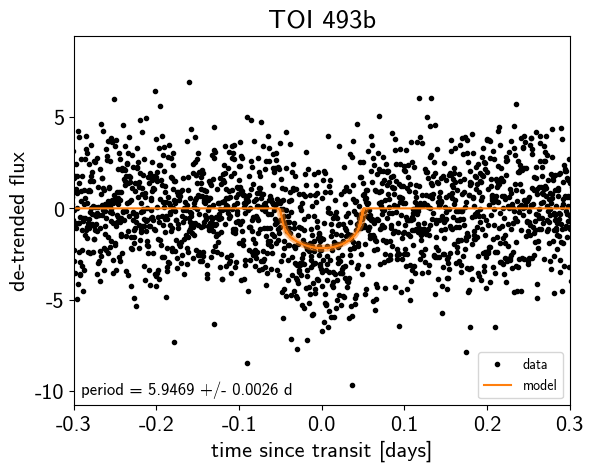

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

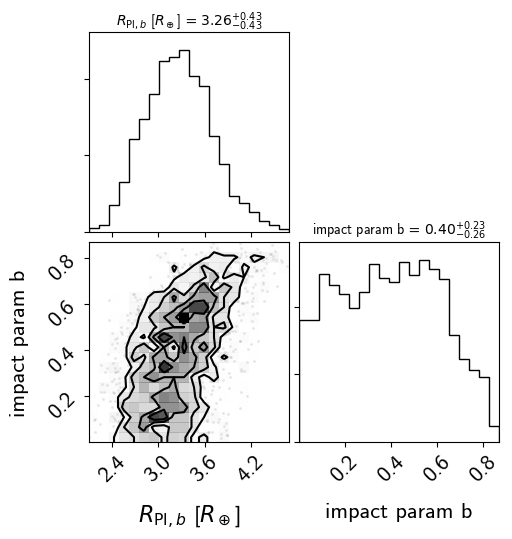

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

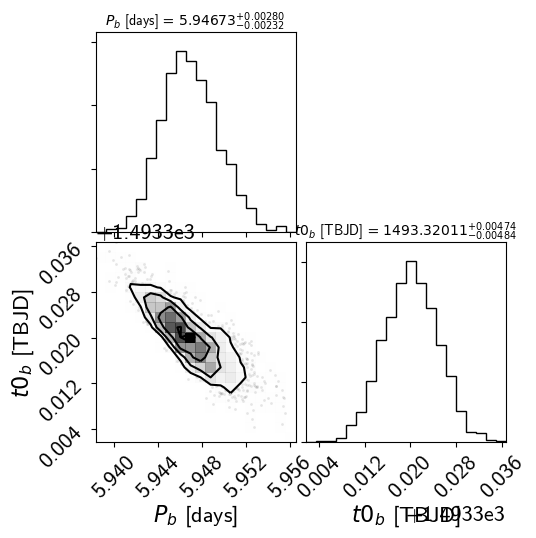

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

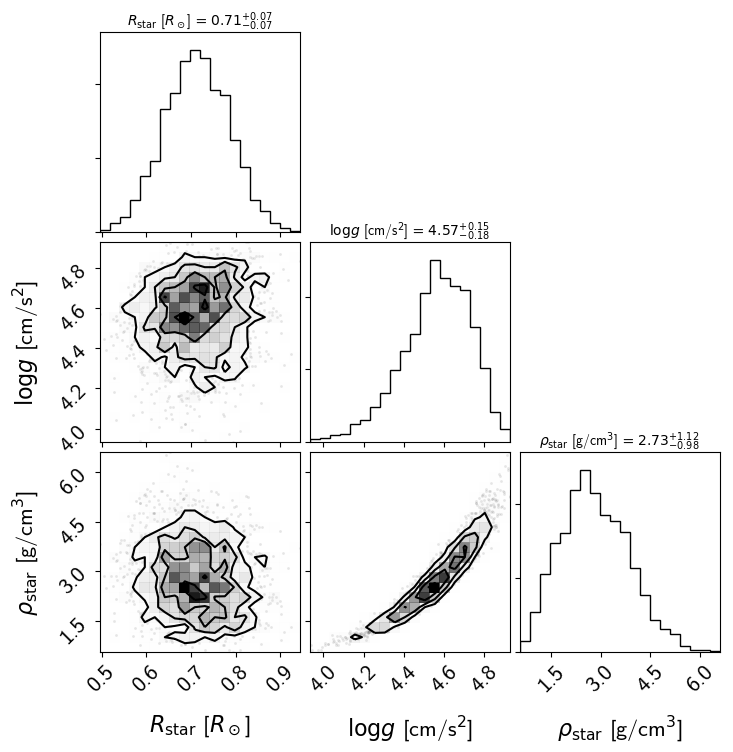

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3